In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import torch
from torch import nn

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from multiclass_performanceMetrics import *
from dataMining_functions import *
from neuralNet_functions import *
from nested_design_analysis import *

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
# load csv files containing entropy extracted from data based on discrete wavelet transform (two finest levels)
entropy_m = pd.read_csv('features/window512_neuron_entropy_rowwindow_Molino.csv', header=None)
entropy_p = pd.read_csv('features/window512_neuron_entropy_rowwindow_Pachon.csv', header=None)
entropy_s = pd.read_csv('features/window512_neuron_entropy_rowwindow_Surface.csv', header=None)

In [5]:
entropy_m

,0,1,2,3,4,5,6,7,8,9,...,869,870,871,872,873,874,875,876,877,878
0,7.893035,6.539838,8.013306,7.729771,7.895328,7.904673,7.777006,2.092313,7.206554,7.775234,...,0,0,0,0,0,0,0,0,0,0
1,7.888959,7.481470,7.961513,7.758067,7.923035,7.882443,7.908902,7.665921,7.761139,8.042748,...,0,0,0,0,0,0,0,0,0,0
2,7.323106,7.173376,7.899712,7.980307,7.830376,7.952646,8.005411,7.939777,7.904558,7.959187,...,0,0,0,0,0,0,0,0,0,0
3,7.646228,7.791536,7.905634,7.774594,7.885257,7.999103,7.782272,6.043083,7.570184,7.514908,...,0,0,0,0,0,0,0,0,0,0
4,7.874129,7.687619,7.830016,7.672146,7.996142,7.895995,7.407081,7.692267,7.947519,7.166222,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,7.991577,7.734572,7.921799,7.928110,7.919026,7.853644,3.308346,7.914074,7.015459,7.973388,...,0,0,0,0,0,0,0,0,0,0
172,7.917425,7.828190,7.899973,5.127672,7.962174,7.854050,5.380408,4.102701,4.132467,7.940133,...,0,0,0,0,0,0,0,0,0,0
173,7.893928,5.378387,7.872902,4.426261,8.080024,7.930582,3.236722,5.033111,3.782166,7.636636,...,0,0,0,0,0,0,0,0,0,0
174,7.941442,7.748443,7.906529,6.403298,7.948029,7.843256,4.618738,3.950022,6.467974,7.901544,...,0,0,0,0,0,0,0,0,0,0


In [7]:
min_col = 275  # minimum number of neurons of a fish in the data

# slicing the data set
entropy_m = entropy_m.iloc[:, :min_col]
entropy_p = entropy_p.iloc[:, :min_col]
entropy_s = entropy_s.iloc[:, :min_col]

# class lables
# molino = 0, pachon = 1, surface = 2
entropy_m['class'] = 0
entropy_p['class'] = 1
entropy_s['class'] = 2
num_class = 3

# combine all fish classes datasets
df = pd.concat([entropy_m, entropy_p], axis=0)
df = pd.concat([df, entropy_s], axis=0)




In [8]:
# get the number of nonoverlapping window obtained from the neural signal
num_window = entropy_m.shape[0] / 16  # 16 is the number of fishes in molino group in the dataset
num_window

11.0

In [9]:
# apply balanced nested design to the dataset
# to break the dependency caused by subjects(fishes) on the neural signals of a fish
balanced_nested_df = balanced_nested_design_sampling(df, num_window=num_window)


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

# Classifications

In [10]:
# shuffle data set for more randomness during training
balanced_nested_df = balanced_nested_df.sample(frac=1)
balanced_nested_df.head()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,271,272,273,274,class
262,8.185472,8.248835,5.940586,5.502435,7.784652,8.018489,4.121665,8.234744,8.058558,8.167050,...,6.226795,8.022376,8.156826,8.237629,7.455245,8.245137,8.242877,6.429258,7.977956,2
83,7.595428,7.622696,7.497601,7.523041,7.368029,7.695139,7.557981,7.664956,7.586714,7.214726,...,7.449528,7.625889,7.714998,4.416207,7.013284,7.591978,7.539336,7.574091,7.601085,0
126,7.370588,7.531178,4.392220,7.666219,6.931659,7.571549,7.550450,3.808852,7.155200,7.525811,...,6.759676,4.017828,4.891133,7.456238,7.499922,7.335415,7.507119,6.021464,7.450881,1
103,7.681034,7.766884,7.535424,7.817766,7.893457,7.743727,7.737275,7.682791,7.801354,7.616184,...,4.284689,7.379063,7.759801,6.486074,2.956797,4.893119,7.788478,4.181789,7.773431,0
342,7.113773,8.066481,7.823761,8.131993,8.056704,8.068534,8.094404,5.865272,8.130655,8.129315,...,8.070960,4.982418,7.835329,8.125066,7.437687,7.208625,8.150695,5.825542,7.803986,2


In [11]:
# train and test data split
X, y = balanced_nested_df.drop(labels='class', axis=1), balanced_nested_df['class']
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
def SMOTE_oversample(data):
    # param: data is a dataframe (normally training data) where the target feature is in the last column
    # return balanced data by applying SMOTE oversampling technique
    # this function will be used in repeat_sampling_and_training function
    #             to apply data preprocessing for every sample
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    sm = SMOTE(random_state=42, k_neighbors=12)
    X, y = sm.fit_resample(X, y)
    df = pd.concat([X, y], axis=1)
    df = df.sample(frac=1)
    return df

Neural Network

In [14]:
# check whether a GPU is available and set the device to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [15]:
# split data into test and train-validation
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=3)
# Apply SMOTE to balance the training data
# sometimes random train and test data split causes minor data imbalance
# not a big issue, but used SMOTE just in case
sm = SMOTE(random_state=42, k_neighbors=12)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(y_train.value_counts())


# form a pair of dataset and corresponding class labels
test_np = np.array(pd.concat([X_test, y_test], axis=1))
train_np = np.array(pd.concat([X_train, y_train], axis=1))
val_np = np.array(pd.concat([X_val, y_val], axis=1))

2    83
0    83
1    83
Name: class, dtype: int64


In [16]:
# simple feedforward NN
input_d = X_train.shape[1]  # input dimension
output_d = len(y_train.unique())  # output dimension
is_dropOut=True  # True means dropout layers will be applied
is_batchNorm=True  # True means batch norm will be applied
layers_dim = [input_d//3, input_d//9, input_d//27]
activations = [nn.ReLU(), nn.LeakyReLU(), nn.LeakyReLU()]
model = simpleNN(input_d, output_d, is_dropOut, is_batchNorm,
                 layers_dim=layers_dim, activations=activations)

In [17]:
model

simpleNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (layer1): Sequential(
    (0): Linear(in_features=275, out_features=91, bias=True)
    (1): BatchNorm1d(91, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (hidden_layers): Sequential(
    (hidden1): Sequential(
      (0): Linear(in_features=91, out_features=30, bias=True)
      (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (hidden2): Sequential(
      (0): Linear(in_features=30, out_features=10, bias=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (output_layer): Linear(in_features=10, out_features=3, bias=True)
)

In [18]:
# hyper params
n_epochs=1000  # number of epochs
lr=0.0005  # learning rate
loss_f = nn.CrossEntropyLoss()  # loss function
loss_f.float()
weight_decay=0.25
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer

In [19]:
# training a feedforward neural network
es = simpleEarlyStopping(patience=20)
train_res = train(model, train_np, val_np, optimizer=optimizer, loss_f=loss_f,
            batch_size=64, epochs=n_epochs, ES=es, is_binary=False)

Epoch 10/1000
Train Loss: 0.7076	Train Accuracy: 0.8838
Validation Loss: 0.7832	Validation Accuracy: 0.7759
Epoch 20/1000
Train Loss: 0.5782	Train Accuracy: 0.9883
Validation Loss: 0.6957	Validation Accuracy: 0.8276
Epoch 30/1000
Train Loss: 0.5066	Train Accuracy: 0.9805
Validation Loss: 0.5580	Validation Accuracy: 0.8966
Epoch 40/1000
Train Loss: 0.4103	Train Accuracy: 0.9922
Validation Loss: 0.5130	Validation Accuracy: 0.9655
Epoch 50/1000
Train Loss: 0.4182	Train Accuracy: 0.9839
Validation Loss: 0.4575	Validation Accuracy: 0.9483
Epoch 60/1000
Train Loss: 0.3585	Train Accuracy: 0.9839
Validation Loss: 0.4295	Validation Accuracy: 0.9828
Epoch 70/1000
Train Loss: 0.3431	Train Accuracy: 0.9961
Validation Loss: 0.3794	Validation Accuracy: 0.9828
Epoch 80/1000
Train Loss: 0.3377	Train Accuracy: 0.9917
Validation Loss: 0.3820	Validation Accuracy: 0.9655
Epoch 90/1000
Train Loss: 0.3480	Train Accuracy: 1.0000
Validation Loss: 0.4225	Validation Accuracy: 0.9483
Epoch 100/1000
Train Loss: 0

Epoch 770/1000
Train Loss: 0.5393	Train Accuracy: 0.9922
Validation Loss: 0.5903	Validation Accuracy: 0.9138
Epoch 780/1000
Train Loss: 0.5274	Train Accuracy: 0.9922
Validation Loss: 0.5673	Validation Accuracy: 0.9483
Epoch 790/1000
Train Loss: 0.5313	Train Accuracy: 0.9956
Validation Loss: 0.6005	Validation Accuracy: 0.9138
Epoch 800/1000
Train Loss: 0.5161	Train Accuracy: 1.0000
Validation Loss: 0.5488	Validation Accuracy: 0.9828
Epoch 810/1000
Train Loss: 0.5348	Train Accuracy: 0.9961
Validation Loss: 0.5960	Validation Accuracy: 0.9310
Epoch 820/1000
Train Loss: 0.5200	Train Accuracy: 1.0000
Validation Loss: 0.5745	Validation Accuracy: 0.9310
Epoch 830/1000
Train Loss: 0.5041	Train Accuracy: 0.9922
Validation Loss: 0.5831	Validation Accuracy: 0.9483
Epoch 840/1000
Train Loss: 0.5310	Train Accuracy: 0.9912
Validation Loss: 0.5470	Validation Accuracy: 0.9310
Epoch 850/1000
Train Loss: 0.5431	Train Accuracy: 0.9961
Validation Loss: 0.5912	Validation Accuracy: 0.9483
Epoch 860/1000
Trai

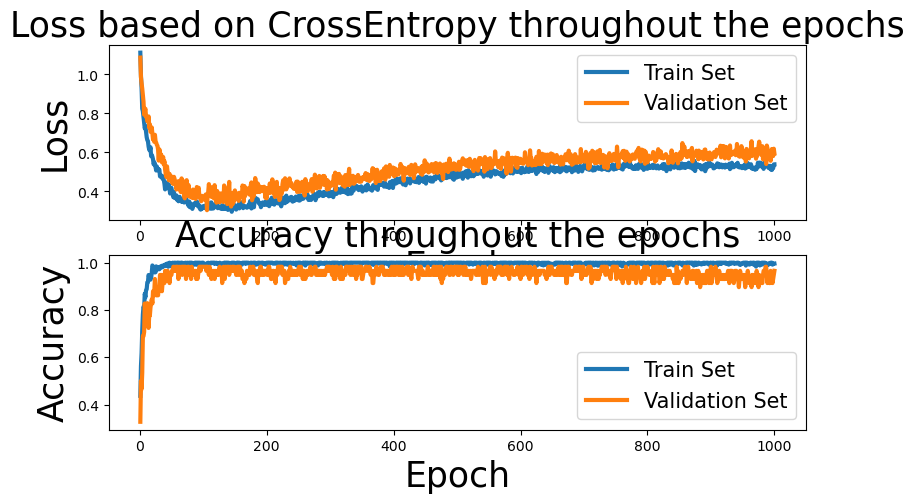

In [20]:
# plot training history
train_loss, val_loss, train_acc, val_acc = train_res
loss_fname = "CrossEntropy"
visualize_train_log(train_loss, val_loss, train_acc, val_acc, loss_fname)

In [23]:
# evaluate the model performance on training and testing data
train_true, train_pred = test(model, train_np, batch_size=512)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(train_true, train_pred, target_names=target_names))
confusion_matrix(train_true, train_pred)

              precision    recall  f1-score   support

      Molino       1.00      1.00      1.00        83
      Pachon       1.00      0.67      0.81        83
     Surface       0.75      1.00      0.86        83

    accuracy                           0.89       249
   macro avg       0.92      0.89      0.89       249
weighted avg       0.92      0.89      0.89       249



array([[83,  0,  0],
       [ 0, 56, 27],
       [ 0,  0, 83]])

In [24]:
test_true, test_pred = test(model, test_np, batch_size=512)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(test_true, test_pred, target_names=target_names))
confusion_matrix(test_true, test_pred)

              precision    recall  f1-score   support

      Molino       1.00      0.82      0.90        22
      Pachon       1.00      0.65      0.79        20
     Surface       0.74      1.00      0.85        31

    accuracy                           0.85        73
   macro avg       0.91      0.82      0.85        73
weighted avg       0.89      0.85      0.85        73



array([[18,  0,  4],
       [ 0, 13,  7],
       [ 0,  0, 31]])

In [25]:
def build_simpleNN(params):
    input_d, output_d, is_dropOut,is_batchNorm, layers_dim, activations = args
    model = simpleNN(input_d, output_d, is_dropOut, is_batchNorm,
                 layers_dim=layers_dim, activations=activations)
    return model

args = [input_d, output_d, is_dropOut,is_batchNorm, layers_dim, activations]

model_f = build_simpleNN

# random sampling and train a new model
# to more accurately test our model performace indepedent of particular samples
# Similar to the idea of K-fold cross validation
predictors = list(df.drop(labels='class', axis=1).columns)  # names of the features
res = repeat_sampling_and_trainingNN(model_f, args, df,
                                  'class', predictors, num_repeat=100, doMinMaxScaling=False,
                                  #num_window=num_window,
                                     data_processing_f=balanced_nested_design_sampling,
                                  is_oversample=True, oversample_f=SMOTE_oversample,
                                    train_f = train, test_f = test, epochs=100)

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8963	Train Accuracy: 0.4683
Validation Loss: 0.9419	Validation Accuracy: 0.5000
Epoch 20/100
Train Loss: 0.7730	Train Accuracy: 0.5643
Validation Loss: 0.8614	Validation Accuracy: 0.4828
Epoch 30/100
Train Loss: 0.7074	Train Accuracy: 0.6265
Validation Loss: 0.8127	Validation Accuracy: 0.6034
Epoch 40/100
Train Loss: 0.6518	Train Accuracy: 0.6905
Validation Loss: 0.6952	Validation Accuracy: 0.6552
Epoch 50/100
Train Loss: 0.6191	Train Accuracy: 0.7758
Validation Loss: 0.6787	Validation Accuracy: 0.7069
Epoch 60/100
Train Loss: 0.5669	Train Accuracy: 0.8733
Validation Loss: 0.6418	Validation Accuracy: 0.7931
Epoch 70/100
Train Loss: 0.5170	Train Accuracy: 0.9307
Validation Loss: 0.5684	Validation Accuracy: 0.7931
Epoch 80/100
Train Loss: 0.5110	Train Accuracy: 0.9529
Validation Loss: 0.5193	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4588	Train Accuracy: 0.9589
Validation Loss: 0.5287	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4427	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6589	Train Accuracy: 0.8001
Validation Loss: 0.7301	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.5751	Train Accuracy: 0.9137
Validation Loss: 0.6954	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.5461	Train Accuracy: 0.9360
Validation Loss: 0.6467	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.4919	Train Accuracy: 0.9589
Validation Loss: 0.5910	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4755	Train Accuracy: 0.9915
Validation Loss: 0.5433	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4508	Train Accuracy: 0.9961
Validation Loss: 0.5162	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4377	Train Accuracy: 1.0000
Validation Loss: 0.4598	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4089	Train Accuracy: 0.9961
Validation Loss: 0.4405	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.3997	Train Accuracy: 0.9961
Validation Loss: 0.4302	Validation Accuracy: 1.0000
[[25  0  0]
 [ 0 25  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8333	Train Accuracy: 0.7150
Validation Loss: 0.8576	Validation Accuracy: 0.6207
Epoch 20/100
Train Loss: 0.7170	Train Accuracy: 0.8636
Validation Loss: 0.7751	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6163	Train Accuracy: 0.9561
Validation Loss: 0.7311	Validation Accuracy: 0.8966
Epoch 40/100
Train Loss: 0.5682	Train Accuracy: 0.9561
Validation Loss: 0.6787	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.5355	Train Accuracy: 0.9665
Validation Loss: 0.6252	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4877	Train Accuracy: 0.9665
Validation Loss: 0.5412	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4719	Train Accuracy: 0.9791
Validation Loss: 0.5131	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4231	Train Accuracy: 0.9913
Validation Loss: 0.4782	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4233	Train Accuracy: 0.9957
Validation Loss: 0.4814	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4302	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6980	Train Accuracy: 0.8778
Validation Loss: 0.8665	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.6228	Train Accuracy: 0.9394
Validation Loss: 0.7581	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5608	Train Accuracy: 0.9756
Validation Loss: 0.7180	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.5301	Train Accuracy: 0.9837
Validation Loss: 0.6378	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4869	Train Accuracy: 0.9915
Validation Loss: 0.5670	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.4620	Train Accuracy: 0.9961
Validation Loss: 0.5110	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4324	Train Accuracy: 0.9876
Validation Loss: 0.5111	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4241	Train Accuracy: 1.0000
Validation Loss: 0.4629	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4214	Train Accuracy: 0.9961
Validation Loss: 0.4735	Validation Accuracy: 0.9655
[[28  0  0]
 [ 3 20  0]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7686	Train Accuracy: 0.7595
Validation Loss: 0.8595	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.7315	Train Accuracy: 0.8147
Validation Loss: 0.7883	Validation Accuracy: 0.6724
Epoch 40/100
Train Loss: 0.6732	Train Accuracy: 0.8999
Validation Loss: 0.7984	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.6323	Train Accuracy: 0.9286
Validation Loss: 0.7154	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5786	Train Accuracy: 0.9837
Validation Loss: 0.6281	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.5415	Train Accuracy: 0.9839
Validation Loss: 0.5876	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.5291	Train Accuracy: 0.9802
Validation Loss: 0.5494	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4774	Train Accuracy: 1.0000
Validation Loss: 0.5475	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4591	Train Accuracy: 1.0000
Validation Loss: 0.4927	Validation Accuracy: 0.9655
[[23  0  0]
 [ 0 22  0]
 [ 0  1 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7015	Train Accuracy: 0.9287
Validation Loss: 0.8890	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6171	Train Accuracy: 0.9564
Validation Loss: 0.7443	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5733	Train Accuracy: 0.9763
Validation Loss: 0.7059	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5324	Train Accuracy: 0.9800
Validation Loss: 0.6856	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4812	Train Accuracy: 0.9919
Validation Loss: 0.6162	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4574	Train Accuracy: 0.9961
Validation Loss: 0.5324	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4452	Train Accuracy: 1.0000
Validation Loss: 0.5709	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4233	Train Accuracy: 0.9882
Validation Loss: 0.4820	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.3965	Train Accuracy: 0.9961
Validation Loss: 0.4612	Validation Accuracy: 0.9655
[[24  0  2]
 [ 0 28  0]
 [ 0  0 19]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7862	Train Accuracy: 0.7138
Validation Loss: 0.9275	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.6981	Train Accuracy: 0.8590
Validation Loss: 0.8222	Validation Accuracy: 0.7069
Epoch 30/100
Train Loss: 0.6225	Train Accuracy: 0.9322
Validation Loss: 0.7602	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5831	Train Accuracy: 0.9676
Validation Loss: 0.7060	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.5434	Train Accuracy: 0.9841
Validation Loss: 0.6787	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4861	Train Accuracy: 0.9837
Validation Loss: 0.6353	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4730	Train Accuracy: 0.9757
Validation Loss: 0.5764	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4324	Train Accuracy: 0.9837
Validation Loss: 0.5290	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4195	Train Accuracy: 0.9876
Validation Loss: 0.4932	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.3993	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8273	Train Accuracy: 0.6551
Validation Loss: 0.8969	Validation Accuracy: 0.6379
Epoch 20/100
Train Loss: 0.7314	Train Accuracy: 0.7439
Validation Loss: 0.8275	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.6778	Train Accuracy: 0.8694
Validation Loss: 0.7670	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.6143	Train Accuracy: 0.9007
Validation Loss: 0.6505	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.5672	Train Accuracy: 0.9397
Validation Loss: 0.6357	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5339	Train Accuracy: 0.9704
Validation Loss: 0.5654	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4913	Train Accuracy: 0.9743
Validation Loss: 0.5308	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4523	Train Accuracy: 0.9788
Validation Loss: 0.4588	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4065	Train Accuracy: 0.9721
Validation Loss: 0.4739	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3864	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8238	Train Accuracy: 0.6911
Validation Loss: 0.8489	Validation Accuracy: 0.7931
Epoch 20/100
Train Loss: 0.6661	Train Accuracy: 0.7915
Validation Loss: 0.7412	Validation Accuracy: 0.7069
Epoch 30/100
Train Loss: 0.6088	Train Accuracy: 0.8523
Validation Loss: 0.6713	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5397	Train Accuracy: 0.9231
Validation Loss: 0.6018	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.4881	Train Accuracy: 0.9670
Validation Loss: 0.5445	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.4672	Train Accuracy: 0.9596
Validation Loss: 0.4834	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4347	Train Accuracy: 0.9713
Validation Loss: 0.4540	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4150	Train Accuracy: 0.9800
Validation Loss: 0.4228	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.3894	Train Accuracy: 0.9665
Validation Loss: 0.4272	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.3918	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9724	Train Accuracy: 0.3657
Validation Loss: 1.0605	Validation Accuracy: 0.3448
Epoch 20/100
Train Loss: 0.8528	Train Accuracy: 0.4591
Validation Loss: 0.9272	Validation Accuracy: 0.4138
Epoch 30/100
Train Loss: 0.7680	Train Accuracy: 0.5448
Validation Loss: 0.8877	Validation Accuracy: 0.4828
Epoch 40/100
Train Loss: 0.7357	Train Accuracy: 0.5629
Validation Loss: 0.8478	Validation Accuracy: 0.4483
Epoch 50/100
Train Loss: 0.6844	Train Accuracy: 0.6093
Validation Loss: 0.8003	Validation Accuracy: 0.5345
Epoch 60/100
Train Loss: 0.6492	Train Accuracy: 0.6297
Validation Loss: 0.7576	Validation Accuracy: 0.5690
Epoch 70/100
Train Loss: 0.6073	Train Accuracy: 0.6800
Validation Loss: 0.6688	Validation Accuracy: 0.6207
Epoch 80/100
Train Loss: 0.5837	Train Accuracy: 0.7581
Validation Loss: 0.6289	Validation Accuracy: 0.8448
Epoch 90/100
Train Loss: 0.5436	Train Accuracy: 0.8537
Validation Loss: 0.6171	Validation Accuracy: 0.8793
Epoch 100/100
Train Loss: 0.5300	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8995	Train Accuracy: 0.4683
Validation Loss: 0.9150	Validation Accuracy: 0.5345
Epoch 20/100
Train Loss: 0.7997	Train Accuracy: 0.6533
Validation Loss: 0.8591	Validation Accuracy: 0.5517
Epoch 30/100
Train Loss: 0.7128	Train Accuracy: 0.7611
Validation Loss: 0.8301	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.6638	Train Accuracy: 0.9040
Validation Loss: 0.7116	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.6327	Train Accuracy: 0.8792
Validation Loss: 0.6305	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.5922	Train Accuracy: 0.9257
Validation Loss: 0.5813	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.5368	Train Accuracy: 0.9010
Validation Loss: 0.5165	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.5496	Train Accuracy: 0.9136
Validation Loss: 0.4936	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.5076	Train Accuracy: 0.9101
Validation Loss: 0.4965	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4911	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7468	Train Accuracy: 0.8058
Validation Loss: 0.8097	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.6629	Train Accuracy: 0.8441
Validation Loss: 0.7233	Validation Accuracy: 0.7069
Epoch 40/100
Train Loss: 0.5903	Train Accuracy: 0.9292
Validation Loss: 0.6547	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5433	Train Accuracy: 0.9509
Validation Loss: 0.6263	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.4992	Train Accuracy: 0.9748
Validation Loss: 0.5719	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4701	Train Accuracy: 0.9640
Validation Loss: 0.4874	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4487	Train Accuracy: 0.9800
Validation Loss: 0.4470	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4329	Train Accuracy: 0.9961
Validation Loss: 0.4494	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3967	Train Accuracy: 0.9913
Validation Loss: 0.4215	Validation Accuracy: 0.9828
[[28  0  0]
 [ 0 22  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7234	Train Accuracy: 0.7132
Validation Loss: 0.8952	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.6379	Train Accuracy: 0.7969
Validation Loss: 0.8562	Validation Accuracy: 0.6379
Epoch 40/100
Train Loss: 0.5731	Train Accuracy: 0.9007
Validation Loss: 0.6893	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.5397	Train Accuracy: 0.9280
Validation Loss: 0.6510	Validation Accuracy: 0.7586
Epoch 60/100
Train Loss: 0.4938	Train Accuracy: 0.9710
Validation Loss: 0.6041	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.4615	Train Accuracy: 0.9782
Validation Loss: 0.5480	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.4194	Train Accuracy: 0.9866
Validation Loss: 0.4659	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.4061	Train Accuracy: 0.9782
Validation Loss: 0.4591	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.3670	Train Accuracy: 0.9911
Validation Loss: 0.4462	Validation Accuracy: 0.9655
[[27  0  0]
 [ 0 24  0]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8934	Train Accuracy: 0.6584
Validation Loss: 0.9361	Validation Accuracy: 0.6379
Epoch 20/100
Train Loss: 0.7641	Train Accuracy: 0.8857
Validation Loss: 0.8629	Validation Accuracy: 0.6897
Epoch 30/100
Train Loss: 0.6862	Train Accuracy: 0.9582
Validation Loss: 0.7677	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.6303	Train Accuracy: 0.9621
Validation Loss: 0.6967	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.5517	Train Accuracy: 0.9915
Validation Loss: 0.6190	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.5400	Train Accuracy: 1.0000
Validation Loss: 0.6125	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5031	Train Accuracy: 0.9954
Validation Loss: 0.5192	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4632	Train Accuracy: 0.9915
Validation Loss: 0.5228	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4530	Train Accuracy: 0.9876
Validation Loss: 0.4508	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4247	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8114	Train Accuracy: 0.8059
Validation Loss: 0.8850	Validation Accuracy: 0.6207
Epoch 30/100
Train Loss: 0.7313	Train Accuracy: 0.8948
Validation Loss: 0.8127	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.6812	Train Accuracy: 0.9189
Validation Loss: 0.7593	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.6286	Train Accuracy: 0.9384
Validation Loss: 0.6577	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5677	Train Accuracy: 0.9590
Validation Loss: 0.6208	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.5199	Train Accuracy: 0.9883
Validation Loss: 0.5541	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4865	Train Accuracy: 0.9798
Validation Loss: 0.5068	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4739	Train Accuracy: 0.9671
Validation Loss: 0.5069	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4416	Train Accuracy: 0.9922
Validation Loss: 0.4284	Validation Accuracy: 0.9828
[[18  1  0]
 [ 0 25  0]
 [ 0  0 29]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6530	Train Accuracy: 0.9319
Validation Loss: 0.8070	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6042	Train Accuracy: 0.9537
Validation Loss: 0.7245	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.5537	Train Accuracy: 0.9916
Validation Loss: 0.6839	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5158	Train Accuracy: 0.9872
Validation Loss: 0.6218	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4861	Train Accuracy: 0.9877
Validation Loss: 0.6120	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4405	Train Accuracy: 0.9955
Validation Loss: 0.5176	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4540	Train Accuracy: 1.0000
Validation Loss: 0.5241	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4281	Train Accuracy: 1.0000
Validation Loss: 0.4836	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4135	Train Accuracy: 1.0000
Validation Loss: 0.4344	Validation Accuracy: 0.9828
[[25  0  0]
 [ 0 22  2]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8567	Train Accuracy: 0.6694
Validation Loss: 0.9287	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.6943	Train Accuracy: 0.7833
Validation Loss: 0.8497	Validation Accuracy: 0.6897
Epoch 30/100
Train Loss: 0.6181	Train Accuracy: 0.8953
Validation Loss: 0.7836	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.5469	Train Accuracy: 0.9357
Validation Loss: 0.7290	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.4949	Train Accuracy: 0.9665
Validation Loss: 0.6564	Validation Accuracy: 0.8276
Epoch 60/100
Train Loss: 0.4809	Train Accuracy: 0.9665
Validation Loss: 0.5618	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.4354	Train Accuracy: 0.9744
Validation Loss: 0.5613	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.4450	Train Accuracy: 0.9917
Validation Loss: 0.4677	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4097	Train Accuracy: 0.9878
Validation Loss: 0.4965	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.3863	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8164	Train Accuracy: 0.6270
Validation Loss: 0.9249	Validation Accuracy: 0.5517
Epoch 20/100
Train Loss: 0.7407	Train Accuracy: 0.6591
Validation Loss: 0.8424	Validation Accuracy: 0.5000
Epoch 30/100
Train Loss: 0.6912	Train Accuracy: 0.7340
Validation Loss: 0.7906	Validation Accuracy: 0.6207
Epoch 40/100
Train Loss: 0.6482	Train Accuracy: 0.7975
Validation Loss: 0.7377	Validation Accuracy: 0.6724
Epoch 50/100
Train Loss: 0.6033	Train Accuracy: 0.9444
Validation Loss: 0.6680	Validation Accuracy: 0.8103
Epoch 60/100
Train Loss: 0.5483	Train Accuracy: 0.9723
Validation Loss: 0.6122	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5256	Train Accuracy: 0.9763
Validation Loss: 0.5898	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.4889	Train Accuracy: 0.9921
Validation Loss: 0.5313	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4671	Train Accuracy: 0.9960
Validation Loss: 0.5157	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4385	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6738	Train Accuracy: 0.8717
Validation Loss: 0.7402	Validation Accuracy: 0.7931
Epoch 30/100
Train Loss: 0.6352	Train Accuracy: 0.9332
Validation Loss: 0.6563	Validation Accuracy: 0.9138
Epoch 40/100
Train Loss: 0.5986	Train Accuracy: 0.9332
Validation Loss: 0.5943	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5262	Train Accuracy: 0.9870
Validation Loss: 0.5699	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4637	Train Accuracy: 0.9844
Validation Loss: 0.4996	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4230	Train Accuracy: 0.9896
Validation Loss: 0.4872	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4278	Train Accuracy: 0.9844
Validation Loss: 0.4832	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4322	Train Accuracy: 1.0000
Validation Loss: 0.4514	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3856	Train Accuracy: 1.0000
Validation Loss: 0.4221	Validation Accuracy: 0.9655
[[11  2  0]
 [ 0 32  0]
 [ 3  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8627	Train Accuracy: 0.5728
Validation Loss: 0.8686	Validation Accuracy: 0.5517
Epoch 30/100
Train Loss: 0.7907	Train Accuracy: 0.7112
Validation Loss: 0.8341	Validation Accuracy: 0.6207
Epoch 40/100
Train Loss: 0.7251	Train Accuracy: 0.8230
Validation Loss: 0.7649	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.6582	Train Accuracy: 0.9040
Validation Loss: 0.6887	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.6145	Train Accuracy: 0.9504
Validation Loss: 0.6260	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.5844	Train Accuracy: 0.9341
Validation Loss: 0.5765	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.5328	Train Accuracy: 0.9523
Validation Loss: 0.5235	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.5030	Train Accuracy: 0.9954
Validation Loss: 0.5498	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4914	Train Accuracy: 0.9961
Validation Loss: 0.5260	Validation Accuracy: 1.0000
[[28  0  0]
 [ 0 22  0]
 [ 1  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7274	Train Accuracy: 0.8310
Validation Loss: 0.7820	Validation Accuracy: 0.6207
Epoch 30/100
Train Loss: 0.6658	Train Accuracy: 0.9227
Validation Loss: 0.6949	Validation Accuracy: 0.8793
Epoch 40/100
Train Loss: 0.5962	Train Accuracy: 0.9553
Validation Loss: 0.6742	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.5613	Train Accuracy: 0.9626
Validation Loss: 0.6128	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5162	Train Accuracy: 0.9839
Validation Loss: 0.5345	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4860	Train Accuracy: 0.9791
Validation Loss: 0.5116	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4340	Train Accuracy: 0.9922
Validation Loss: 0.4712	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4417	Train Accuracy: 0.9917
Validation Loss: 0.4839	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4289	Train Accuracy: 0.9957
Validation Loss: 0.4371	Validation Accuracy: 0.9828
[[18  0  0]
 [ 0 29  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8841	Train Accuracy: 0.8209
Validation Loss: 0.9286	Validation Accuracy: 0.7241
Epoch 20/100
Train Loss: 0.7602	Train Accuracy: 0.9353
Validation Loss: 0.8444	Validation Accuracy: 0.8448
Epoch 30/100
Train Loss: 0.6877	Train Accuracy: 0.9743
Validation Loss: 0.7699	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.6225	Train Accuracy: 1.0000
Validation Loss: 0.7161	Validation Accuracy: 0.9483
Epoch 50/100
Train Loss: 0.5920	Train Accuracy: 0.9916
Validation Loss: 0.6508	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5426	Train Accuracy: 0.9955
Validation Loss: 0.6107	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.5440	Train Accuracy: 1.0000
Validation Loss: 0.5617	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.5041	Train Accuracy: 1.0000
Validation Loss: 0.5270	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4941	Train Accuracy: 1.0000
Validation Loss: 0.4977	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4618	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6776	Train Accuracy: 0.8785
Validation Loss: 0.8136	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.6132	Train Accuracy: 0.9479
Validation Loss: 0.7049	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5479	Train Accuracy: 0.9717
Validation Loss: 0.6794	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5129	Train Accuracy: 0.9759
Validation Loss: 0.6013	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5118	Train Accuracy: 0.9958
Validation Loss: 0.5782	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4465	Train Accuracy: 1.0000
Validation Loss: 0.5260	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4684	Train Accuracy: 1.0000
Validation Loss: 0.4648	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4224	Train Accuracy: 1.0000
Validation Loss: 0.4839	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4162	Train Accuracy: 0.9958
Validation Loss: 0.4187	Validation Accuracy: 0.9828
[[21  0  0]
 [ 0 28  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8064	Train Accuracy: 0.7444
Validation Loss: 0.8668	Validation Accuracy: 0.6897
Epoch 20/100
Train Loss: 0.6775	Train Accuracy: 0.8689
Validation Loss: 0.7543	Validation Accuracy: 0.8448
Epoch 30/100
Train Loss: 0.6133	Train Accuracy: 0.9297
Validation Loss: 0.7045	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5418	Train Accuracy: 0.9704
Validation Loss: 0.6287	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.4814	Train Accuracy: 0.9721
Validation Loss: 0.6090	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.4540	Train Accuracy: 0.9916
Validation Loss: 0.5063	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4172	Train Accuracy: 0.9961
Validation Loss: 0.4520	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4050	Train Accuracy: 1.0000
Validation Loss: 0.4556	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3865	Train Accuracy: 0.9922
Validation Loss: 0.4210	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3740	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7377	Train Accuracy: 0.6352
Validation Loss: 0.8980	Validation Accuracy: 0.5690
Epoch 30/100
Train Loss: 0.6687	Train Accuracy: 0.7085
Validation Loss: 0.8481	Validation Accuracy: 0.6034
Epoch 40/100
Train Loss: 0.6094	Train Accuracy: 0.7932
Validation Loss: 0.7842	Validation Accuracy: 0.7241
Epoch 50/100
Train Loss: 0.5633	Train Accuracy: 0.9000
Validation Loss: 0.6885	Validation Accuracy: 0.7414
Epoch 60/100
Train Loss: 0.5176	Train Accuracy: 0.9462
Validation Loss: 0.5913	Validation Accuracy: 0.7931
Epoch 70/100
Train Loss: 0.4872	Train Accuracy: 0.9427
Validation Loss: 0.6206	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.4914	Train Accuracy: 0.9544
Validation Loss: 0.5696	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4497	Train Accuracy: 0.9723
Validation Loss: 0.4850	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4348	Train Accuracy: 0.9635
Validation Loss: 0.4628	Validation Accuracy: 0.9310
[[25  0  0]
 [ 0 23  0]
 [ 0  2 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8031	Train Accuracy: 0.7474
Validation Loss: 0.8322	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.7135	Train Accuracy: 0.8694
Validation Loss: 0.7857	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.6611	Train Accuracy: 0.9419
Validation Loss: 0.7402	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.6049	Train Accuracy: 0.9419
Validation Loss: 0.6976	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5767	Train Accuracy: 0.9869
Validation Loss: 0.6386	Validation Accuracy: 1.0000
Epoch 70/100
Train Loss: 0.5419	Train Accuracy: 1.0000
Validation Loss: 0.5748	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.5146	Train Accuracy: 0.9961
Validation Loss: 0.5388	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4861	Train Accuracy: 0.9908
Validation Loss: 0.4972	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4491	Train Accuracy: 0.9954
Validation Loss: 0.4637	Validation Accuracy: 0.9828
[[26  0  0]
 [ 0 21  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7545	Train Accuracy: 0.7819
Validation Loss: 0.9125	Validation Accuracy: 0.5345
Epoch 30/100
Train Loss: 0.7086	Train Accuracy: 0.7928
Validation Loss: 0.8965	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.6355	Train Accuracy: 0.8258
Validation Loss: 0.7804	Validation Accuracy: 0.6724
Epoch 50/100
Train Loss: 0.5834	Train Accuracy: 0.8892
Validation Loss: 0.6550	Validation Accuracy: 0.8103
Epoch 60/100
Train Loss: 0.5486	Train Accuracy: 0.8862
Validation Loss: 0.6305	Validation Accuracy: 0.8448
Epoch 70/100
Train Loss: 0.5143	Train Accuracy: 0.9349
Validation Loss: 0.5869	Validation Accuracy: 0.8448
Epoch 80/100
Train Loss: 0.4870	Train Accuracy: 0.9518
Validation Loss: 0.5510	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4457	Train Accuracy: 0.9640
Validation Loss: 0.4872	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4310	Train Accuracy: 0.9452
Validation Loss: 0.4570	Validation Accuracy: 0.9310
[[25  0  2]
 [ 0 23  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7254	Train Accuracy: 0.8228
Validation Loss: 0.8439	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6315	Train Accuracy: 0.9340
Validation Loss: 0.7364	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.5650	Train Accuracy: 0.9700
Validation Loss: 0.6229	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.5083	Train Accuracy: 0.9874
Validation Loss: 0.5573	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4509	Train Accuracy: 0.9917
Validation Loss: 0.5064	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4268	Train Accuracy: 0.9922
Validation Loss: 0.4860	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4206	Train Accuracy: 0.9961
Validation Loss: 0.4402	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.3814	Train Accuracy: 1.0000
Validation Loss: 0.4285	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3594	Train Accuracy: 0.9961
Validation Loss: 0.3715	Validation Accuracy: 1.0000
[[23  0  0]
 [ 0 22  0]
 [ 0  0 28]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8048	Train Accuracy: 0.8478
Validation Loss: 0.9147	Validation Accuracy: 0.6379
Epoch 20/100
Train Loss: 0.6792	Train Accuracy: 0.9314
Validation Loss: 0.7872	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6244	Train Accuracy: 0.9667
Validation Loss: 0.6864	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.5513	Train Accuracy: 0.9653
Validation Loss: 0.6669	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5068	Train Accuracy: 0.9791
Validation Loss: 0.6354	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.4777	Train Accuracy: 0.9798
Validation Loss: 0.5055	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4445	Train Accuracy: 1.0000
Validation Loss: 0.5319	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4248	Train Accuracy: 0.9961
Validation Loss: 0.4515	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4032	Train Accuracy: 1.0000
Validation Loss: 0.4381	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3923	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6976	Train Accuracy: 0.8601
Validation Loss: 0.8343	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6294	Train Accuracy: 0.9083
Validation Loss: 0.7752	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.5895	Train Accuracy: 0.9798
Validation Loss: 0.7297	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.5331	Train Accuracy: 0.9922
Validation Loss: 0.6346	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.4975	Train Accuracy: 0.9713
Validation Loss: 0.5491	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4689	Train Accuracy: 0.9959
Validation Loss: 0.4787	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4204	Train Accuracy: 1.0000
Validation Loss: 0.4364	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.3923	Train Accuracy: 0.9961
Validation Loss: 0.4330	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3981	Train Accuracy: 0.9881
Validation Loss: 0.4343	Validation Accuracy: 1.0000
[[22  0  0]
 [ 0 25  0]
 [ 1  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8560	Train Accuracy: 0.6187
Validation Loss: 0.9819	Validation Accuracy: 0.5517
Epoch 20/100
Train Loss: 0.7823	Train Accuracy: 0.8002
Validation Loss: 0.8538	Validation Accuracy: 0.5690
Epoch 30/100
Train Loss: 0.6969	Train Accuracy: 0.9153
Validation Loss: 0.8233	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.6350	Train Accuracy: 0.9355
Validation Loss: 0.7522	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.6016	Train Accuracy: 1.0000
Validation Loss: 0.7147	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5573	Train Accuracy: 0.9920
Validation Loss: 0.6362	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.5305	Train Accuracy: 1.0000
Validation Loss: 0.5968	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4998	Train Accuracy: 0.9959
Validation Loss: 0.5456	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4798	Train Accuracy: 1.0000
Validation Loss: 0.5517	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.4724	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.5966	Train Accuracy: 0.9180
Validation Loss: 0.7330	Validation Accuracy: 0.8103
Epoch 30/100
Train Loss: 0.5486	Train Accuracy: 0.9202
Validation Loss: 0.6728	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.4802	Train Accuracy: 0.9827
Validation Loss: 0.5775	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.4384	Train Accuracy: 0.9877
Validation Loss: 0.5708	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.4180	Train Accuracy: 0.9961
Validation Loss: 0.5487	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.3927	Train Accuracy: 0.9916
Validation Loss: 0.4868	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.3802	Train Accuracy: 0.9961
Validation Loss: 0.4178	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3592	Train Accuracy: 0.9916
Validation Loss: 0.3822	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3410	Train Accuracy: 1.0000
Validation Loss: 0.3811	Validation Accuracy: 1.0000
[[22  0  0]
 [ 0 29  0]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8300	Train Accuracy: 0.7852
Validation Loss: 0.8639	Validation Accuracy: 0.7241
Epoch 20/100
Train Loss: 0.7214	Train Accuracy: 0.9375
Validation Loss: 0.8032	Validation Accuracy: 0.8448
Epoch 30/100
Train Loss: 0.6605	Train Accuracy: 0.9922
Validation Loss: 0.7321	Validation Accuracy: 0.7414
Epoch 40/100
Train Loss: 0.6070	Train Accuracy: 0.9833
Validation Loss: 0.6648	Validation Accuracy: 0.9655
Epoch 50/100
Train Loss: 0.5469	Train Accuracy: 0.9961
Validation Loss: 0.6181	Validation Accuracy: 0.9828
Epoch 60/100
Train Loss: 0.5197	Train Accuracy: 0.9844
Validation Loss: 0.5737	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4733	Train Accuracy: 1.0000
Validation Loss: 0.5514	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4550	Train Accuracy: 1.0000
Validation Loss: 0.5083	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4283	Train Accuracy: 1.0000
Validation Loss: 0.4517	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3985	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8305	Train Accuracy: 0.7280
Validation Loss: 0.9344	Validation Accuracy: 0.5690
Epoch 20/100
Train Loss: 0.7186	Train Accuracy: 0.8785
Validation Loss: 0.8294	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.6346	Train Accuracy: 0.9147
Validation Loss: 0.8112	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.5780	Train Accuracy: 0.9756
Validation Loss: 0.7007	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.5367	Train Accuracy: 0.9876
Validation Loss: 0.6494	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.5009	Train Accuracy: 0.9958
Validation Loss: 0.5873	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4686	Train Accuracy: 0.9958
Validation Loss: 0.5126	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4477	Train Accuracy: 1.0000
Validation Loss: 0.4640	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4181	Train Accuracy: 1.0000
Validation Loss: 0.4395	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3946	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7374	Train Accuracy: 0.8671
Validation Loss: 0.8915	Validation Accuracy: 0.8276
Epoch 30/100
Train Loss: 0.6418	Train Accuracy: 0.9096
Validation Loss: 0.7548	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5849	Train Accuracy: 0.9500
Validation Loss: 0.6773	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.5322	Train Accuracy: 0.9744
Validation Loss: 0.6161	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4938	Train Accuracy: 0.9700
Validation Loss: 0.5521	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4766	Train Accuracy: 0.9831
Validation Loss: 0.4984	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4465	Train Accuracy: 0.9752
Validation Loss: 0.5242	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4263	Train Accuracy: 0.9761
Validation Loss: 0.4735	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4186	Train Accuracy: 0.9874
Validation Loss: 0.4943	Validation Accuracy: 0.9138
[[22  0  0]
 [ 0 25  0]
 [ 0  2 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7310	Train Accuracy: 0.8935
Validation Loss: 0.8328	Validation Accuracy: 0.8793
Epoch 30/100
Train Loss: 0.6470	Train Accuracy: 0.9569
Validation Loss: 0.7732	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.5807	Train Accuracy: 0.9759
Validation Loss: 0.6825	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5450	Train Accuracy: 0.9869
Validation Loss: 0.6308	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.5314	Train Accuracy: 0.9817
Validation Loss: 0.5697	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4783	Train Accuracy: 0.9869
Validation Loss: 0.5143	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4693	Train Accuracy: 0.9954
Validation Loss: 0.5208	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4450	Train Accuracy: 1.0000
Validation Loss: 0.4518	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4112	Train Accuracy: 0.9954
Validation Loss: 0.4267	Validation Accuracy: 1.0000
[[24  0  0]
 [ 0 25  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8185	Train Accuracy: 0.7828
Validation Loss: 0.8249	Validation Accuracy: 0.7241
Epoch 20/100
Train Loss: 0.7243	Train Accuracy: 0.8688
Validation Loss: 0.8009	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6514	Train Accuracy: 0.9718
Validation Loss: 0.7220	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.5841	Train Accuracy: 0.9596
Validation Loss: 0.6515	Validation Accuracy: 0.9483
Epoch 50/100
Train Loss: 0.5334	Train Accuracy: 0.9961
Validation Loss: 0.5885	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5037	Train Accuracy: 1.0000
Validation Loss: 0.5854	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4545	Train Accuracy: 0.9878
Validation Loss: 0.5093	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4480	Train Accuracy: 0.9874
Validation Loss: 0.4516	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4145	Train Accuracy: 0.9913
Validation Loss: 0.4576	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4130	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7508	Train Accuracy: 0.7238
Validation Loss: 0.8410	Validation Accuracy: 0.6207
Epoch 30/100
Train Loss: 0.6960	Train Accuracy: 0.8265
Validation Loss: 0.7810	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.6256	Train Accuracy: 0.8834
Validation Loss: 0.7054	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5613	Train Accuracy: 0.9330
Validation Loss: 0.6451	Validation Accuracy: 0.8276
Epoch 60/100
Train Loss: 0.5359	Train Accuracy: 0.9621
Validation Loss: 0.5757	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4803	Train Accuracy: 0.9794
Validation Loss: 0.5240	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4585	Train Accuracy: 0.9838
Validation Loss: 0.4760	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4532	Train Accuracy: 0.9961
Validation Loss: 0.4620	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4322	Train Accuracy: 0.9838
Validation Loss: 0.4143	Validation Accuracy: 0.9828
[[27  0  0]
 [ 0 23  1]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9330	Train Accuracy: 0.4291
Validation Loss: 0.9800	Validation Accuracy: 0.3793
Epoch 20/100
Train Loss: 0.8010	Train Accuracy: 0.5413
Validation Loss: 0.8924	Validation Accuracy: 0.4828
Epoch 30/100
Train Loss: 0.7304	Train Accuracy: 0.6847
Validation Loss: 0.8004	Validation Accuracy: 0.6207
Epoch 40/100
Train Loss: 0.6394	Train Accuracy: 0.8488
Validation Loss: 0.7217	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.5988	Train Accuracy: 0.9291
Validation Loss: 0.6771	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5564	Train Accuracy: 0.9581
Validation Loss: 0.6243	Validation Accuracy: 0.8448
Epoch 70/100
Train Loss: 0.4942	Train Accuracy: 0.9799
Validation Loss: 0.5471	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4777	Train Accuracy: 0.9821
Validation Loss: 0.5501	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4710	Train Accuracy: 0.9877
Validation Loss: 0.5214	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.4351	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8357	Train Accuracy: 0.7879
Validation Loss: 0.8920	Validation Accuracy: 0.6724
Epoch 20/100
Train Loss: 0.6862	Train Accuracy: 0.8714
Validation Loss: 0.7879	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6243	Train Accuracy: 0.9632
Validation Loss: 0.7200	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.5540	Train Accuracy: 0.9678
Validation Loss: 0.6892	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.5216	Train Accuracy: 0.9834
Validation Loss: 0.5981	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4667	Train Accuracy: 0.9915
Validation Loss: 0.5582	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4375	Train Accuracy: 1.0000
Validation Loss: 0.5202	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4130	Train Accuracy: 0.9880
Validation Loss: 0.4893	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4036	Train Accuracy: 0.9961
Validation Loss: 0.4784	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4099	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6938	Train Accuracy: 0.9713
Validation Loss: 0.7751	Validation Accuracy: 0.7931
Epoch 30/100
Train Loss: 0.6379	Train Accuracy: 0.9626
Validation Loss: 0.7698	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.6072	Train Accuracy: 0.9709
Validation Loss: 0.7151	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5309	Train Accuracy: 0.9917
Validation Loss: 0.5878	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5010	Train Accuracy: 1.0000
Validation Loss: 0.5835	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4836	Train Accuracy: 0.9917
Validation Loss: 0.5178	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4250	Train Accuracy: 0.9922
Validation Loss: 0.4875	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4365	Train Accuracy: 0.9961
Validation Loss: 0.4563	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4009	Train Accuracy: 1.0000
Validation Loss: 0.3983	Validation Accuracy: 0.9655
[[19  0  0]
 [ 0 26  0]
 [ 1  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7206	Train Accuracy: 0.8899
Validation Loss: 0.8736	Validation Accuracy: 0.6207
Epoch 30/100
Train Loss: 0.6441	Train Accuracy: 0.9713
Validation Loss: 0.8058	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.5939	Train Accuracy: 0.9554
Validation Loss: 0.7240	Validation Accuracy: 0.7759
Epoch 50/100
Train Loss: 0.5616	Train Accuracy: 1.0000
Validation Loss: 0.6880	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.5283	Train Accuracy: 0.9958
Validation Loss: 0.6181	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.5044	Train Accuracy: 0.9958
Validation Loss: 0.5890	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4894	Train Accuracy: 0.9961
Validation Loss: 0.5206	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4833	Train Accuracy: 1.0000
Validation Loss: 0.5311	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4467	Train Accuracy: 1.0000
Validation Loss: 0.4861	Validation Accuracy: 1.0000
[[28  0  0]
 [ 1 21  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7727	Train Accuracy: 0.6953
Validation Loss: 0.8144	Validation Accuracy: 0.5517
Epoch 30/100
Train Loss: 0.6737	Train Accuracy: 0.7461
Validation Loss: 0.8054	Validation Accuracy: 0.6034
Epoch 40/100
Train Loss: 0.6258	Train Accuracy: 0.8571
Validation Loss: 0.7297	Validation Accuracy: 0.6379
Epoch 50/100
Train Loss: 0.5898	Train Accuracy: 0.8867
Validation Loss: 0.6886	Validation Accuracy: 0.7241
Epoch 60/100
Train Loss: 0.5324	Train Accuracy: 0.8817
Validation Loss: 0.6389	Validation Accuracy: 0.8276
Epoch 70/100
Train Loss: 0.5039	Train Accuracy: 0.9520
Validation Loss: 0.5597	Validation Accuracy: 0.8448
Epoch 80/100
Train Loss: 0.5027	Train Accuracy: 0.9475
Validation Loss: 0.5378	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.4622	Train Accuracy: 0.9754
Validation Loss: 0.5148	Validation Accuracy: 0.8793
Epoch 100/100
Train Loss: 0.4333	Train Accuracy: 0.9922
Validation Loss: 0.4926	Validation Accuracy: 1.0000
[[22  0  0]
 [ 0 27  0]
 [ 0  2 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8353	Train Accuracy: 0.7098
Validation Loss: 0.8308	Validation Accuracy: 0.6552
Epoch 20/100
Train Loss: 0.7393	Train Accuracy: 0.7796
Validation Loss: 0.7899	Validation Accuracy: 0.6897
Epoch 30/100
Train Loss: 0.6754	Train Accuracy: 0.8348
Validation Loss: 0.7476	Validation Accuracy: 0.7414
Epoch 40/100
Train Loss: 0.6253	Train Accuracy: 0.9180
Validation Loss: 0.7031	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.6124	Train Accuracy: 0.9090
Validation Loss: 0.6404	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5582	Train Accuracy: 0.9107
Validation Loss: 0.5484	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.5262	Train Accuracy: 0.9381
Validation Loss: 0.5519	Validation Accuracy: 0.8966
Epoch 80/100
Train Loss: 0.4942	Train Accuracy: 0.9615
Validation Loss: 0.5235	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4810	Train Accuracy: 0.9799
Validation Loss: 0.5034	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.4594	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6633	Train Accuracy: 0.7427
Validation Loss: 0.7613	Validation Accuracy: 0.6897
Epoch 30/100
Train Loss: 0.6065	Train Accuracy: 0.8655
Validation Loss: 0.7236	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5659	Train Accuracy: 0.8795
Validation Loss: 0.6567	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5406	Train Accuracy: 0.9124
Validation Loss: 0.6565	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5042	Train Accuracy: 0.9760
Validation Loss: 0.5321	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.5004	Train Accuracy: 0.9782
Validation Loss: 0.5396	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4747	Train Accuracy: 0.9961
Validation Loss: 0.5200	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4514	Train Accuracy: 0.9916
Validation Loss: 0.5143	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4644	Train Accuracy: 0.9877
Validation Loss: 0.4872	Validation Accuracy: 0.9828
[[28  0  0]
 [ 0 21  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8723	Train Accuracy: 0.6618
Validation Loss: 1.0212	Validation Accuracy: 0.5690
Epoch 20/100
Train Loss: 0.7529	Train Accuracy: 0.8753
Validation Loss: 0.8833	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.6747	Train Accuracy: 0.9210
Validation Loss: 0.7739	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.6048	Train Accuracy: 0.9621
Validation Loss: 0.7831	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5735	Train Accuracy: 0.9608
Validation Loss: 0.6496	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5341	Train Accuracy: 0.9621
Validation Loss: 0.5861	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4800	Train Accuracy: 0.9869
Validation Loss: 0.5111	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4711	Train Accuracy: 0.9908
Validation Loss: 0.5191	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4401	Train Accuracy: 0.9798
Validation Loss: 0.4895	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4340	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6713	Train Accuracy: 0.9466
Validation Loss: 0.8121	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.5987	Train Accuracy: 0.9722
Validation Loss: 0.6722	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5319	Train Accuracy: 0.9870
Validation Loss: 0.6495	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.4907	Train Accuracy: 0.9874
Validation Loss: 0.6217	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4732	Train Accuracy: 0.9917
Validation Loss: 0.6335	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4397	Train Accuracy: 0.9874
Validation Loss: 0.5338	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.4283	Train Accuracy: 0.9917
Validation Loss: 0.4671	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4120	Train Accuracy: 0.9957
Validation Loss: 0.4640	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3933	Train Accuracy: 0.9957
Validation Loss: 0.3645	Validation Accuracy: 0.9828
[[22  2  0]
 [ 1 28  0]
 [ 0  0 20]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6557	Train Accuracy: 0.9068
Validation Loss: 0.7987	Validation Accuracy: 0.8793
Epoch 30/100
Train Loss: 0.5580	Train Accuracy: 0.9635
Validation Loss: 0.6740	Validation Accuracy: 0.9138
Epoch 40/100
Train Loss: 0.5197	Train Accuracy: 0.9777
Validation Loss: 0.5541	Validation Accuracy: 0.9483
Epoch 50/100
Train Loss: 0.4569	Train Accuracy: 0.9961
Validation Loss: 0.5600	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4367	Train Accuracy: 0.9869
Validation Loss: 0.4692	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4090	Train Accuracy: 0.9961
Validation Loss: 0.4816	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.3856	Train Accuracy: 0.9922
Validation Loss: 0.4489	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3910	Train Accuracy: 0.9954
Validation Loss: 0.4137	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.3518	Train Accuracy: 1.0000
Validation Loss: 0.3780	Validation Accuracy: 1.0000
[[26  1  0]
 [ 0 25  0]
 [ 0  0 21]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6807	Train Accuracy: 0.8902
Validation Loss: 0.7697	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6241	Train Accuracy: 0.9256
Validation Loss: 0.7024	Validation Accuracy: 0.8793
Epoch 40/100
Train Loss: 0.5615	Train Accuracy: 0.9725
Validation Loss: 0.6502	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.5283	Train Accuracy: 0.9882
Validation Loss: 0.6168	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.5081	Train Accuracy: 0.9922
Validation Loss: 0.5708	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4505	Train Accuracy: 0.9922
Validation Loss: 0.5463	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4389	Train Accuracy: 1.0000
Validation Loss: 0.4738	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4017	Train Accuracy: 0.9961
Validation Loss: 0.4421	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3918	Train Accuracy: 1.0000
Validation Loss: 0.4343	Validation Accuracy: 1.0000
[[21  0  0]
 [ 0 29  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7773	Train Accuracy: 0.8614
Validation Loss: 0.8323	Validation Accuracy: 0.7586
Epoch 20/100
Train Loss: 0.6882	Train Accuracy: 0.9165
Validation Loss: 0.7486	Validation Accuracy: 0.9310
Epoch 30/100
Train Loss: 0.6305	Train Accuracy: 0.9603
Validation Loss: 0.7087	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5647	Train Accuracy: 0.9602
Validation Loss: 0.6701	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5356	Train Accuracy: 0.9840
Validation Loss: 0.5763	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.5217	Train Accuracy: 0.9802
Validation Loss: 0.5874	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4821	Train Accuracy: 0.9961
Validation Loss: 0.5140	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4510	Train Accuracy: 0.9961
Validation Loss: 0.5109	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4120	Train Accuracy: 0.9960
Validation Loss: 0.4485	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3892	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8491	Train Accuracy: 0.7322
Validation Loss: 0.9526	Validation Accuracy: 0.4655
Epoch 20/100
Train Loss: 0.7380	Train Accuracy: 0.9079
Validation Loss: 0.8064	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6476	Train Accuracy: 0.9552
Validation Loss: 0.7786	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.5859	Train Accuracy: 0.9713
Validation Loss: 0.7174	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5713	Train Accuracy: 0.9681
Validation Loss: 0.6486	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4978	Train Accuracy: 0.9796
Validation Loss: 0.5719	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4714	Train Accuracy: 0.9757
Validation Loss: 0.5361	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4650	Train Accuracy: 0.9920
Validation Loss: 0.5420	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4384	Train Accuracy: 0.9839
Validation Loss: 0.4736	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4102	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8591	Train Accuracy: 0.6233
Validation Loss: 0.9674	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.7757	Train Accuracy: 0.7421
Validation Loss: 0.9208	Validation Accuracy: 0.6034
Epoch 30/100
Train Loss: 0.7239	Train Accuracy: 0.8673
Validation Loss: 0.8528	Validation Accuracy: 0.6379
Epoch 40/100
Train Loss: 0.6620	Train Accuracy: 0.9352
Validation Loss: 0.7765	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.5977	Train Accuracy: 0.9524
Validation Loss: 0.6881	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5682	Train Accuracy: 0.9437
Validation Loss: 0.5971	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5057	Train Accuracy: 0.9961
Validation Loss: 0.6153	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4726	Train Accuracy: 0.9800
Validation Loss: 0.5282	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4328	Train Accuracy: 1.0000
Validation Loss: 0.4800	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4374	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8687	Train Accuracy: 0.6855
Validation Loss: 0.9751	Validation Accuracy: 0.5690
Epoch 20/100
Train Loss: 0.7541	Train Accuracy: 0.8523
Validation Loss: 0.8575	Validation Accuracy: 0.8276
Epoch 30/100
Train Loss: 0.6550	Train Accuracy: 0.9179
Validation Loss: 0.7794	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.6023	Train Accuracy: 0.9718
Validation Loss: 0.7226	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.5471	Train Accuracy: 0.9883
Validation Loss: 0.6697	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5283	Train Accuracy: 0.9748
Validation Loss: 0.5694	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4973	Train Accuracy: 0.9783
Validation Loss: 0.5596	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4705	Train Accuracy: 0.9961
Validation Loss: 0.5177	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4416	Train Accuracy: 0.9800
Validation Loss: 0.4987	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4270	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7207	Train Accuracy: 0.8994
Validation Loss: 0.8098	Validation Accuracy: 0.8103
Epoch 30/100
Train Loss: 0.6327	Train Accuracy: 0.9554
Validation Loss: 0.7410	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.5507	Train Accuracy: 0.9717
Validation Loss: 0.6849	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5040	Train Accuracy: 0.9919
Validation Loss: 0.5593	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4569	Train Accuracy: 0.9837
Validation Loss: 0.5190	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4282	Train Accuracy: 0.9876
Validation Loss: 0.4503	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4284	Train Accuracy: 1.0000
Validation Loss: 0.3916	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.3829	Train Accuracy: 1.0000
Validation Loss: 0.4533	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3605	Train Accuracy: 1.0000
Validation Loss: 0.4180	Validation Accuracy: 1.0000
[[27  0  0]
 [ 0 21  0]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6777	Train Accuracy: 0.8410
Validation Loss: 0.7385	Validation Accuracy: 0.8103
Epoch 30/100
Train Loss: 0.5760	Train Accuracy: 0.8527
Validation Loss: 0.6560	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5588	Train Accuracy: 0.8996
Validation Loss: 0.5791	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5156	Train Accuracy: 0.9280
Validation Loss: 0.5876	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4854	Train Accuracy: 0.9392
Validation Loss: 0.5061	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4685	Train Accuracy: 0.9219
Validation Loss: 0.5034	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4352	Train Accuracy: 0.9336
Validation Loss: 0.4247	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4221	Train Accuracy: 0.9308
Validation Loss: 0.4069	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.4155	Train Accuracy: 0.9515
Validation Loss: 0.4329	Validation Accuracy: 0.9655
[[18  0  1]
 [ 0 25  0]
 [ 3  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9474	Train Accuracy: 0.4654
Validation Loss: 1.0289	Validation Accuracy: 0.3966
Epoch 20/100
Train Loss: 0.8532	Train Accuracy: 0.6261
Validation Loss: 0.9410	Validation Accuracy: 0.5000
Epoch 30/100
Train Loss: 0.7794	Train Accuracy: 0.7052
Validation Loss: 0.8799	Validation Accuracy: 0.6724
Epoch 40/100
Train Loss: 0.7028	Train Accuracy: 0.8410
Validation Loss: 0.8003	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.6620	Train Accuracy: 0.9362
Validation Loss: 0.7985	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.6255	Train Accuracy: 0.9681
Validation Loss: 0.7061	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.5726	Train Accuracy: 0.9752
Validation Loss: 0.6495	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.5354	Train Accuracy: 0.9840
Validation Loss: 0.5916	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.5157	Train Accuracy: 0.9674
Validation Loss: 0.5445	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4792	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7525	Train Accuracy: 0.9068
Validation Loss: 0.8043	Validation Accuracy: 0.8276
Epoch 30/100
Train Loss: 0.7005	Train Accuracy: 0.9388
Validation Loss: 0.7822	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.6533	Train Accuracy: 0.9919
Validation Loss: 0.7511	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.6188	Train Accuracy: 0.9880
Validation Loss: 0.6511	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5678	Train Accuracy: 0.9958
Validation Loss: 0.6017	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.5476	Train Accuracy: 1.0000
Validation Loss: 0.5707	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.5101	Train Accuracy: 1.0000
Validation Loss: 0.5971	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4911	Train Accuracy: 1.0000
Validation Loss: 0.5413	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4901	Train Accuracy: 0.9915
Validation Loss: 0.5119	Validation Accuracy: 0.9655
[[24  0  0]
 [ 0 27  0]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6945	Train Accuracy: 0.6989
Validation Loss: 0.8390	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.6006	Train Accuracy: 0.8833
Validation Loss: 0.7415	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.5610	Train Accuracy: 0.9157
Validation Loss: 0.7047	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5172	Train Accuracy: 0.9483
Validation Loss: 0.6492	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4931	Train Accuracy: 0.9678
Validation Loss: 0.6079	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4567	Train Accuracy: 0.9757
Validation Loss: 0.5265	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4355	Train Accuracy: 0.9917
Validation Loss: 0.4694	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4138	Train Accuracy: 0.9841
Validation Loss: 0.4355	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4132	Train Accuracy: 0.9798
Validation Loss: 0.4223	Validation Accuracy: 0.9828
[[20  1  0]
 [ 1 25  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7816	Train Accuracy: 0.8158
Validation Loss: 0.8921	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.6966	Train Accuracy: 0.8834
Validation Loss: 0.8033	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.6248	Train Accuracy: 0.9643
Validation Loss: 0.7433	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.5693	Train Accuracy: 0.9799
Validation Loss: 0.6347	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.5344	Train Accuracy: 0.9872
Validation Loss: 0.5550	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4723	Train Accuracy: 0.9916
Validation Loss: 0.5376	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4579	Train Accuracy: 0.9961
Validation Loss: 0.4587	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4447	Train Accuracy: 1.0000
Validation Loss: 0.4216	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4222	Train Accuracy: 1.0000
Validation Loss: 0.4245	Validation Accuracy: 1.0000
[[21  0  1]
 [ 0 24  0]
 [ 0  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7185	Train Accuracy: 0.8631
Validation Loss: 0.8474	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6372	Train Accuracy: 0.9668
Validation Loss: 0.8415	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.6025	Train Accuracy: 0.9476
Validation Loss: 0.7198	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.5349	Train Accuracy: 0.9788
Validation Loss: 0.6436	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5259	Train Accuracy: 0.9834
Validation Loss: 0.6204	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.4924	Train Accuracy: 0.9961
Validation Loss: 0.5542	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4551	Train Accuracy: 0.9915
Validation Loss: 0.5147	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4308	Train Accuracy: 0.9919
Validation Loss: 0.5022	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4156	Train Accuracy: 0.9958
Validation Loss: 0.4850	Validation Accuracy: 1.0000
[[21  1  0]
 [ 0 27  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7214	Train Accuracy: 0.9405
Validation Loss: 0.8159	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6375	Train Accuracy: 0.9596
Validation Loss: 0.7990	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.5960	Train Accuracy: 0.9922
Validation Loss: 0.7190	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.5554	Train Accuracy: 0.9954
Validation Loss: 0.6725	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5358	Train Accuracy: 0.9961
Validation Loss: 0.5989	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5109	Train Accuracy: 1.0000
Validation Loss: 0.5681	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4814	Train Accuracy: 1.0000
Validation Loss: 0.5129	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4720	Train Accuracy: 0.9915
Validation Loss: 0.5072	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4535	Train Accuracy: 0.9961
Validation Loss: 0.5064	Validation Accuracy: 1.0000
[[28  0  0]
 [ 0 23  0]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8181	Train Accuracy: 0.7984
Validation Loss: 0.8938	Validation Accuracy: 0.7414
Epoch 20/100
Train Loss: 0.7057	Train Accuracy: 0.9057
Validation Loss: 0.8281	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.6210	Train Accuracy: 0.9592
Validation Loss: 0.7346	Validation Accuracy: 0.8966
Epoch 40/100
Train Loss: 0.5861	Train Accuracy: 0.9622
Validation Loss: 0.6866	Validation Accuracy: 0.9655
Epoch 50/100
Train Loss: 0.5336	Train Accuracy: 0.9831
Validation Loss: 0.5625	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.5059	Train Accuracy: 0.9913
Validation Loss: 0.5319	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4783	Train Accuracy: 0.9839
Validation Loss: 0.5022	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4700	Train Accuracy: 0.9957
Validation Loss: 0.5003	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4416	Train Accuracy: 1.0000
Validation Loss: 0.4369	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4141	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8185	Train Accuracy: 0.7394
Validation Loss: 0.9333	Validation Accuracy: 0.7069
Epoch 20/100
Train Loss: 0.7130	Train Accuracy: 0.8940
Validation Loss: 0.8413	Validation Accuracy: 0.8276
Epoch 30/100
Train Loss: 0.6351	Train Accuracy: 0.9314
Validation Loss: 0.7601	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5802	Train Accuracy: 0.9715
Validation Loss: 0.6901	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5239	Train Accuracy: 0.9788
Validation Loss: 0.6425	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.4881	Train Accuracy: 0.9749
Validation Loss: 0.5149	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4457	Train Accuracy: 0.9922
Validation Loss: 0.4841	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4293	Train Accuracy: 0.9872
Validation Loss: 0.4517	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4109	Train Accuracy: 0.9922
Validation Loss: 0.4509	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3849	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8026	Train Accuracy: 0.6278
Validation Loss: 0.8758	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.6849	Train Accuracy: 0.8281
Validation Loss: 0.7838	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.6140	Train Accuracy: 0.9118
Validation Loss: 0.7127	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.5815	Train Accuracy: 0.9526
Validation Loss: 0.7410	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.5431	Train Accuracy: 0.9604
Validation Loss: 0.6185	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5045	Train Accuracy: 0.9788
Validation Loss: 0.5771	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4679	Train Accuracy: 0.9754
Validation Loss: 0.4947	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4330	Train Accuracy: 0.9922
Validation Loss: 0.4910	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.4286	Train Accuracy: 0.9676
Validation Loss: 0.4742	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4073	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8415	Train Accuracy: 0.8248
Validation Loss: 0.9244	Validation Accuracy: 0.8103
Epoch 30/100
Train Loss: 0.7676	Train Accuracy: 0.9074
Validation Loss: 0.8785	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.6960	Train Accuracy: 0.9833
Validation Loss: 0.7546	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.6381	Train Accuracy: 0.9922
Validation Loss: 0.6843	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.5984	Train Accuracy: 1.0000
Validation Loss: 0.6179	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.5560	Train Accuracy: 0.9961
Validation Loss: 0.6098	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.5261	Train Accuracy: 1.0000
Validation Loss: 0.5604	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.5140	Train Accuracy: 1.0000
Validation Loss: 0.5123	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4848	Train Accuracy: 0.9877
Validation Loss: 0.4640	Validation Accuracy: 0.9655
[[26  0  0]
 [ 0 23  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7289	Train Accuracy: 0.7852
Validation Loss: 0.9070	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.6683	Train Accuracy: 0.8287
Validation Loss: 0.7902	Validation Accuracy: 0.5862
Epoch 40/100
Train Loss: 0.5922	Train Accuracy: 0.8499
Validation Loss: 0.7077	Validation Accuracy: 0.7241
Epoch 50/100
Train Loss: 0.5660	Train Accuracy: 0.9018
Validation Loss: 0.6772	Validation Accuracy: 0.7759
Epoch 60/100
Train Loss: 0.5230	Train Accuracy: 0.9330
Validation Loss: 0.5891	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.4781	Train Accuracy: 0.9665
Validation Loss: 0.5389	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4578	Train Accuracy: 0.9794
Validation Loss: 0.5171	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4468	Train Accuracy: 0.9682
Validation Loss: 0.4799	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4327	Train Accuracy: 0.9710
Validation Loss: 0.4913	Validation Accuracy: 0.9828
[[21  0  0]
 [ 0 27  0]
 [ 0  3 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8974	Train Accuracy: 0.6215
Validation Loss: 0.9795	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.8041	Train Accuracy: 0.7063
Validation Loss: 0.8777	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.7175	Train Accuracy: 0.7689
Validation Loss: 0.8445	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.6688	Train Accuracy: 0.8511
Validation Loss: 0.7533	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.6271	Train Accuracy: 0.8926
Validation Loss: 0.7080	Validation Accuracy: 0.7759
Epoch 60/100
Train Loss: 0.5868	Train Accuracy: 0.8817
Validation Loss: 0.6271	Validation Accuracy: 0.7759
Epoch 70/100
Train Loss: 0.5498	Train Accuracy: 0.9577
Validation Loss: 0.6170	Validation Accuracy: 0.8103
Epoch 80/100
Train Loss: 0.5345	Train Accuracy: 0.9819
Validation Loss: 0.5723	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.4829	Train Accuracy: 0.9811
Validation Loss: 0.5264	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.4703	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8923	Train Accuracy: 0.4606
Validation Loss: 0.8522	Validation Accuracy: 0.4483
Epoch 20/100
Train Loss: 0.7656	Train Accuracy: 0.5202
Validation Loss: 0.7484	Validation Accuracy: 0.5690
Epoch 30/100
Train Loss: 0.7125	Train Accuracy: 0.6197
Validation Loss: 0.7215	Validation Accuracy: 0.6207
Epoch 40/100
Train Loss: 0.6374	Train Accuracy: 0.7019
Validation Loss: 0.6740	Validation Accuracy: 0.6897
Epoch 50/100
Train Loss: 0.6142	Train Accuracy: 0.8731
Validation Loss: 0.6457	Validation Accuracy: 0.8103
Epoch 60/100
Train Loss: 0.5776	Train Accuracy: 0.9088
Validation Loss: 0.6015	Validation Accuracy: 0.8276
Epoch 70/100
Train Loss: 0.5371	Train Accuracy: 0.9286
Validation Loss: 0.5515	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.5192	Train Accuracy: 0.9245
Validation Loss: 0.5177	Validation Accuracy: 0.8966
Epoch 90/100
Train Loss: 0.4933	Train Accuracy: 0.9408
Validation Loss: 0.5089	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4924	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8110	Train Accuracy: 0.6220
Validation Loss: 1.0326	Validation Accuracy: 0.5172
Epoch 20/100
Train Loss: 0.7121	Train Accuracy: 0.7662
Validation Loss: 0.9261	Validation Accuracy: 0.6034
Epoch 30/100
Train Loss: 0.6160	Train Accuracy: 0.8831
Validation Loss: 0.7654	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.5657	Train Accuracy: 0.9153
Validation Loss: 0.7613	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.5381	Train Accuracy: 0.9320
Validation Loss: 0.6764	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.4751	Train Accuracy: 0.9837
Validation Loss: 0.6395	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.4670	Train Accuracy: 0.9917
Validation Loss: 0.5227	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4447	Train Accuracy: 0.9920
Validation Loss: 0.5133	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4182	Train Accuracy: 1.0000
Validation Loss: 0.5180	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4123	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7245	Train Accuracy: 0.8138
Validation Loss: 0.8116	Validation Accuracy: 0.6207
Epoch 30/100
Train Loss: 0.6368	Train Accuracy: 0.8690
Validation Loss: 0.8110	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.5822	Train Accuracy: 0.9206
Validation Loss: 0.7175	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.5235	Train Accuracy: 0.9526
Validation Loss: 0.6283	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.5007	Train Accuracy: 0.9880
Validation Loss: 0.5555	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.4423	Train Accuracy: 0.9842
Validation Loss: 0.4714	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4454	Train Accuracy: 0.9722
Validation Loss: 0.4511	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4148	Train Accuracy: 0.9880
Validation Loss: 0.4560	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3944	Train Accuracy: 0.9880
Validation Loss: 0.4385	Validation Accuracy: 1.0000
[[17  0  1]
 [ 0 29  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6915	Train Accuracy: 0.9564
Validation Loss: 0.8303	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6102	Train Accuracy: 0.9680
Validation Loss: 0.7041	Validation Accuracy: 0.8966
Epoch 40/100
Train Loss: 0.5621	Train Accuracy: 0.9802
Validation Loss: 0.6296	Validation Accuracy: 0.9483
Epoch 50/100
Train Loss: 0.5194	Train Accuracy: 0.9960
Validation Loss: 0.6148	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.4864	Train Accuracy: 0.9880
Validation Loss: 0.5239	Validation Accuracy: 1.0000
Epoch 70/100
Train Loss: 0.4445	Train Accuracy: 0.9841
Validation Loss: 0.4995	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4434	Train Accuracy: 0.9922
Validation Loss: 0.4720	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3983	Train Accuracy: 1.0000
Validation Loss: 0.4590	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3883	Train Accuracy: 0.9960
Validation Loss: 0.4138	Validation Accuracy: 0.9828
[[29  0  0]
 [ 2 18  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9058	Train Accuracy: 0.5702
Validation Loss: 0.9909	Validation Accuracy: 0.4655
Epoch 20/100
Train Loss: 0.7869	Train Accuracy: 0.7362
Validation Loss: 0.8698	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.6812	Train Accuracy: 0.8616
Validation Loss: 0.8060	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.6145	Train Accuracy: 0.9224
Validation Loss: 0.7455	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.5886	Train Accuracy: 0.9706
Validation Loss: 0.6190	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.5213	Train Accuracy: 0.9830
Validation Loss: 0.5508	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4995	Train Accuracy: 0.9961
Validation Loss: 0.5659	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4728	Train Accuracy: 0.9922
Validation Loss: 0.4757	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4414	Train Accuracy: 0.9869
Validation Loss: 0.4489	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4256	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7531	Train Accuracy: 0.8145
Validation Loss: 0.8044	Validation Accuracy: 0.7241
Epoch 20/100
Train Loss: 0.6327	Train Accuracy: 0.9210
Validation Loss: 0.6777	Validation Accuracy: 0.8276
Epoch 30/100
Train Loss: 0.5777	Train Accuracy: 0.9405
Validation Loss: 0.6667	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.5247	Train Accuracy: 0.9745
Validation Loss: 0.6119	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.4983	Train Accuracy: 0.9745
Validation Loss: 0.6074	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4678	Train Accuracy: 0.9908
Validation Loss: 0.5263	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4225	Train Accuracy: 0.9837
Validation Loss: 0.5051	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4311	Train Accuracy: 1.0000
Validation Loss: 0.4968	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4058	Train Accuracy: 0.9922
Validation Loss: 0.4179	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3774	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7464	Train Accuracy: 0.9104
Validation Loss: 0.8809	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.6632	Train Accuracy: 0.9391
Validation Loss: 0.8152	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.6134	Train Accuracy: 0.9599
Validation Loss: 0.7321	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.5768	Train Accuracy: 0.9798
Validation Loss: 0.7037	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5413	Train Accuracy: 0.9961
Validation Loss: 0.6364	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.5237	Train Accuracy: 0.9919
Validation Loss: 0.5729	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4816	Train Accuracy: 0.9919
Validation Loss: 0.5441	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4786	Train Accuracy: 1.0000
Validation Loss: 0.4977	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4797	Train Accuracy: 0.9961
Validation Loss: 0.5191	Validation Accuracy: 0.9655
[[24  0  0]
 [ 0 20  0]
 [ 0  0 29]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7950	Train Accuracy: 0.7520
Validation Loss: 0.8806	Validation Accuracy: 0.6207
Epoch 20/100
Train Loss: 0.7051	Train Accuracy: 0.8892
Validation Loss: 0.8210	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6144	Train Accuracy: 0.9301
Validation Loss: 0.7311	Validation Accuracy: 0.8793
Epoch 40/100
Train Loss: 0.5528	Train Accuracy: 0.9622
Validation Loss: 0.7022	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.4864	Train Accuracy: 0.9800
Validation Loss: 0.6087	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4574	Train Accuracy: 0.9917
Validation Loss: 0.5275	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4169	Train Accuracy: 0.9874
Validation Loss: 0.4723	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.3859	Train Accuracy: 1.0000
Validation Loss: 0.4689	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.3732	Train Accuracy: 0.9961
Validation Loss: 0.4319	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3723	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7137	Train Accuracy: 0.9006
Validation Loss: 0.7480	Validation Accuracy: 0.8103
Epoch 30/100
Train Loss: 0.6169	Train Accuracy: 0.9679
Validation Loss: 0.7206	Validation Accuracy: 0.9310
Epoch 40/100
Train Loss: 0.5803	Train Accuracy: 0.9748
Validation Loss: 0.6536	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5331	Train Accuracy: 0.9796
Validation Loss: 0.5667	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4956	Train Accuracy: 1.0000
Validation Loss: 0.5544	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4565	Train Accuracy: 0.9831
Validation Loss: 0.4737	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4611	Train Accuracy: 0.9957
Validation Loss: 0.4703	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4334	Train Accuracy: 0.9787
Validation Loss: 0.4891	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4260	Train Accuracy: 0.9961
Validation Loss: 0.4447	Validation Accuracy: 1.0000
[[27  0  0]
 [ 0 21  0]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8020	Train Accuracy: 0.7736
Validation Loss: 0.9012	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.6844	Train Accuracy: 0.8965
Validation Loss: 0.8027	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6185	Train Accuracy: 0.9410
Validation Loss: 0.7176	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5808	Train Accuracy: 0.9643
Validation Loss: 0.6776	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5367	Train Accuracy: 0.9685
Validation Loss: 0.6289	Validation Accuracy: 0.8276
Epoch 60/100
Train Loss: 0.4932	Train Accuracy: 0.9841
Validation Loss: 0.5724	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4394	Train Accuracy: 0.9961
Validation Loss: 0.5360	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4192	Train Accuracy: 0.9960
Validation Loss: 0.4837	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4029	Train Accuracy: 0.9961
Validation Loss: 0.4342	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3891	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8939	Train Accuracy: 0.4714
Validation Loss: 0.9304	Validation Accuracy: 0.5690
Epoch 20/100
Train Loss: 0.8477	Train Accuracy: 0.7786
Validation Loss: 0.8645	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.7756	Train Accuracy: 0.8177
Validation Loss: 0.8483	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.8681	Train Accuracy: 0.6354
Validation Loss: 0.7740	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.7259	Train Accuracy: 0.8177
Validation Loss: 0.7364	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.7511	Train Accuracy: 0.6510
Validation Loss: 0.6829	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.7688	Train Accuracy: 0.8281
Validation Loss: 0.6839	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.7165	Train Accuracy: 0.9896
Validation Loss: 0.6593	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.5998	Train Accuracy: 0.9974
Validation Loss: 0.6437	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.6072	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8739	Train Accuracy: 0.5988
Validation Loss: 0.9292	Validation Accuracy: 0.5000
Epoch 20/100
Train Loss: 0.7557	Train Accuracy: 0.7054
Validation Loss: 0.8441	Validation Accuracy: 0.6207
Epoch 30/100
Train Loss: 0.6688	Train Accuracy: 0.8449
Validation Loss: 0.7914	Validation Accuracy: 0.7069
Epoch 40/100
Train Loss: 0.6156	Train Accuracy: 0.8996
Validation Loss: 0.7306	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.5742	Train Accuracy: 0.9576
Validation Loss: 0.7004	Validation Accuracy: 0.8276
Epoch 60/100
Train Loss: 0.5332	Train Accuracy: 0.9565
Validation Loss: 0.5871	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.4821	Train Accuracy: 0.9794
Validation Loss: 0.5545	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4662	Train Accuracy: 0.9743
Validation Loss: 0.5057	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.4089	Train Accuracy: 0.9866
Validation Loss: 0.4579	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4100	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8569	Train Accuracy: 0.6707
Validation Loss: 0.9784	Validation Accuracy: 0.4828
Epoch 20/100
Train Loss: 0.7494	Train Accuracy: 0.8155
Validation Loss: 0.9808	Validation Accuracy: 0.6034
Epoch 30/100
Train Loss: 0.6919	Train Accuracy: 0.8433
Validation Loss: 0.8903	Validation Accuracy: 0.6207
Epoch 40/100
Train Loss: 0.6118	Train Accuracy: 0.9215
Validation Loss: 0.8086	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.5547	Train Accuracy: 0.9138
Validation Loss: 0.7027	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.5441	Train Accuracy: 0.9490
Validation Loss: 0.6636	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.4970	Train Accuracy: 0.9883
Validation Loss: 0.5727	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.4790	Train Accuracy: 0.9765
Validation Loss: 0.5426	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4328	Train Accuracy: 0.9764
Validation Loss: 0.4790	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4203	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7021	Train Accuracy: 0.9107
Validation Loss: 0.8618	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.6541	Train Accuracy: 0.9485
Validation Loss: 0.8305	Validation Accuracy: 0.5862
Epoch 40/100
Train Loss: 0.5965	Train Accuracy: 0.9598
Validation Loss: 0.8113	Validation Accuracy: 0.7241
Epoch 50/100
Train Loss: 0.5677	Train Accuracy: 0.9559
Validation Loss: 0.7419	Validation Accuracy: 0.7759
Epoch 60/100
Train Loss: 0.5603	Train Accuracy: 0.9922
Validation Loss: 0.6620	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.5289	Train Accuracy: 0.9961
Validation Loss: 0.6367	Validation Accuracy: 0.8621
Epoch 80/100
Train Loss: 0.5005	Train Accuracy: 1.0000
Validation Loss: 0.6156	Validation Accuracy: 0.8621
Epoch 90/100
Train Loss: 0.4791	Train Accuracy: 0.9959
Validation Loss: 0.5579	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.4679	Train Accuracy: 1.0000
Validation Loss: 0.5666	Validation Accuracy: 1.0000
[[24  0  0]
 [ 1 26  0]
 [ 0  1 21]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8797	Train Accuracy: 0.6536
Validation Loss: 0.9487	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.8391	Train Accuracy: 0.5677
Validation Loss: 0.8395	Validation Accuracy: 0.7931
Epoch 30/100
Train Loss: 0.7066	Train Accuracy: 0.9297
Validation Loss: 0.7983	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.7159	Train Accuracy: 0.9531
Validation Loss: 0.7822	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.6912	Train Accuracy: 0.7891
Validation Loss: 0.7252	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.6385	Train Accuracy: 0.9766
Validation Loss: 0.7432	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.8136	Train Accuracy: 0.8073
Validation Loss: 0.6777	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.8977	Train Accuracy: 0.6354
Validation Loss: 0.7087	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.8034	Train Accuracy: 0.6484
Validation Loss: 0.6542	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.8126	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8003	Train Accuracy: 0.7274
Validation Loss: 0.8633	Validation Accuracy: 0.6724
Epoch 20/100
Train Loss: 0.7035	Train Accuracy: 0.8721
Validation Loss: 0.7555	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6242	Train Accuracy: 0.9481
Validation Loss: 0.7425	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5723	Train Accuracy: 0.9605
Validation Loss: 0.6717	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.5061	Train Accuracy: 0.9917
Validation Loss: 0.5513	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4794	Train Accuracy: 0.9881
Validation Loss: 0.5334	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4493	Train Accuracy: 0.9959
Validation Loss: 0.5065	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4483	Train Accuracy: 1.0000
Validation Loss: 0.4728	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4155	Train Accuracy: 1.0000
Validation Loss: 0.4070	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3925	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7193	Train Accuracy: 0.8783
Validation Loss: 0.7556	Validation Accuracy: 0.8276
Epoch 30/100
Train Loss: 0.6199	Train Accuracy: 0.9593
Validation Loss: 0.6763	Validation Accuracy: 0.8793
Epoch 40/100
Train Loss: 0.5458	Train Accuracy: 0.9676
Validation Loss: 0.6667	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.4972	Train Accuracy: 0.9877
Validation Loss: 0.5826	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4468	Train Accuracy: 1.0000
Validation Loss: 0.4976	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4463	Train Accuracy: 0.9961
Validation Loss: 0.4382	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4242	Train Accuracy: 0.9922
Validation Loss: 0.4406	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3800	Train Accuracy: 1.0000
Validation Loss: 0.3388	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3562	Train Accuracy: 1.0000
Validation Loss: 0.3850	Validation Accuracy: 1.0000
[[21  1  0]
 [ 0 27  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8426	Train Accuracy: 0.5864
Validation Loss: 0.9229	Validation Accuracy: 0.5000
Epoch 20/100
Train Loss: 0.7187	Train Accuracy: 0.6764
Validation Loss: 0.8775	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.6628	Train Accuracy: 0.7063
Validation Loss: 0.7546	Validation Accuracy: 0.6724
Epoch 40/100
Train Loss: 0.5962	Train Accuracy: 0.7533
Validation Loss: 0.7368	Validation Accuracy: 0.6034
Epoch 50/100
Train Loss: 0.5644	Train Accuracy: 0.8553
Validation Loss: 0.6925	Validation Accuracy: 0.7414
Epoch 60/100
Train Loss: 0.5419	Train Accuracy: 0.9149
Validation Loss: 0.6295	Validation Accuracy: 0.7586
Epoch 70/100
Train Loss: 0.4936	Train Accuracy: 0.9044
Validation Loss: 0.6169	Validation Accuracy: 0.8103
Epoch 80/100
Train Loss: 0.4828	Train Accuracy: 0.9709
Validation Loss: 0.5514	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4503	Train Accuracy: 0.9831
Validation Loss: 0.4814	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4315	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8558	Train Accuracy: 0.7154
Validation Loss: 0.9041	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.7673	Train Accuracy: 0.8134
Validation Loss: 0.8157	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.6919	Train Accuracy: 0.9012
Validation Loss: 0.7976	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.6187	Train Accuracy: 0.9522
Validation Loss: 0.6848	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.5668	Train Accuracy: 0.9758
Validation Loss: 0.6446	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5220	Train Accuracy: 0.9867
Validation Loss: 0.6120	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4966	Train Accuracy: 0.9867
Validation Loss: 0.5335	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4731	Train Accuracy: 0.9867
Validation Loss: 0.5108	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4275	Train Accuracy: 1.0000
Validation Loss: 0.4684	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4253	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7485	Train Accuracy: 0.8914
Validation Loss: 0.8970	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.6937	Train Accuracy: 0.9626
Validation Loss: 0.7546	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.6197	Train Accuracy: 0.9961
Validation Loss: 0.7319	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5682	Train Accuracy: 0.9957
Validation Loss: 0.6802	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.5397	Train Accuracy: 0.9957
Validation Loss: 0.6106	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.5111	Train Accuracy: 0.9957
Validation Loss: 0.5939	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4862	Train Accuracy: 1.0000
Validation Loss: 0.5463	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4485	Train Accuracy: 1.0000
Validation Loss: 0.5160	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4565	Train Accuracy: 1.0000
Validation Loss: 0.4670	Validation Accuracy: 0.9655
[[22  2  0]
 [ 0 24  0]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6836	Train Accuracy: 0.9270
Validation Loss: 0.8409	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.6287	Train Accuracy: 0.9596
Validation Loss: 0.7346	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.5756	Train Accuracy: 0.9844
Validation Loss: 0.6934	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5425	Train Accuracy: 0.9798
Validation Loss: 0.6190	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.5105	Train Accuracy: 1.0000
Validation Loss: 0.5903	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4717	Train Accuracy: 0.9919
Validation Loss: 0.5284	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4600	Train Accuracy: 0.9961
Validation Loss: 0.4489	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4458	Train Accuracy: 0.9919
Validation Loss: 0.4856	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4086	Train Accuracy: 1.0000
Validation Loss: 0.3991	Validation Accuracy: 0.9828
[[18  0  0]
 [ 0 32  0]
 [ 1  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7188	Train Accuracy: 0.8303
Validation Loss: 0.8824	Validation Accuracy: 0.7241
Epoch 20/100
Train Loss: 0.6206	Train Accuracy: 0.9472
Validation Loss: 0.7156	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.5832	Train Accuracy: 0.9632
Validation Loss: 0.6476	Validation Accuracy: 0.9310
Epoch 40/100
Train Loss: 0.4992	Train Accuracy: 0.9958
Validation Loss: 0.5786	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.4495	Train Accuracy: 0.9876
Validation Loss: 0.5571	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4292	Train Accuracy: 0.9922
Validation Loss: 0.5173	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4116	Train Accuracy: 1.0000
Validation Loss: 0.5004	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.3951	Train Accuracy: 1.0000
Validation Loss: 0.4435	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.3790	Train Accuracy: 0.9958
Validation Loss: 0.3897	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3557	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6919	Train Accuracy: 0.8771
Validation Loss: 0.8536	Validation Accuracy: 0.7931
Epoch 30/100
Train Loss: 0.6226	Train Accuracy: 0.9518
Validation Loss: 0.8046	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.5469	Train Accuracy: 0.9678
Validation Loss: 0.6900	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5165	Train Accuracy: 0.9881
Validation Loss: 0.6068	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4760	Train Accuracy: 0.9837
Validation Loss: 0.5770	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4558	Train Accuracy: 1.0000
Validation Loss: 0.5697	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4284	Train Accuracy: 0.9878
Validation Loss: 0.4736	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4007	Train Accuracy: 0.9959
Validation Loss: 0.4788	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3801	Train Accuracy: 0.9920
Validation Loss: 0.4454	Validation Accuracy: 0.9828
[[30  0  0]
 [ 0 20  0]
 [ 0  1 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7720	Train Accuracy: 0.8672
Validation Loss: 0.7500	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.8896	Train Accuracy: 0.6042
Validation Loss: 0.6901	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.8309	Train Accuracy: 0.6276
Validation Loss: 0.6302	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.7204	Train Accuracy: 0.7786
Validation Loss: 0.6276	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.6068	Train Accuracy: 0.7995
Validation Loss: 0.5987	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.6519	Train Accuracy: 0.7969
Validation Loss: 0.6202	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.6504	Train Accuracy: 0.9766
Validation Loss: 0.5822	Validation Accuracy: 0.8793
Epoch 90/100
Train Loss: 0.6167	Train Accuracy: 0.8073
Validation Loss: 0.5742	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.6306	Train Accuracy: 0.8021
Validation Loss: 0.5858	Validation Accuracy: 0.9483
[[18 10  0]
 [ 0 25  0]
 [ 0  0 20]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7098	Train Accuracy: 0.7734
Validation Loss: 0.8136	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.6842	Train Accuracy: 0.9245
Validation Loss: 0.7659	Validation Accuracy: 0.6724
Epoch 40/100
Train Loss: 0.6437	Train Accuracy: 0.9714
Validation Loss: 0.7194	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.6368	Train Accuracy: 0.9427
Validation Loss: 0.6647	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5280	Train Accuracy: 0.9948
Validation Loss: 0.6306	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4981	Train Accuracy: 0.9974
Validation Loss: 0.5267	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.5271	Train Accuracy: 0.9531
Validation Loss: 0.5187	Validation Accuracy: 0.8793
Epoch 90/100
Train Loss: 0.4424	Train Accuracy: 0.9896
Validation Loss: 0.5177	Validation Accuracy: 0.8966
Epoch 100/100
Train Loss: 0.5697	Train Accuracy: 0.9479
Validation Loss: 0.4723	Validation Accuracy: 0.9138
[[15  0  1]
 [ 0 28  0]
 [ 4  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7227	Train Accuracy: 0.8384
Validation Loss: 0.8376	Validation Accuracy: 0.6207
Epoch 30/100
Train Loss: 0.6471	Train Accuracy: 0.9309
Validation Loss: 0.8053	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.5904	Train Accuracy: 0.9561
Validation Loss: 0.7280	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.5244	Train Accuracy: 0.9835
Validation Loss: 0.6592	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4770	Train Accuracy: 0.9874
Validation Loss: 0.5839	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4539	Train Accuracy: 0.9961
Validation Loss: 0.5569	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4565	Train Accuracy: 0.9917
Validation Loss: 0.4669	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4175	Train Accuracy: 0.9922
Validation Loss: 0.4900	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4005	Train Accuracy: 1.0000
Validation Loss: 0.4441	Validation Accuracy: 0.9483
[[26  0  0]
 [ 1 24  0]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8984	Train Accuracy: 0.7967
Validation Loss: 0.9431	Validation Accuracy: 0.6552
Epoch 20/100
Train Loss: 0.8136	Train Accuracy: 0.9147
Validation Loss: 0.8604	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.7257	Train Accuracy: 0.9710
Validation Loss: 0.8310	Validation Accuracy: 0.8793
Epoch 40/100
Train Loss: 0.6734	Train Accuracy: 0.9837
Validation Loss: 0.7109	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.6275	Train Accuracy: 0.9961
Validation Loss: 0.7101	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.5660	Train Accuracy: 0.9876
Validation Loss: 0.6657	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.5242	Train Accuracy: 0.9840
Validation Loss: 0.5848	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4961	Train Accuracy: 0.9958
Validation Loss: 0.5527	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4803	Train Accuracy: 1.0000
Validation Loss: 0.5073	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4510	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7641	Train Accuracy: 0.8358
Validation Loss: 0.8263	Validation Accuracy: 0.7069
Epoch 20/100
Train Loss: 0.6366	Train Accuracy: 0.9409
Validation Loss: 0.7200	Validation Accuracy: 0.8276
Epoch 30/100
Train Loss: 0.5605	Train Accuracy: 0.9761
Validation Loss: 0.6438	Validation Accuracy: 0.8793
Epoch 40/100
Train Loss: 0.5116	Train Accuracy: 0.9878
Validation Loss: 0.6338	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.4799	Train Accuracy: 0.9957
Validation Loss: 0.5414	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.4448	Train Accuracy: 0.9957
Validation Loss: 0.5677	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4043	Train Accuracy: 0.9961
Validation Loss: 0.4817	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4134	Train Accuracy: 0.9957
Validation Loss: 0.4387	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.3799	Train Accuracy: 0.9878
Validation Loss: 0.4207	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.3520	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8219	Train Accuracy: 0.6982
Validation Loss: 0.8917	Validation Accuracy: 0.5690
Epoch 20/100
Train Loss: 0.7308	Train Accuracy: 0.8167
Validation Loss: 0.8209	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.6687	Train Accuracy: 0.9124
Validation Loss: 0.7543	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.6274	Train Accuracy: 0.9803
Validation Loss: 0.7074	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5862	Train Accuracy: 0.9922
Validation Loss: 0.6489	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.5422	Train Accuracy: 0.9919
Validation Loss: 0.6133	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5074	Train Accuracy: 1.0000
Validation Loss: 0.6169	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4902	Train Accuracy: 0.9921
Validation Loss: 0.5234	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.4777	Train Accuracy: 0.9960
Validation Loss: 0.4978	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4409	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7878	Train Accuracy: 0.7362
Validation Loss: 0.8660	Validation Accuracy: 0.6207
Epoch 20/100
Train Loss: 0.6955	Train Accuracy: 0.8694
Validation Loss: 0.7299	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.6265	Train Accuracy: 0.9642
Validation Loss: 0.7336	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.5739	Train Accuracy: 0.9723
Validation Loss: 0.6632	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.5485	Train Accuracy: 0.9801
Validation Loss: 0.6289	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5031	Train Accuracy: 0.9961
Validation Loss: 0.5887	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4637	Train Accuracy: 0.9958
Validation Loss: 0.4663	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4280	Train Accuracy: 0.9919
Validation Loss: 0.4802	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4034	Train Accuracy: 0.9961
Validation Loss: 0.4329	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4206	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7363	Train Accuracy: 0.8464
Validation Loss: 0.7769	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.7072	Train Accuracy: 0.9089
Validation Loss: 0.7172	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.6463	Train Accuracy: 0.8620
Validation Loss: 0.7064	Validation Accuracy: 0.7241
Epoch 50/100
Train Loss: 0.6093	Train Accuracy: 0.9245
Validation Loss: 0.6593	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5534	Train Accuracy: 0.9766
Validation Loss: 0.6419	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.5562	Train Accuracy: 0.9740
Validation Loss: 0.5828	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.4852	Train Accuracy: 0.9948
Validation Loss: 0.5305	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4340	Train Accuracy: 0.9974
Validation Loss: 0.5531	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.5655	Train Accuracy: 0.8672
Validation Loss: 0.4785	Validation Accuracy: 0.9138
[[37  0  0]
 [ 1 14  4]
 [ 0  0 17]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7025	Train Accuracy: 0.8013
Validation Loss: 0.7957	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.6135	Train Accuracy: 0.8839
Validation Loss: 0.7253	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.5407	Train Accuracy: 0.9548
Validation Loss: 0.6545	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.5162	Train Accuracy: 0.9699
Validation Loss: 0.5395	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4605	Train Accuracy: 0.9794
Validation Loss: 0.5341	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4759	Train Accuracy: 0.9699
Validation Loss: 0.4755	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4209	Train Accuracy: 0.9788
Validation Loss: 0.4356	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4132	Train Accuracy: 0.9883
Validation Loss: 0.3800	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3800	Train Accuracy: 0.9754
Validation Loss: 0.4115	Validation Accuracy: 0.9483
[[23  0  0]
 [ 0 24  0]
 [ 1  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8571	Train Accuracy: 0.7995
Validation Loss: 0.9370	Validation Accuracy: 0.7586
Epoch 20/100
Train Loss: 0.8344	Train Accuracy: 0.9271
Validation Loss: 0.8602	Validation Accuracy: 0.8276
Epoch 30/100
Train Loss: 0.7953	Train Accuracy: 0.7839
Validation Loss: 0.8033	Validation Accuracy: 0.9138
Epoch 40/100
Train Loss: 0.7945	Train Accuracy: 0.6328
Validation Loss: 0.7312	Validation Accuracy: 0.9483
Epoch 50/100
Train Loss: 0.7088	Train Accuracy: 0.9818
Validation Loss: 0.7277	Validation Accuracy: 1.0000
Epoch 60/100
Train Loss: 0.8588	Train Accuracy: 0.6562
Validation Loss: 0.6658	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.6152	Train Accuracy: 1.0000
Validation Loss: 0.6475	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.7394	Train Accuracy: 0.6667
Validation Loss: 0.6271	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.6852	Train Accuracy: 0.8281
Validation Loss: 0.6542	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.7900	Trai

In [26]:
performance_dict, avg_cm = res
print_performance_metrics(performance_dict)
avg_cm

Mean of training_accuracy: 0.9992997435239694
Standard deviation of training_accuracy: 0.0051465182441145976
Mean of testing_accuracy: 0.9830136986301372
Standard deviation of testing_accuracy: 0.022267754275305317
Mean of recall_class0: 0.9779743368230212
Standard deviation of recall_class0: 0.0502773759344592
Mean of recall_class1: 0.9848336512830042
Standard deviation of recall_class1: 0.038131317364211076
Mean of recall_class2: 0.9853292503764769
Standard deviation of recall_class2: 0.0351158589299168
Mean of precision_class0: 0.981568704541381
Standard deviation of precision_class0: 0.042218463391556126
Mean of precision_class1: 0.9814649034829529
Standard deviation of precision_class1: 0.0412747785135698
Mean of precision_class2: 0.9885765233045594
Standard deviation of precision_class2: 0.02926153552908513


,Predicted Class 0,Predicted Class 1,Predicted Class 2
Actual Class 0,23.74,0.39,0.12
Actual Class 1,0.18,23.87,0.16
Actual Class 2,0.25,0.14,24.15


CNN

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

2024-03-20 01:30:26.762471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
# reshaping data matrix because CNN expects at least 3-dimensional tensor
X_train = np.array(X_train)
X_train = X_train[:, :, np.newaxis]

X_val = np.array(X_val)
X_val = X_val[:, :, np.newaxis]

X_test = np.array(X_test)
X_test = X_test[:, :, np.newaxis]

In [29]:
from math import floor
# define a kernel size for CNN
kernel_size = 2**floor(np.log2(X_train.shape[1]//16))
kernel_size

16

In [30]:
class Conv1D_block(layers.Layer):
    def __init__(self, **kwargs):
        # build a block for 1D convolution layer, batch normalization, activation layer, etc.
        super().__init__()
        self.kernel_size = kwargs.get("kernel_size", 10)  # convolution kernel block size (int)
        self.filters = kwargs.get("filters", 2)  # number of feature maps (int)
        self.activation = kwargs.get("activation", "relu")  # activation function name(string)
        self.conv1d = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size)
        self.batch_norm = layers.BatchNormalization()
        self.activation = layers.Activation(self.activation)
        # the size of pooling block in pooling layer. If 0, no max pooling layer after convolutional layer
        self.pooling_size = kwargs.get("pooling_size", 0)
        self.maxpool = layers.MaxPooling1D(self.pooling_size)
    
    def get_config(self):
        # config required for custom layer
        config = super().get_config()
        config.update({
            "pooling_size": self.pooling_size,
            "kernel_size": self.kernel_size,
            "filters": self.filters,
            "activation": self.activation,
        })
        return config
    
    def call(self, x):
        # param: x is a input data
        # return a value after forward passing through this block
        x = self.conv1d(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        if self.pooling_size:
            x = self.maxpool(x)
        return x

In [31]:
# build a CNN model
inputs = keras.Input(shape=(X_train.shape[1:]))
conv1 = Conv1D_block(filters=4, kernel_size=kernel_size, pooling_size=2)
x = conv1(inputs)
conv2 = Conv1D_block(filters=8, kernel_size=kernel_size, pooling_size=2)
x = conv2(x)
x = layers.Flatten()(x)
x = layers.Dense(16)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(output_d, activation="softmax")(x)
cnn = keras.Model(inputs=inputs, outputs=outputs)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 275, 1)]          0         
                                                                 
 conv1d_block (Conv1D_block)  (None, 130, 4)           84        
                                                                 
 conv1d_block_1 (Conv1D_bloc  (None, 57, 8)            552       
 k)                                                              
                                                                 
 flatten (Flatten)           (None, 456)               0         
                                                                 
 dense (Dense)               (None, 16)                7312      
                                                                 
 batch_normalization_2 (Batc  (None, 16)               64        
 hNormalization)                                             

2024-03-20 01:30:29.892699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
# hyper params setting
decay_steps = 800
initial_learning_rate = 1e-2
target_learning_rate = 1e-5
    
lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps, alpha=target_learning_rate)
    
optim = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
cnn.compile(
    optimizer=optim,
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
)

# training a model
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="cnn_entropy.keras", monitor='val_loss',
                                    saves_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=50, verbose=1),
]
history = cnn.fit(X_train, y_train,
                          epochs=200,
                          validation_data=(X_val, y_val),
                          callbacks=callbacks)

Epoch 1/200
8/8 [==============================] - 1s 34ms/step - loss: 0.8821 - accuracy: 0.5823 - val_loss: 2.6273 - val_accuracy: 0.3621
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.4786 - accuracy: 0.8434 - val_loss: 4.2208 - val_accuracy: 0.3621
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.3412 - accuracy: 0.9116 - val_loss: 4.2440 - val_accuracy: 0.3621
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.3266 - accuracy: 0.8795 - val_loss: 4.0044 - val_accuracy: 0.3621
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2106 - accuracy: 0.9357 - val_loss: 2.9563 - val_accuracy: 0.3621
Epoch 6/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1912 - accuracy: 0.9357 - val_loss: 6.4314 - val_accuracy: 0.3621
Epoch 7/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2504 - accuracy: 0.9116 - val_loss: 4.6673 - val_accuracy: 0.4310
Epoch 8/200
8/8 [======

8/8 [==============================] - 0s 9ms/step - loss: 0.0468 - accuracy: 0.9799 - val_loss: 0.9230 - val_accuracy: 0.8448
Epoch 60/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0290 - accuracy: 0.9880 - val_loss: 1.0015 - val_accuracy: 0.8103
Epoch 61/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0471 - accuracy: 0.9719 - val_loss: 2.3758 - val_accuracy: 0.6897
Epoch 62/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0349 - accuracy: 0.9799 - val_loss: 3.4920 - val_accuracy: 0.5862
Epoch 63/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0265 - accuracy: 0.9880 - val_loss: 3.3152 - val_accuracy: 0.5862
Epoch 64/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0497 - accuracy: 0.9759 - val_loss: 7.2188 - val_accuracy: 0.5000
Epoch 65/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0326 - accuracy: 0.9799 - val_loss: 5.2803 - val_accuracy: 0.5517
Epoch 66/200
8/8 [===============

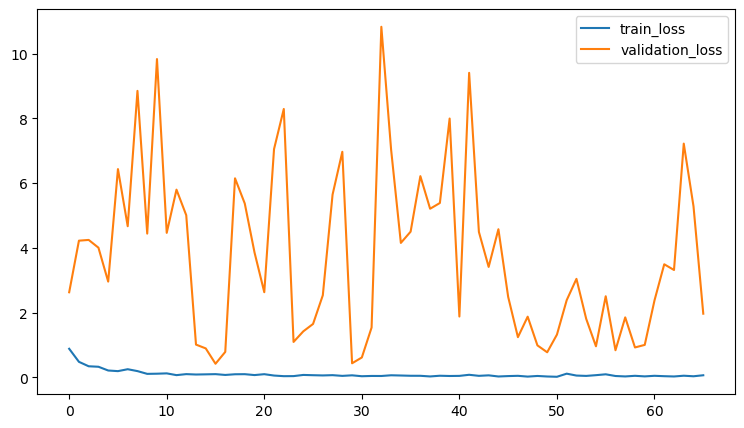

In [33]:
# plot the training history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss, label="validation_loss")
plt.legend()
plt.show()

In [34]:
# load the best model during the training
model = keras.models.load_model("cnn_entropy.keras", {
    "Conv1D_block": Conv1D_block,
})

In [35]:
results = model.evaluate(X_test, y_test)
print(f"testing loss: {results[0]}, testing accuracy: {results[1]}")

3/3 [==============================] - 0s 2ms/step - loss: 1.3412 - accuracy: 0.8082
testing loss: 1.3411729335784912, testing accuracy: 0.8082191944122314


In [36]:
# evaluate the model performance on training and testing data
train_pred = np.argmax(model.predict(X_train), axis=1)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(y_train, train_pred, target_names=target_names))
confusion_matrix(y_train, train_pred)

8/8 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

      Molino       0.99      0.99      0.99        83
      Pachon       1.00      0.90      0.95        83
     Surface       0.91      1.00      0.95        83

    accuracy                           0.96       249
   macro avg       0.97      0.96      0.96       249
weighted avg       0.97      0.96      0.96       249



array([[82,  0,  1],
       [ 1, 75,  7],
       [ 0,  0, 83]])

In [37]:
test_pred = np.argmax(model.predict(X_test), axis=1)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(y_test, test_pred, target_names=target_names))
confusion_matrix(y_test, test_pred)

3/3 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

      Molino       0.86      0.86      0.86        22
      Pachon       1.00      0.50      0.67        20
     Surface       0.73      0.97      0.83        31

    accuracy                           0.81        73
   macro avg       0.87      0.78      0.79        73
weighted avg       0.84      0.81      0.80        73



array([[19,  0,  3],
       [ 2, 10,  8],
       [ 1,  0, 30]])

In [39]:
def build_CNN(params):
    # build a CNN model
    input_d, output_d, kernel_size = params
    inputs = keras.Input(shape=(X_train.shape[1:]))
    conv1 = Conv1D_block(filters=4, kernel_size=kernel_size, pooling_size=2)
    x = conv1(inputs)
    conv2 = Conv1D_block(filters=8, kernel_size=kernel_size, pooling_size=2)
    x = conv2(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(output_d, activation="softmax")(x)
    cnn = keras.Model(inputs=inputs, outputs=outputs)
    
    # hyper params setting
    #lr = 0.01
    
    decay_steps = 800
    initial_learning_rate = 1e-2
    target_learning_rate = 1e-5
    
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps, alpha=target_learning_rate)
    
    optim = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
    cnn.compile(
        optimizer=optim,
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy'],
    )
    return cnn

args = [(275, 1), output_d, kernel_size]
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=70, verbose=1, restore_best_weights=True),
    #keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
]



model_f = build_CNN

# random sampling and train a new model
# to more accurately test our model performace indepedent of particular samples
# Similar to the idea of K-fold cross validation
predictors = list(df.drop(labels='class', axis=1).columns)  # names of the features
res = repeat_sampling_and_trainingNN(model_f, args, df,
                                  'class', predictors, num_repeat=100, doMinMaxScaling=False,
                                     data_processing_f=balanced_nested_design_sampling,
                                  is_oversample=True, oversample_f=SMOTE_oversample,
                                    train_f = trainTFNN, test_f = testTFNN, epochs=250,
                                    callbacks=callbacks)

Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9441 - accuracy: 0.6420 - val_loss: 8.6132 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3664 - accuracy: 0.9177 - val_loss: 21.5371 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2890 - accuracy: 0.9383 - val_loss: 31.2700 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2184 - accuracy: 0.9465 - val_loss: 30.4720 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1592 - accuracy: 0.9547 - val_loss: 24.2042 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2494 - accuracy: 0.8930 - val_loss: 33.8384 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1417 - accuracy: 0.9506 - val_loss: 26.3385 - val_accuracy: 0.3276
Epoch 8/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0337 - accuracy: 0.9877 - val_loss: 0.3857 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 0.9918 - val_loss: 0.2118 - val_accuracy: 0.8966
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0534 - accuracy: 0.9794 - val_loss: 0.1201 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0278 - accuracy: 0.9877 - val_loss: 0.1825 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - accuracy: 0.9959 - val_loss: 0.0222 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0367 - accuracy: 0.9877 - val_loss: 0.1894 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.1856 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0212 - accuracy: 0.9959 - val_loss: 0.1045 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0443 - accuracy: 0.9794 - val_loss: 0.1038 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0440 - accuracy: 0.9877 - val_loss: 0.1037 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0447 - accuracy: 0.9877 - val_loss: 0.1035 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.1042 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0634 - accuracy: 0.9671 - val_loss: 0.1056 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0211 - accuracy: 0.9918 - val_loss: 0.1057 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 1/250
9/9 [==============================] - 1s 21ms/step - loss: 0.6690 - accuracy: 0.7165 - val_loss: 166.2041 - val_accuracy: 0.2586
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3087 - accuracy: 0.8927 - val_loss: 134.3139 - val_accuracy: 0.2586
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2045 - accuracy: 0.9540 - val_loss: 143.3390 - val_accuracy: 0.2586
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2919 - accuracy: 0.8851 - val_loss: 137.7676 - val_accuracy: 0.2586
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1555 - accuracy: 0.9579 - val_loss: 40.5195 - val_accuracy: 0.2586
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2108 - accuracy: 0.9080 - val_loss: 126.4764 - val_accuracy: 0.2586
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1081 - accuracy: 0.9693 - val_loss: 118.3437 - val_accuracy: 0.2586
Epoch 8/250
9

9/9 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9962 - val_loss: 1.0945 - val_accuracy: 0.8276
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0498 - accuracy: 0.9732 - val_loss: 3.0134 - val_accuracy: 0.6724
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0445 - accuracy: 0.9732 - val_loss: 2.7418 - val_accuracy: 0.6897
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0496 - accuracy: 0.9732 - val_loss: 2.1753 - val_accuracy: 0.7241
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0401 - accuracy: 0.9847 - val_loss: 1.9868 - val_accuracy: 0.7241
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1500 - accuracy: 0.9540 - val_loss: 0.9575 - val_accuracy: 0.8621
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 0.9847 - val_loss: 0.8658 - val_accuracy: 0.8621
Epoch 66/250
9/9 [===============

9/9 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.1165 - val_accuracy: 0.9483
Epoch 118/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0481 - accuracy: 0.9808 - val_loss: 0.1164 - val_accuracy: 0.9483
Epoch 119/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0361 - accuracy: 0.9847 - val_loss: 0.1207 - val_accuracy: 0.9483
Epoch 120/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0912 - accuracy: 0.9847 - val_loss: 0.1187 - val_accuracy: 0.9483
Epoch 121/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0437 - accuracy: 0.9808 - val_loss: 0.1168 - val_accuracy: 0.9483
Epoch 122/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0987 - accuracy: 0.9617 - val_loss: 0.1222 - val_accuracy: 0.9483
Epoch 123/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0727 - accuracy: 0.9732 - val_loss: 0.1206 - val_accuracy: 0.9483
Epoch 124/250
9/9 [========

9/9 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.9923 - val_loss: 0.1454 - val_accuracy: 0.9310
Epoch 176/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0479 - accuracy: 0.9770 - val_loss: 0.1496 - val_accuracy: 0.9310
Epoch 177/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9847 - val_loss: 0.1445 - val_accuracy: 0.9310
Epoch 178/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.1453 - val_accuracy: 0.9310
Epoch 179/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0550 - accuracy: 0.9770 - val_loss: 0.1436 - val_accuracy: 0.9310
Epoch 180/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0406 - accuracy: 0.9885 - val_loss: 0.1381 - val_accuracy: 0.9310
Epoch 181/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0347 - accuracy: 0.9808 - val_loss: 0.1342 - val_accuracy: 0.9483
Epoch 182/250
9/9 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 20ms/step - loss: 0.7571 - accuracy: 0.6705 - val_loss: 64.1163 - val_accuracy: 0.3276
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.4046 - accuracy: 0.8429 - val_loss: 90.5243 - val_accuracy: 0.3276
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2534 - accuracy: 0.9157 - val_loss: 54.2819 - val_accuracy: 0.3276
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2384 - accuracy: 0.9387 - val_loss: 86.7738 - val_accuracy: 0.3276
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2492 - accuracy: 0.9080 - val_loss: 54.4528 - val_accuracy: 0.3276
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1882 - accuracy: 0.9425 - val_loss: 106.5552 - val_accuracy: 0.3276
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1266 - accuracy: 0.9655 - val_loss: 56.0212 - val_accuracy: 0.3276
Epoch 8/250
9/9 [=============

9/9 [==============================] - 0s 6ms/step - loss: 0.0291 - accuracy: 0.9847 - val_loss: 0.1235 - val_accuracy: 0.9655
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1465 - accuracy: 0.9655 - val_loss: 0.1757 - val_accuracy: 0.9483
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0612 - accuracy: 0.9732 - val_loss: 0.0836 - val_accuracy: 0.9655
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0353 - accuracy: 0.9770 - val_loss: 0.0863 - val_accuracy: 0.9655
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0675 - accuracy: 0.9847 - val_loss: 0.1250 - val_accuracy: 0.9483
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0381 - accuracy: 0.9808 - val_loss: 0.1206 - val_accuracy: 0.9483
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0481 - accuracy: 0.9693 - val_loss: 0.1348 - val_accuracy: 0.9483
Epoch 66/250
9/9 [===============

3/3 [==============================] - 0s 1ms/step
[[15  0  0]
 [ 0 28  0]
 [ 1  0 29]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 22ms/step - loss: 0.7636 - accuracy: 0.7046 - val_loss: 19.2545 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3890 - accuracy: 0.8861 - val_loss: 20.1970 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2756 - accuracy: 0.9198 - val_loss: 20.0856 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2184 - accuracy: 0.9283 - val_loss: 41.5717 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1766 - accuracy: 0.9578 - val_loss: 43.5889 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1495 - accuracy: 0.9494 - val_loss: 28.5404 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1525 - accuracy: 0.9367 - val_loss: 39.1300 - val_accuracy: 0.3276
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.9873 - val_loss: 0.2967 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0471 - accuracy: 0.9831 - val_loss: 1.1594 - val_accuracy: 0.7759
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.6154 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0173 - accuracy: 0.9958 - val_loss: 0.5522 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0251 - accuracy: 0.9831 - val_loss: 0.4791 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0381 - accuracy: 0.9873 - val_loss: 0.6131 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0576 - accuracy: 0.9873 - val_loss: 0.1741 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9916 - val_loss: 0.2110 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0598 - accuracy: 0.9662 - val_loss: 0.2091 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9831 - val_loss: 0.2090 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.9747 - val_loss: 0.2075 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0394 - accuracy: 0.9789 - val_loss: 0.2069 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0289 - accuracy: 0.9873 - val_loss: 0.2066 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0364 - accuracy: 0.9831 - val_loss: 0.2066 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 25ms/step - loss: 0.9583 - accuracy: 0.6042 - val_loss: 2.9452 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4698 - accuracy: 0.8208 - val_loss: 8.2333 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3111 - accuracy: 0.8958 - val_loss: 10.3936 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2704 - accuracy: 0.9083 - val_loss: 14.9379 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1666 - accuracy: 0.9667 - val_loss: 20.2530 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2013 - accuracy: 0.9167 - val_loss: 5.8492 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1778 - accuracy: 0.9250 - val_loss: 12.4911 - val_accuracy: 0.3793
Epoch 8/250
8/8 [=================

8/8 [==============================] - 0s 6ms/step - loss: 0.0519 - accuracy: 0.9833 - val_loss: 4.1167 - val_accuracy: 0.5517
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0363 - accuracy: 0.9792 - val_loss: 3.6460 - val_accuracy: 0.5690
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9875 - val_loss: 2.5112 - val_accuracy: 0.6034
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0328 - accuracy: 0.9875 - val_loss: 1.8576 - val_accuracy: 0.6379
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 0.9958 - val_loss: 1.2426 - val_accuracy: 0.7586
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0179 - accuracy: 0.9958 - val_loss: 0.5593 - val_accuracy: 0.8621
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0461 - accuracy: 0.9792 - val_loss: 0.2494 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0416 - accuracy: 0.9833 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9917 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0604 - accuracy: 0.9750 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0516 - accuracy: 0.9792 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0342 - accuracy: 0.9833 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0305 - accuracy: 0.9917 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 5.6657e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 124/250
8/8 [====

8/8 [==============================] - 0s 6ms/step - loss: 0.0245 - accuracy: 0.9917 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0312 - accuracy: 0.9875 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0151 - accuracy: 0.9958 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0211 - accuracy: 0.9958 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0379 - accuracy: 0.9917 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9875 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 0.9917 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9075 - accuracy: 0.6034 - val_loss: 1.1363 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4434 - accuracy: 0.8228 - val_loss: 3.3463 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3768 - accuracy: 0.8523 - val_loss: 11.4003 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2694 - accuracy: 0.9325 - val_loss: 26.1785 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1942 - accuracy: 0.9451 - val_loss: 30.8125 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1647 - accuracy: 0.9662 - val_loss: 46.5846 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1889 - accuracy: 0.9283 - val_loss: 44.3475 - val_accuracy: 0.3103
Epoch 8/250
8/8 [================

8/8 [==============================] - 0s 7ms/step - loss: 0.0281 - accuracy: 0.9873 - val_loss: 4.0827 - val_accuracy: 0.5690
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0726 - accuracy: 0.9789 - val_loss: 7.7693 - val_accuracy: 0.5172
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0268 - accuracy: 0.9873 - val_loss: 4.6559 - val_accuracy: 0.5862
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0510 - accuracy: 0.9831 - val_loss: 2.9296 - val_accuracy: 0.6379
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 0.9916 - val_loss: 2.2949 - val_accuracy: 0.7414
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0141 - accuracy: 0.9916 - val_loss: 2.2627 - val_accuracy: 0.7759
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0205 - accuracy: 0.9958 - val_loss: 1.7951 - val_accuracy: 0.7931
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9831 - val_loss: 0.1979 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9789 - val_loss: 0.1988 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0374 - accuracy: 0.9831 - val_loss: 0.1991 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0251 - accuracy: 0.9958 - val_loss: 0.2007 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.1998 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0139 - accuracy: 0.9873 - val_loss: 0.2005 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0556 - accuracy: 0.9873 - val_loss: 0.2007 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6873 - accuracy: 0.6878 - val_loss: 39.4577 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3495 - accuracy: 0.8650 - val_loss: 28.2271 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2630 - accuracy: 0.9072 - val_loss: 48.3805 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2040 - accuracy: 0.9409 - val_loss: 46.0503 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1552 - accuracy: 0.9451 - val_loss: 42.8720 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0980 - accuracy: 0.9789 - val_loss: 45.7453 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1396 - accuracy: 0.9494 - val_loss: 68.6990 - val_accuracy: 0.2586
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0365 - accuracy: 0.9916 - val_loss: 1.1446 - val_accuracy: 0.7586
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0308 - accuracy: 0.9916 - val_loss: 4.3536 - val_accuracy: 0.5172
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0415 - accuracy: 0.9831 - val_loss: 4.8419 - val_accuracy: 0.4828
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0203 - accuracy: 0.9958 - val_loss: 5.0003 - val_accuracy: 0.4828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0462 - accuracy: 0.9747 - val_loss: 8.5736 - val_accuracy: 0.4483
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0329 - accuracy: 0.9916 - val_loss: 12.2429 - val_accuracy: 0.4483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0274 - accuracy: 0.9916 - val_loss: 0.1159 - val_accuracy: 0.9483
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0451 - accuracy: 0.9789 - val_loss: 0.0839 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0150 - accuracy: 0.9958 - val_loss: 0.0831 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0281 - accuracy: 0.9916 - val_loss: 0.0827 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0489 - accuracy: 0.9789 - val_loss: 0.0824 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9916 - val_loss: 0.0818 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0364 - accuracy: 0.9831 - val_loss: 0.0825 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0484 - accuracy: 0.9747 - val_loss: 0.0837 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7340 - accuracy: 0.6749 - val_loss: 23.2230 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3538 - accuracy: 0.8971 - val_loss: 45.8588 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2418 - accuracy: 0.9424 - val_loss: 69.1459 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1886 - accuracy: 0.9630 - val_loss: 58.9325 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1372 - accuracy: 0.9547 - val_loss: 50.4971 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0983 - accuracy: 0.9712 - val_loss: 61.4653 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0810 - accuracy: 0.9671 - val_loss: 53.8670 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9835 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0117 - accuracy: 0.9959 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.9835 - val_loss: 0.0210 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0302 - accuracy: 0.9835 - val_loss: 0.0549 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0330 - accuracy: 0.9835 - val_loss: 0.0676 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0201 - accuracy: 0.9877 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0207 - accuracy: 0.9835 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 66/250
8/8 [===============

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6849 - accuracy: 0.7317 - val_loss: 47.1162 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3390 - accuracy: 0.8943 - val_loss: 29.9989 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2402 - accuracy: 0.9350 - val_loss: 45.1444 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2205 - accuracy: 0.9431 - val_loss: 38.6813 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1355 - accuracy: 0.9634 - val_loss: 52.8488 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1026 - accuracy: 0.9837 - val_loss: 39.5460 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1163 - accuracy: 0.9593 - val_loss: 59.6222 - val_accuracy: 0.3276
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0153 - accuracy: 0.9959 - val_loss: 0.2853 - val_accuracy: 0.9138
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0265 - accuracy: 0.9878 - val_loss: 0.3790 - val_accuracy: 0.9138
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0268 - accuracy: 0.9919 - val_loss: 0.2831 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0513 - accuracy: 0.9756 - val_loss: 0.1077 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0371 - accuracy: 0.9878 - val_loss: 0.1734 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0386 - accuracy: 0.9837 - val_loss: 0.3953 - val_accuracy: 0.8448
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0623 - accuracy: 0.9675 - val_loss: 0.4633 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9959 - val_loss: 0.2384 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0262 - accuracy: 0.9919 - val_loss: 0.2384 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.2384 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0290 - accuracy: 0.9878 - val_loss: 0.2385 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9878 - val_loss: 0.2387 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0271 - accuracy: 0.9959 - val_loss: 0.2383 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0349 - accuracy: 0.9837 - val_loss: 0.2392 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7266 - accuracy: 0.7114 - val_loss: 42.0539 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3685 - accuracy: 0.8740 - val_loss: 55.4289 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3053 - accuracy: 0.8740 - val_loss: 47.0567 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2256 - accuracy: 0.9106 - val_loss: 54.8789 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2045 - accuracy: 0.9350 - val_loss: 60.6905 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1706 - accuracy: 0.9472 - val_loss: 80.7776 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1033 - accuracy: 0.9797 - val_loss: 82.5419 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9919 - val_loss: 0.2617 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 0.9878 - val_loss: 0.2310 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 0.9797 - val_loss: 0.3529 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9837 - val_loss: 0.8670 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9919 - val_loss: 0.3803 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9919 - val_loss: 0.1156 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0237 - accuracy: 0.9878 - val_loss: 0.5039 - val_accuracy: 0.8103
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0296 - accuracy: 0.9878 - val_loss: 0.0963 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0231 - accuracy: 0.9919 - val_loss: 0.0960 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.9837 - val_loss: 0.0959 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0268 - accuracy: 0.9837 - val_loss: 0.0956 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0310 - accuracy: 0.9837 - val_loss: 0.0956 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9878 - val_loss: 0.0954 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0291 - accuracy: 0.9878 - val_loss: 0.0948 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0207 - accuracy: 0.9919 - val_loss: 0.0930 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.0928 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0396 - accuracy: 0.9837 - val_loss: 0.0926 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0333 - accuracy: 0.9797 - val_loss: 0.0924 - val_accuracy: 0.9828
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 0.9959 - val_loss: 0.0926 - val_accuracy: 0.9828
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0288 - accuracy: 0.9837 - val_loss: 0.0929 - val_accuracy: 0.9828
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0268 - accuracy: 0.9837 - val_loss: 0.0923 - val_accuracy: 0.9828
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0373 - accuracy: 0.9837 - val_loss: 0.0943 - val_accuracy: 0.9828
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0377 - accuracy: 0.9797 - val_loss: 0.0943 - val_accuracy: 0.9828
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 0.9797 - val_loss: 0.0942 - val_accuracy: 0.9828
Epoch 236/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0629 - accuracy: 0.9756 - val_loss: 0.0942 - val_accuracy: 0.9828
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0727 - accuracy: 0.9715 - val_loss: 0.0941 - val_accuracy: 0.9828
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0205 - accuracy: 0.9959 - val_loss: 0.0942 - val_accuracy: 0.9828
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0395 - accuracy: 0.9797 - val_loss: 0.0942 - val_accuracy: 0.9828
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8684 - accuracy: 0.6667 - val_loss: 17.6371 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3526 - accuracy: 0.8724 - val_loss: 22.7841 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2730 - accuracy: 0.9177 - val_loss: 22.4092 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2470 - accuracy: 0.9095 - val_loss: 23.9371 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1967 - accuracy: 0.9506 - val_loss: 32.1534 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1431 - accuracy: 0.9630 - val_loss: 27.2980 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1394 - accuracy: 0.9630 - val_loss: 25.8480 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0538 - accuracy: 0.9794 - val_loss: 0.2874 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 0.9918 - val_loss: 0.2162 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0309 - accuracy: 0.9918 - val_loss: 0.9042 - val_accuracy: 0.8448
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0505 - accuracy: 0.9918 - val_loss: 7.1251 - val_accuracy: 0.3621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.9877 - val_loss: 5.8150 - val_accuracy: 0.3966
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0297 - accuracy: 0.9918 - val_loss: 0.8275 - val_accuracy: 0.8621
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0438 - accuracy: 0.9877 - val_loss: 0.6516 - val_accuracy: 0.8966
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 0.3318 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9959 - val_loss: 0.3313 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.3324 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0365 - accuracy: 0.9918 - val_loss: 0.3326 - val_accuracy: 0.9483
Epoch 120: early stopping
3/3 [==============================] - 0s 1ms/step
[[29  0  0]
 [ 0 28  0]
 [ 0  1 15]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8124 - accuracy: 0.6586 - val_loss: 26.7680 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3715 - accuracy: 0.8635 - val_loss: 30.9628 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2735 - accuracy: 0.9357 - val_loss: 33.7863 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2198 - accuracy: 0.9317 - val_loss: 32.4285 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1420 - accuracy: 0.9799 - val_loss: 35.6758 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2180 - accuracy: 0.9157 - val_loss: 41.2566 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1098 - accuracy: 0.9558 - val_loss: 44.2539 - val_accuracy: 0.3966
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0461 - accuracy: 0.9799 - val_loss: 0.0429 - val_accuracy: 0.9828
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0311 - accuracy: 0.9880 - val_loss: 0.5110 - val_accuracy: 0.8966
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.5026 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0687 - accuracy: 0.9679 - val_loss: 0.4668 - val_accuracy: 0.8966
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0308 - accuracy: 0.9920 - val_loss: 4.3108 - val_accuracy: 0.6379
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0462 - accuracy: 0.9799 - val_loss: 3.5673 - val_accuracy: 0.6724
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0342 - accuracy: 0.9920 - val_loss: 4.2557 - val_accuracy: 0.6034
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0458 - accuracy: 0.9759 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0089 - accuracy: 0.9960 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0276 - accuracy: 0.9920 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0464 - accuracy: 0.9839 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0366 - accuracy: 0.9920 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0247 - accuracy: 0.9880 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0286 - accuracy: 0.9880 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 1/250
8/8 [==============================] - 1s 23ms/step - loss: 0.8611 - accuracy: 0.5958 - val_loss: 1.1989 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3772 - accuracy: 0.8417 - val_loss: 1.1430 - val_accuracy: 0.4828
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3385 - accuracy: 0.8750 - val_loss: 1.6127 - val_accuracy: 0.4828
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2928 - accuracy: 0.9125 - val_loss: 3.4343 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1993 - accuracy: 0.9500 - val_loss: 3.3407 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1875 - accuracy: 0.9375 - val_loss: 3.4865 - val_accuracy: 0.5172
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1731 - accuracy: 0.9250 - val_loss: 5.8949 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=========

8/8 [==============================] - 0s 6ms/step - loss: 0.0340 - accuracy: 0.9875 - val_loss: 1.1106 - val_accuracy: 0.7241
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0629 - accuracy: 0.9708 - val_loss: 0.2356 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0175 - accuracy: 0.9875 - val_loss: 0.2277 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0318 - accuracy: 0.9833 - val_loss: 0.2459 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0384 - accuracy: 0.9792 - val_loss: 0.1922 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9833 - val_loss: 0.1984 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9792 - val_loss: 0.1696 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0355 - accuracy: 0.9792 - val_loss: 0.0942 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0303 - accuracy: 0.9875 - val_loss: 0.0941 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0532 - accuracy: 0.9792 - val_loss: 0.0946 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0244 - accuracy: 0.9917 - val_loss: 0.0948 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0196 - accuracy: 0.9917 - val_loss: 0.0939 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0235 - accuracy: 0.9875 - val_loss: 0.0946 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9917 - val_loss: 0.0938 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8205 - accuracy: 0.6466 - val_loss: 20.3806 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4348 - accuracy: 0.8554 - val_loss: 25.1070 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2590 - accuracy: 0.9398 - val_loss: 33.6011 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1925 - accuracy: 0.9357 - val_loss: 43.0043 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1876 - accuracy: 0.9357 - val_loss: 56.2606 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1324 - accuracy: 0.9759 - val_loss: 82.9714 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0974 - accuracy: 0.9719 - val_loss: 78.1124 - val_accuracy: 0.3966
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9920 - val_loss: 0.7176 - val_accuracy: 0.8621
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 1.3979 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0238 - accuracy: 0.9920 - val_loss: 0.2540 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0388 - accuracy: 0.9880 - val_loss: 0.1609 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 0.9920 - val_loss: 0.1871 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9920 - val_loss: 0.2730 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0298 - accuracy: 0.9880 - val_loss: 0.6847 - val_accuracy: 0.9138
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0449 - accuracy: 0.9759 - val_loss: 0.1772 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0223 - accuracy: 0.9880 - val_loss: 0.1779 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 0.9920 - val_loss: 0.1788 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0335 - accuracy: 0.9839 - val_loss: 0.1796 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.1801 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0291 - accuracy: 0.9880 - val_loss: 0.1805 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.9920 - val_loss: 0.1809 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7735 - accuracy: 0.6458 - val_loss: 44.3819 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4107 - accuracy: 0.8333 - val_loss: 72.6051 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2936 - accuracy: 0.8917 - val_loss: 70.0413 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2482 - accuracy: 0.9208 - val_loss: 64.5636 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1935 - accuracy: 0.9375 - val_loss: 56.1329 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1835 - accuracy: 0.9292 - val_loss: 64.3661 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1510 - accuracy: 0.9458 - val_loss: 40.8663 - val_accuracy: 0.3448
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0397 - accuracy: 0.9708 - val_loss: 3.9706 - val_accuracy: 0.5172
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0266 - accuracy: 0.9875 - val_loss: 8.8792 - val_accuracy: 0.3621
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0582 - accuracy: 0.9708 - val_loss: 1.2618 - val_accuracy: 0.8276
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0413 - accuracy: 0.9792 - val_loss: 1.1186 - val_accuracy: 0.8276
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0360 - accuracy: 0.9792 - val_loss: 1.1099 - val_accuracy: 0.8276
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9875 - val_loss: 1.0003 - val_accuracy: 0.8276
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0218 - accuracy: 0.9833 - val_loss: 0.2623 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0127 - accuracy: 0.9917 - val_loss: 0.0430 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0333 - accuracy: 0.9750 - val_loss: 0.0431 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - accuracy: 0.9875 - val_loss: 0.0433 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0471 - accuracy: 0.9708 - val_loss: 0.0436 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0349 - accuracy: 0.9750 - val_loss: 0.0436 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - accuracy: 0.9917 - val_loss: 0.0433 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7526 - accuracy: 0.6706 - val_loss: 56.2639 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3966 - accuracy: 0.8667 - val_loss: 55.5858 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2517 - accuracy: 0.9176 - val_loss: 72.5615 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2361 - accuracy: 0.9333 - val_loss: 59.2680 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2242 - accuracy: 0.9216 - val_loss: 79.1931 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1891 - accuracy: 0.9569 - val_loss: 80.6728 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0931 - accuracy: 0.9882 - val_loss: 62.3449 - val_accuracy: 0.3276
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 0.9843 - val_loss: 1.1876 - val_accuracy: 0.8621
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0325 - accuracy: 0.9882 - val_loss: 2.0125 - val_accuracy: 0.7931
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0349 - accuracy: 0.9882 - val_loss: 5.5144 - val_accuracy: 0.5000
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9882 - val_loss: 2.1722 - val_accuracy: 0.7069
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 1.2722 - val_accuracy: 0.8103
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9922 - val_loss: 0.7638 - val_accuracy: 0.8621
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0355 - accuracy: 0.9922 - val_loss: 2.9622 - val_accuracy: 0.6207
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0268 - accuracy: 0.9922 - val_loss: 0.0440 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0286 - accuracy: 0.9922 - val_loss: 0.0444 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9882 - val_loss: 0.0444 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0275 - accuracy: 0.9882 - val_loss: 0.0444 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0422 - accuracy: 0.9804 - val_loss: 0.0446 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0173 - accuracy: 0.9922 - val_loss: 0.0446 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9218 - accuracy: 0.5595 - val_loss: 13.0800 - val_accuracy: 0.2069
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4737 - accuracy: 0.8333 - val_loss: 25.2970 - val_accuracy: 0.2069
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3056 - accuracy: 0.9087 - val_loss: 36.5273 - val_accuracy: 0.2069
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2472 - accuracy: 0.9405 - val_loss: 40.3484 - val_accuracy: 0.2069
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1778 - accuracy: 0.9365 - val_loss: 50.9887 - val_accuracy: 0.2069
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1565 - accuracy: 0.9484 - val_loss: 36.0626 - val_accuracy: 0.2069
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1412 - accuracy: 0.9563 - val_loss: 21.8468 - val_accuracy: 0.2069
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9802 - val_loss: 3.1425 - val_accuracy: 0.7241
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9881 - val_loss: 1.1161 - val_accuracy: 0.8276
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9762 - val_loss: 2.5341 - val_accuracy: 0.7241
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0337 - accuracy: 0.9762 - val_loss: 2.2067 - val_accuracy: 0.7586
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9762 - val_loss: 2.5273 - val_accuracy: 0.7586
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0354 - accuracy: 0.9762 - val_loss: 1.9907 - val_accuracy: 0.8103
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0321 - accuracy: 0.9841 - val_loss: 2.5773 - val_accuracy: 0.7586
Epoch 66/250
8/8 [===============

Epoch 116: early stopping
3/3 [==============================] - 0s 1ms/step
[[22  3  0]
 [ 1 22  0]
 [ 0  3 22]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 20ms/step - loss: 0.7097 - accuracy: 0.6744 - val_loss: 31.3619 - val_accuracy: 0.3276
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3748 - accuracy: 0.8605 - val_loss: 42.7045 - val_accuracy: 0.3276
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3285 - accuracy: 0.8953 - val_loss: 33.0254 - val_accuracy: 0.3276
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2341 - accuracy: 0.9419 - val_loss: 34.3133 - val_accuracy: 0.3276
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2505 - accuracy: 0.9302 - val_loss: 24.3239 - val_accuracy: 0.3276
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1696 - accuracy: 0.9535 - val_loss: 43.0354 - val_accuracy: 0.3276
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1697 - accuracy: 0.9535 - val_loss: 26.5036 - val_accuracy: 0.3276
Epoch 8/250
9/9 [==============

9/9 [==============================] - 0s 6ms/step - loss: 0.0798 - accuracy: 0.9806 - val_loss: 2.3397 - val_accuracy: 0.4828
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0871 - accuracy: 0.9845 - val_loss: 1.4323 - val_accuracy: 0.6207
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0382 - accuracy: 0.9922 - val_loss: 3.6559 - val_accuracy: 0.4655
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0619 - accuracy: 0.9767 - val_loss: 2.1762 - val_accuracy: 0.5172
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0917 - accuracy: 0.9729 - val_loss: 0.5208 - val_accuracy: 0.8103
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0398 - accuracy: 0.9884 - val_loss: 0.2855 - val_accuracy: 0.9138
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0831 - accuracy: 0.9806 - val_loss: 0.6048 - val_accuracy: 0.8276
Epoch 66/250
9/9 [===============

9/9 [==============================] - 0s 6ms/step - loss: 0.0365 - accuracy: 0.9922 - val_loss: 0.1333 - val_accuracy: 0.9655
Epoch 118/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0880 - accuracy: 0.9884 - val_loss: 0.1343 - val_accuracy: 0.9655
Epoch 119/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0973 - accuracy: 0.9961 - val_loss: 0.1390 - val_accuracy: 0.9655
Epoch 120/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0466 - accuracy: 0.9884 - val_loss: 0.1356 - val_accuracy: 0.9655
Epoch 121/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9884 - val_loss: 0.1369 - val_accuracy: 0.9655
Epoch 122/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0679 - accuracy: 0.9806 - val_loss: 0.1417 - val_accuracy: 0.9655
Epoch 123/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0459 - accuracy: 0.9845 - val_loss: 0.1379 - val_accuracy: 0.9655
Epoch 124/250
9/9 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 22ms/step - loss: 0.7526 - accuracy: 0.7033 - val_loss: 8.7293 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3338 - accuracy: 0.8862 - val_loss: 11.9893 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2481 - accuracy: 0.9146 - val_loss: 18.6989 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1927 - accuracy: 0.9593 - val_loss: 17.8939 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1148 - accuracy: 0.9715 - val_loss: 22.6698 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1254 - accuracy: 0.9593 - val_loss: 24.3185 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2060 - accuracy: 0.9390 - val_loss: 9.4761 - val_accuracy: 0.3621
Epoch 8/250
8/8 [================

8/8 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.9797 - val_loss: 1.6281 - val_accuracy: 0.7931
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0285 - accuracy: 0.9837 - val_loss: 1.0024 - val_accuracy: 0.8448
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9797 - val_loss: 0.6779 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0371 - accuracy: 0.9837 - val_loss: 0.5398 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9837 - val_loss: 0.3074 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0302 - accuracy: 0.9837 - val_loss: 0.2432 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0537 - accuracy: 0.9675 - val_loss: 0.4915 - val_accuracy: 0.8966
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0260 - accuracy: 0.9837 - val_loss: 0.0992 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0280 - accuracy: 0.9837 - val_loss: 0.0981 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0222 - accuracy: 0.9837 - val_loss: 0.0975 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9797 - val_loss: 0.0965 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0348 - accuracy: 0.9756 - val_loss: 0.0958 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0377 - accuracy: 0.9797 - val_loss: 0.0950 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0419 - accuracy: 0.9797 - val_loss: 0.0956 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7606 - accuracy: 0.6586 - val_loss: 4.9297 - val_accuracy: 0.2414
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4024 - accuracy: 0.8353 - val_loss: 1.3546 - val_accuracy: 0.2414
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3253 - accuracy: 0.8715 - val_loss: 2.8847 - val_accuracy: 0.2414
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2586 - accuracy: 0.9157 - val_loss: 1.2934 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1998 - accuracy: 0.9277 - val_loss: 1.3958 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2029 - accuracy: 0.9438 - val_loss: 1.3515 - val_accuracy: 0.4310
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1590 - accuracy: 0.9438 - val_loss: 5.2631 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0270 - accuracy: 0.9839 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.9719 - val_loss: 0.0478 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0519 - accuracy: 0.9679 - val_loss: 0.0420 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9880 - val_loss: 0.1265 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9839 - val_loss: 0.3928 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0297 - accuracy: 0.9839 - val_loss: 0.2231 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9799 - val_loss: 0.6681 - val_accuracy: 0.8966
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0452 - accuracy: 0.9759 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0319 - accuracy: 0.9799 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0352 - accuracy: 0.9799 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0328 - accuracy: 0.9839 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0449 - accuracy: 0.9719 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0325 - accuracy: 0.9920 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0405 - accuracy: 0.9759 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0433 - accuracy: 0.5274 - val_loss: 3.1083 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3819 - accuracy: 0.8650 - val_loss: 8.1575 - val_accuracy: 0.2241
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3294 - accuracy: 0.8945 - val_loss: 17.7289 - val_accuracy: 0.2241
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2305 - accuracy: 0.9241 - val_loss: 17.4017 - val_accuracy: 0.2241
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2523 - accuracy: 0.9241 - val_loss: 29.5033 - val_accuracy: 0.2241
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1788 - accuracy: 0.9367 - val_loss: 16.2177 - val_accuracy: 0.2241
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1523 - accuracy: 0.9409 - val_loss: 30.2767 - val_accuracy: 0.2241
Epoch 8/250
8/8 [================

8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9831 - val_loss: 0.5382 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 0.9958 - val_loss: 1.0495 - val_accuracy: 0.8448
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9873 - val_loss: 1.0309 - val_accuracy: 0.8448
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0399 - accuracy: 0.9916 - val_loss: 1.7645 - val_accuracy: 0.8276
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.9873 - val_loss: 0.7848 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0378 - accuracy: 0.9873 - val_loss: 1.0765 - val_accuracy: 0.8621
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9831 - val_loss: 1.0911 - val_accuracy: 0.8621
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0218 - accuracy: 0.9958 - val_loss: 0.2123 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0240 - accuracy: 0.9873 - val_loss: 0.2118 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0330 - accuracy: 0.9873 - val_loss: 0.2137 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0342 - accuracy: 0.9873 - val_loss: 0.2139 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.2143 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0297 - accuracy: 0.9916 - val_loss: 0.2174 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0495 - accuracy: 0.9747 - val_loss: 0.2161 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7352 - accuracy: 0.6787 - val_loss: 37.5581 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3559 - accuracy: 0.9157 - val_loss: 55.8855 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2820 - accuracy: 0.9157 - val_loss: 78.3912 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1778 - accuracy: 0.9438 - val_loss: 65.3130 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1587 - accuracy: 0.9759 - val_loss: 59.1121 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1120 - accuracy: 0.9839 - val_loss: 88.4001 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0951 - accuracy: 0.9679 - val_loss: 54.3718 - val_accuracy: 0.3793
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9920 - val_loss: 1.4107 - val_accuracy: 0.8621
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0405 - accuracy: 0.9880 - val_loss: 1.1115 - val_accuracy: 0.8793
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0265 - accuracy: 0.9799 - val_loss: 0.5868 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0097 - accuracy: 0.9920 - val_loss: 0.5925 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 0.9920 - val_loss: 0.3290 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 0.9799 - val_loss: 1.0435 - val_accuracy: 0.8966
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0158 - accuracy: 0.9920 - val_loss: 0.8584 - val_accuracy: 0.8966
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.1058 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 0.9839 - val_loss: 0.1058 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0539 - accuracy: 0.9759 - val_loss: 0.1057 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0153 - accuracy: 0.9920 - val_loss: 0.1057 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1017 - accuracy: 0.9639 - val_loss: 0.1057 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9759 - val_loss: 0.1057 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.1057 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7473 - accuracy: 0.6747 - val_loss: 34.7271 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3835 - accuracy: 0.8876 - val_loss: 58.3814 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2272 - accuracy: 0.9478 - val_loss: 52.7013 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1885 - accuracy: 0.9598 - val_loss: 58.4849 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1543 - accuracy: 0.9679 - val_loss: 69.0157 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1340 - accuracy: 0.9639 - val_loss: 86.3014 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1301 - accuracy: 0.9639 - val_loss: 98.9833 - val_accuracy: 0.2931
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0316 - accuracy: 0.9880 - val_loss: 0.3733 - val_accuracy: 0.9310
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0365 - accuracy: 0.9759 - val_loss: 0.4934 - val_accuracy: 0.9138
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9839 - val_loss: 0.3085 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0346 - accuracy: 0.9880 - val_loss: 0.0791 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.1221 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9799 - val_loss: 0.0938 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0392 - accuracy: 0.9839 - val_loss: 9.1365e-04 - val_accuracy: 1.0000
Epoch 66/250
8/8 [===========

8/8 [==============================] - 0s 7ms/step - loss: 0.0213 - accuracy: 0.9880 - val_loss: 5.5515e-04 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.9839 - val_loss: 5.5816e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9759 - val_loss: 5.5869e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0461 - accuracy: 0.9719 - val_loss: 5.5523e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.9880 - val_loss: 5.5162e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0244 - accuracy: 0.9880 - val_loss: 5.4953e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0403 - accuracy: 0.9759 - val_loss: 5.4830e-04 - val_accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0204 - accuracy: 0.9880 - val_loss: 5.6671e-04 - val_accuracy: 1.0000
Epoch 173/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9839 - val_loss: 5.5745e-04 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9839 - val_loss: 5.5378e-04 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0220 - accuracy: 0.9839 - val_loss: 5.5532e-04 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9920 - val_loss: 5.5365e-04 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9839 - val_loss: 5.5483e-04 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9839 - val_loss: 5.5076e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8069 - accuracy: 0.6220 - val_loss: 1.0635 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4806 - accuracy: 0.8049 - val_loss: 1.0873 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3871 - accuracy: 0.8659 - val_loss: 1.8177 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2756 - accuracy: 0.9309 - val_loss: 2.4068 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2506 - accuracy: 0.9472 - val_loss: 7.1159 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1754 - accuracy: 0.9675 - val_loss: 7.9255 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1484 - accuracy: 0.9553 - val_loss: 19.9372 - val_accuracy: 0.2931
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9919 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9919 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9837 - val_loss: 3.5118 - val_accuracy: 0.6379
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0438 - accuracy: 0.9756 - val_loss: 3.0196 - val_accuracy: 0.6724
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0330 - accuracy: 0.9837 - val_loss: 2.2846 - val_accuracy: 0.7069
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0155 - accuracy: 0.9959 - val_loss: 2.4836 - val_accuracy: 0.6724
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0116 - accuracy: 0.9959 - val_loss: 0.0713 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0291 - accuracy: 0.9878 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.9919 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0231 - accuracy: 0.9919 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0364 - accuracy: 0.9878 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0523 - accuracy: 0.9715 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9052 - accuracy: 0.6000 - val_loss: 35.6848 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4236 - accuracy: 0.8588 - val_loss: 45.7381 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3235 - accuracy: 0.8745 - val_loss: 50.2686 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1897 - accuracy: 0.9451 - val_loss: 44.4457 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2051 - accuracy: 0.9176 - val_loss: 42.2462 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1293 - accuracy: 0.9725 - val_loss: 52.8693 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1399 - accuracy: 0.9608 - val_loss: 42.6864 - val_accuracy: 0.2586
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0376 - accuracy: 0.9882 - val_loss: 16.7375 - val_accuracy: 0.2586
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0563 - accuracy: 0.9804 - val_loss: 2.2796 - val_accuracy: 0.7414
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0432 - accuracy: 0.9882 - val_loss: 7.4570 - val_accuracy: 0.3448
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0252 - accuracy: 0.9961 - val_loss: 4.3812 - val_accuracy: 0.5172
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0289 - accuracy: 0.9922 - val_loss: 4.5305 - val_accuracy: 0.4828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9843 - val_loss: 4.6697 - val_accuracy: 0.4828
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0372 - accuracy: 0.9922 - val_loss: 10.0602 - val_accuracy: 0.3103
Epoch 66/250
8/8 [=============

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8125 - accuracy: 0.6375 - val_loss: 25.2685 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4058 - accuracy: 0.8625 - val_loss: 30.0575 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2908 - accuracy: 0.9042 - val_loss: 31.7736 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2331 - accuracy: 0.9375 - val_loss: 29.8711 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1859 - accuracy: 0.9417 - val_loss: 31.4671 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1767 - accuracy: 0.9333 - val_loss: 19.1835 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1228 - accuracy: 0.9583 - val_loss: 45.7753 - val_accuracy: 0.3276
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0215 - accuracy: 0.9917 - val_loss: 2.8917 - val_accuracy: 0.5690
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 0.9875 - val_loss: 2.0907 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0715 - accuracy: 0.9708 - val_loss: 1.8800 - val_accuracy: 0.7069
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0229 - accuracy: 0.9917 - val_loss: 1.4832 - val_accuracy: 0.7931
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.3735 - val_accuracy: 0.8793
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0291 - accuracy: 0.9917 - val_loss: 0.3875 - val_accuracy: 0.8793
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0310 - accuracy: 0.9917 - val_loss: 1.2028 - val_accuracy: 0.8103
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0542 - accuracy: 0.9750 - val_loss: 0.0252 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0451 - accuracy: 0.9792 - val_loss: 0.0255 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0213 - accuracy: 0.9917 - val_loss: 0.0255 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0409 - accuracy: 0.9875 - val_loss: 0.0253 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0421 - accuracy: 0.9875 - val_loss: 0.0252 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 0.9958 - val_loss: 0.0251 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8674 - accuracy: 0.6083 - val_loss: 3.8511 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3925 - accuracy: 0.8667 - val_loss: 3.8711 - val_accuracy: 0.5172
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3251 - accuracy: 0.8875 - val_loss: 5.2257 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2335 - accuracy: 0.9208 - val_loss: 5.3602 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2126 - accuracy: 0.9208 - val_loss: 3.6676 - val_accuracy: 0.4828
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1355 - accuracy: 0.9625 - val_loss: 6.5090 - val_accuracy: 0.6034
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1431 - accuracy: 0.9625 - val_loss: 13.2458 - val_accuracy: 0.3103
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0205 - accuracy: 0.9917 - val_loss: 0.3036 - val_accuracy: 0.9310
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9875 - val_loss: 0.2879 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9875 - val_loss: 0.2984 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0541 - accuracy: 0.9708 - val_loss: 1.4945 - val_accuracy: 0.7586
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9833 - val_loss: 2.4995 - val_accuracy: 0.7241
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0330 - accuracy: 0.9833 - val_loss: 1.7546 - val_accuracy: 0.7241
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0288 - accuracy: 0.9833 - val_loss: 0.8148 - val_accuracy: 0.8276
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9833 - val_loss: 0.2449 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9833 - val_loss: 0.2444 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9833 - val_loss: 0.2441 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9875 - val_loss: 0.2443 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 0.9750 - val_loss: 0.2438 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9833 - val_loss: 0.2437 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - accuracy: 0.9917 - val_loss: 0.2434 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0096 - accuracy: 0.9917 - val_loss: 0.2421 - val_accuracy: 0.9655
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0262 - accuracy: 0.9792 - val_loss: 0.2423 - val_accuracy: 0.9655
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0199 - accuracy: 0.9833 - val_loss: 0.2422 - val_accuracy: 0.9655
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0254 - accuracy: 0.9833 - val_loss: 0.2419 - val_accuracy: 0.9655
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0342 - accuracy: 0.9833 - val_loss: 0.2418 - val_accuracy: 0.9655
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9792 - val_loss: 0.2417 - val_accuracy: 0.9655
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0247 - accuracy: 0.9917 - val_loss: 0.2418 - val_accuracy: 0.9655
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0341 - accuracy: 0.9750 - val_loss: 0.2410 - val_accuracy: 0.9655
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0146 - accuracy: 0.9875 - val_loss: 0.2409 - val_accuracy: 0.9655
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0191 - accuracy: 0.9875 - val_loss: 0.2410 - val_accuracy: 0.9655
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0363 - accuracy: 0.9750 - val_loss: 0.2409 - val_accuracy: 0.9655
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0413 - accuracy: 0.9750 - val_loss: 0.2409 - val_accuracy: 0.9655
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.9750 - val_loss: 0.2411 - val_accuracy: 0.9655
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0312 - accuracy: 0.9875 - val_loss: 0.2410 - val_accuracy: 0.9655
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 20ms/step - loss: 0.8666 - accuracy: 0.6513 - val_loss: 7.6111 - val_accuracy: 0.2931
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.4438 - accuracy: 0.8582 - val_loss: 14.1548 - val_accuracy: 0.2931
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2940 - accuracy: 0.9195 - val_loss: 14.6574 - val_accuracy: 0.2931
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2661 - accuracy: 0.9272 - val_loss: 29.8659 - val_accuracy: 0.2931
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2168 - accuracy: 0.9234 - val_loss: 41.9861 - val_accuracy: 0.2931
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1840 - accuracy: 0.9540 - val_loss: 47.7829 - val_accuracy: 0.2931
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1809 - accuracy: 0.9579 - val_loss: 30.2766 - val_accuracy: 0.2931
Epoch 8/250
9/9 [===============

9/9 [==============================] - 0s 6ms/step - loss: 0.1201 - accuracy: 0.9847 - val_loss: 0.1604 - val_accuracy: 0.9483
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0398 - accuracy: 0.9923 - val_loss: 0.1815 - val_accuracy: 0.9483
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0962 - accuracy: 0.9847 - val_loss: 0.1856 - val_accuracy: 0.9483
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.9483
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0406 - accuracy: 0.9885 - val_loss: 0.1282 - val_accuracy: 0.9483
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0766 - accuracy: 0.9732 - val_loss: 0.1030 - val_accuracy: 0.9483
Epoch 65/250
9/9 [==============================] - 0s 7ms/step - loss: 0.0421 - accuracy: 0.9923 - val_loss: 0.0869 - val_accuracy: 0.9483
Epoch 66/250
9/9 [===============

9/9 [==============================] - 0s 6ms/step - loss: 0.0427 - accuracy: 0.9885 - val_loss: 0.0700 - val_accuracy: 0.9483
Epoch 118/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0608 - accuracy: 0.9847 - val_loss: 0.0712 - val_accuracy: 0.9655
Epoch 119/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0329 - accuracy: 0.9923 - val_loss: 0.0704 - val_accuracy: 0.9483
Epoch 120/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0622 - accuracy: 0.9770 - val_loss: 0.0699 - val_accuracy: 0.9483
Epoch 121/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9923 - val_loss: 0.0702 - val_accuracy: 0.9483
Epoch 122/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9962 - val_loss: 0.0703 - val_accuracy: 0.9483
Epoch 123/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0682 - accuracy: 0.9770 - val_loss: 0.0718 - val_accuracy: 0.9655
Epoch 124/250
9/9 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 47ms/step - loss: 0.8263 - accuracy: 0.6793 - val_loss: 63.6209 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3816 - accuracy: 0.8945 - val_loss: 74.6276 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3474 - accuracy: 0.8608 - val_loss: 62.1615 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2472 - accuracy: 0.9325 - val_loss: 74.2429 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1965 - accuracy: 0.9325 - val_loss: 69.7335 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1606 - accuracy: 0.9536 - val_loss: 73.5356 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1422 - accuracy: 0.9494 - val_loss: 61.9555 - val_accuracy: 0.3448
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0602 - accuracy: 0.9747 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0515 - accuracy: 0.9662 - val_loss: 0.0560 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0450 - accuracy: 0.9662 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0270 - accuracy: 0.9789 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0611 - accuracy: 0.9705 - val_loss: 4.5020 - val_accuracy: 0.6207
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0396 - accuracy: 0.9705 - val_loss: 2.4581 - val_accuracy: 0.7586
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.9873 - val_loss: 1.7233 - val_accuracy: 0.8276
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0413 - accuracy: 0.9705 - val_loss: 6.9675e-04 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0497 - accuracy: 0.9747 - val_loss: 7.1056e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0281 - accuracy: 0.9831 - val_loss: 7.2614e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0318 - accuracy: 0.9705 - val_loss: 7.6394e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0466 - accuracy: 0.9620 - val_loss: 7.2643e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0396 - accuracy: 0.9747 - val_loss: 7.2998e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 0.9789 - val_loss: 7.3891e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9200 - accuracy: 0.5726 - val_loss: 2.0460 - val_accuracy: 0.4310
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4351 - accuracy: 0.8333 - val_loss: 4.7658 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3869 - accuracy: 0.8761 - val_loss: 5.1594 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2455 - accuracy: 0.9274 - val_loss: 6.6281 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2226 - accuracy: 0.9444 - val_loss: 5.9543 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1679 - accuracy: 0.9701 - val_loss: 12.4522 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1709 - accuracy: 0.9402 - val_loss: 24.2902 - val_accuracy: 0.3793
Epoch 8/250
8/8 [===================

8/8 [==============================] - 0s 6ms/step - loss: 0.0353 - accuracy: 0.9829 - val_loss: 1.7708 - val_accuracy: 0.7586
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0232 - accuracy: 0.9915 - val_loss: 0.8982 - val_accuracy: 0.8276
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9915 - val_loss: 2.0087 - val_accuracy: 0.7414
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 0.9915 - val_loss: 1.6907 - val_accuracy: 0.7586
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0551 - accuracy: 0.9786 - val_loss: 1.5018 - val_accuracy: 0.7414
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9872 - val_loss: 1.1172 - val_accuracy: 0.7931
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0481 - accuracy: 0.9829 - val_loss: 0.9282 - val_accuracy: 0.8276
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 0.9872 - val_loss: 0.2844 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9829 - val_loss: 0.2842 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0498 - accuracy: 0.9744 - val_loss: 0.2845 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0313 - accuracy: 0.9829 - val_loss: 0.2845 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0463 - accuracy: 0.9786 - val_loss: 0.2840 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0376 - accuracy: 0.9872 - val_loss: 0.2838 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0368 - accuracy: 0.9786 - val_loss: 0.2843 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9706 - accuracy: 0.6255 - val_loss: 64.2089 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4452 - accuracy: 0.8230 - val_loss: 61.7505 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3111 - accuracy: 0.8930 - val_loss: 65.5545 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2402 - accuracy: 0.9259 - val_loss: 77.5222 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1815 - accuracy: 0.9506 - val_loss: 93.1429 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1343 - accuracy: 0.9712 - val_loss: 71.9788 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1897 - accuracy: 0.9465 - val_loss: 40.1205 - val_accuracy: 0.3621
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9835 - val_loss: 0.1381 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0170 - accuracy: 0.9959 - val_loss: 0.5501 - val_accuracy: 0.8793
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.3098 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9835 - val_loss: 0.4457 - val_accuracy: 0.8966
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0271 - accuracy: 0.9877 - val_loss: 0.2720 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0405 - accuracy: 0.9794 - val_loss: 0.0214 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0374 - accuracy: 0.9877 - val_loss: 0.0278 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0238 - accuracy: 0.9877 - val_loss: 0.0695 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.0701 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0413 - accuracy: 0.9835 - val_loss: 0.0704 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0191 - accuracy: 0.9959 - val_loss: 0.0695 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0261 - accuracy: 0.9877 - val_loss: 0.0700 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.0695 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7430 - accuracy: 0.6542 - val_loss: 1.7277 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4455 - accuracy: 0.8208 - val_loss: 2.9661 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3361 - accuracy: 0.8792 - val_loss: 5.7656 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2400 - accuracy: 0.9167 - val_loss: 12.3201 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2145 - accuracy: 0.9208 - val_loss: 11.9396 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1326 - accuracy: 0.9542 - val_loss: 12.8370 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1698 - accuracy: 0.9333 - val_loss: 15.9921 - val_accuracy: 0.3793
Epoch 8/250
8/8 [=================

8/8 [==============================] - 0s 6ms/step - loss: 0.0384 - accuracy: 0.9833 - val_loss: 0.1370 - val_accuracy: 0.9310
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.3663 - val_accuracy: 0.8448
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0442 - accuracy: 0.9833 - val_loss: 2.2650 - val_accuracy: 0.6207
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0335 - accuracy: 0.9875 - val_loss: 1.5695 - val_accuracy: 0.6897
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 0.9958 - val_loss: 0.7773 - val_accuracy: 0.7586
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0378 - accuracy: 0.9875 - val_loss: 0.1907 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0323 - accuracy: 0.9875 - val_loss: 0.3984 - val_accuracy: 0.8448
Epoch 66/250
8/8 [===============

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6940 - accuracy: 0.6795 - val_loss: 43.9388 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3175 - accuracy: 0.9145 - val_loss: 58.6418 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2793 - accuracy: 0.9060 - val_loss: 64.5515 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2009 - accuracy: 0.9402 - val_loss: 52.2837 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1965 - accuracy: 0.9444 - val_loss: 68.0571 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1316 - accuracy: 0.9530 - val_loss: 74.3225 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1995 - accuracy: 0.9573 - val_loss: 56.8625 - val_accuracy: 0.3621
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0453 - accuracy: 0.9829 - val_loss: 0.5646 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.4538 - val_accuracy: 0.9138
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0261 - accuracy: 0.9829 - val_loss: 0.4102 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9872 - val_loss: 0.3561 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0310 - accuracy: 0.9872 - val_loss: 0.2165 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0220 - accuracy: 0.9915 - val_loss: 0.5516 - val_accuracy: 0.8621
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0276 - accuracy: 0.9915 - val_loss: 0.3189 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9915 - val_loss: 0.0445 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0395 - accuracy: 0.9701 - val_loss: 0.0453 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.0452 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.9872 - val_loss: 0.0456 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0361 - accuracy: 0.9829 - val_loss: 0.0450 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9829 - val_loss: 0.0448 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0284 - accuracy: 0.9872 - val_loss: 0.0455 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9478 - accuracy: 0.5854 - val_loss: 1.0852 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4197 - accuracy: 0.8943 - val_loss: 1.1515 - val_accuracy: 0.4138
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2966 - accuracy: 0.9309 - val_loss: 1.3108 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3002 - accuracy: 0.8943 - val_loss: 2.6206 - val_accuracy: 0.4828
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2303 - accuracy: 0.9390 - val_loss: 4.4122 - val_accuracy: 0.4138
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1767 - accuracy: 0.9512 - val_loss: 3.3202 - val_accuracy: 0.4828
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1343 - accuracy: 0.9593 - val_loss: 3.8568 - val_accuracy: 0.6034
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 8.1489 - val_accuracy: 0.5000
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0210 - accuracy: 0.9959 - val_loss: 2.7972 - val_accuracy: 0.6379
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0365 - accuracy: 0.9837 - val_loss: 3.3965 - val_accuracy: 0.6379
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0439 - accuracy: 0.9797 - val_loss: 1.1095 - val_accuracy: 0.8276
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.9959 - val_loss: 0.8374 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0371 - accuracy: 0.9919 - val_loss: 1.1084 - val_accuracy: 0.8276
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0412 - accuracy: 0.9837 - val_loss: 1.0397 - val_accuracy: 0.8621
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0358 - accuracy: 0.9878 - val_loss: 0.4905 - val_accuracy: 0.9138
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.9959 - val_loss: 0.4894 - val_accuracy: 0.9138
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0389 - accuracy: 0.9878 - val_loss: 0.4898 - val_accuracy: 0.9138
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9959 - val_loss: 0.4887 - val_accuracy: 0.9138
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 1.0000 - val_loss: 0.4873 - val_accuracy: 0.9138
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0352 - accuracy: 0.9919 - val_loss: 0.4881 - val_accuracy: 0.9138
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 0.9959 - val_loss: 0.4896 - val_accuracy: 0.9138
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0496 - accuracy: 0.9797 - val_loss: 0.4868 - val_accuracy: 0.9138
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0178 - accuracy: 0.9919 - val_loss: 0.4861 - val_accuracy: 0.9138
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0353 - accuracy: 0.9837 - val_loss: 0.4858 - val_accuracy: 0.9138
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0394 - accuracy: 0.9878 - val_loss: 0.4857 - val_accuracy: 0.9138
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0508 - accuracy: 0.9756 - val_loss: 0.4847 - val_accuracy: 0.9138
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0470 - accuracy: 0.9756 - val_loss: 0.4842 - val_accuracy: 0.9138
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.4841 - val_accuracy: 0.9138
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.4860 - val_accuracy: 0.9138
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0396 - accuracy: 0.9919 - val_loss: 0.4868 - val_accuracy: 0.9138
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0329 - accuracy: 0.9837 - val_loss: 0.4866 - val_accuracy: 0.9138
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0506 - accuracy: 0.9756 - val_loss: 0.4864 - val_accuracy: 0.9138
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.4863 - val_accuracy: 0.9138
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0288 - accuracy: 0.9919 - val_loss: 0.4860 - val_accuracy: 0.9138
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0364 - accuracy: 0.9797 - val_loss: 0.4854 - val_accuracy: 0.9138
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.8947 - accuracy: 0.6145 - val_loss: 1.0801 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4523 - accuracy: 0.8273 - val_loss: 1.2525 - val_accuracy: 0.4138
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3984 - accuracy: 0.8594 - val_loss: 1.8855 - val_accuracy: 0.4138
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2185 - accuracy: 0.9438 - val_loss: 4.4619 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2332 - accuracy: 0.9277 - val_loss: 6.9073 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1877 - accuracy: 0.9277 - val_loss: 4.6144 - val_accuracy: 0.4310
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1341 - accuracy: 0.9598 - val_loss: 5.8701 - val_accuracy: 0.5000
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0305 - accuracy: 0.9839 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9839 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0246 - accuracy: 0.9880 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0305 - accuracy: 0.9799 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0388 - accuracy: 0.9759 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0243 - accuracy: 0.9880 - val_loss: 0.0452 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0233 - accuracy: 0.9920 - val_loss: 0.0470 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9880 - val_loss: 0.0179 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0323 - accuracy: 0.9839 - val_loss: 0.0176 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0328 - accuracy: 0.9880 - val_loss: 0.0173 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0382 - accuracy: 0.9839 - val_loss: 0.0171 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9880 - val_loss: 0.0168 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9880 - val_loss: 0.0169 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.7838 - accuracy: 0.6966 - val_loss: 60.0686 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3530 - accuracy: 0.9017 - val_loss: 41.8425 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3336 - accuracy: 0.8974 - val_loss: 37.0784 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2403 - accuracy: 0.9316 - val_loss: 43.9173 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1728 - accuracy: 0.9658 - val_loss: 57.8282 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1695 - accuracy: 0.9444 - val_loss: 32.2683 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1123 - accuracy: 0.9744 - val_loss: 40.9993 - val_accuracy: 0.3793
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0379 - accuracy: 0.9829 - val_loss: 0.5042 - val_accuracy: 0.9138
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0580 - accuracy: 0.9701 - val_loss: 1.5565 - val_accuracy: 0.7586
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0352 - accuracy: 0.9829 - val_loss: 0.7148 - val_accuracy: 0.8621
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0425 - accuracy: 0.9829 - val_loss: 0.7493 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0298 - accuracy: 0.9872 - val_loss: 0.4897 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0482 - accuracy: 0.9786 - val_loss: 1.2378 - val_accuracy: 0.8966
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - accuracy: 0.9957 - val_loss: 0.9852 - val_accuracy: 0.8793
Epoch 66/250
8/8 [===============

3/3 [==============================] - 0s 1ms/step
[[25  0  0]
 [ 1 24  1]
 [ 0  1 21]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6523 - accuracy: 0.6835 - val_loss: 47.7917 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3949 - accuracy: 0.8397 - val_loss: 70.6426 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2788 - accuracy: 0.9072 - val_loss: 56.6564 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2248 - accuracy: 0.9409 - val_loss: 64.1176 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1954 - accuracy: 0.9494 - val_loss: 58.5413 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1433 - accuracy: 0.9620 - val_loss: 57.1427 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1208 - accuracy: 0.9578 - val_loss: 52.7927 - val_accuracy: 0.3276
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0628 - accuracy: 0.9578 - val_loss: 1.1536 - val_accuracy: 0.7759
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0298 - accuracy: 0.9916 - val_loss: 4.4090 - val_accuracy: 0.5000
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0252 - accuracy: 0.9916 - val_loss: 1.1056 - val_accuracy: 0.7414
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0149 - accuracy: 0.9958 - val_loss: 0.3829 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9958 - val_loss: 0.9051 - val_accuracy: 0.8621
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - accuracy: 0.9916 - val_loss: 0.9725 - val_accuracy: 0.8793
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9916 - val_loss: 1.1127 - val_accuracy: 0.8621
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0503 - accuracy: 0.9705 - val_loss: 0.3171 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9916 - val_loss: 0.3169 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0090 - accuracy: 0.9958 - val_loss: 0.3171 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.3171 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0383 - accuracy: 0.9831 - val_loss: 0.3171 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.3168 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0404 - accuracy: 0.9831 - val_loss: 0.3167 - val_accuracy: 0.9655
Epoch 123: early stopping
3

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 27ms/step - loss: 0.7040 - accuracy: 0.7059 - val_loss: 25.7993 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3615 - accuracy: 0.8902 - val_loss: 41.1516 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2560 - accuracy: 0.9255 - val_loss: 46.3123 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2133 - accuracy: 0.9216 - val_loss: 48.6184 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1708 - accuracy: 0.9569 - val_loss: 46.0099 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1445 - accuracy: 0.9647 - val_loss: 31.5698 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1115 - accuracy: 0.9725 - val_loss: 37.6830 - val_accuracy: 0.3621
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0557 - accuracy: 0.9765 - val_loss: 1.2192 - val_accuracy: 0.7759
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0082 - accuracy: 0.9961 - val_loss: 0.7551 - val_accuracy: 0.8621
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.9882 - val_loss: 0.3584 - val_accuracy: 0.8793
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0651 - accuracy: 0.9725 - val_loss: 1.3822 - val_accuracy: 0.7414
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9922 - val_loss: 1.2380 - val_accuracy: 0.7586
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - accuracy: 0.9961 - val_loss: 0.6991 - val_accuracy: 0.8966
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9843 - val_loss: 1.1924 - val_accuracy: 0.8448
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0471 - accuracy: 0.9843 - val_loss: 0.0461 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0169 - accuracy: 0.9922 - val_loss: 0.0462 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0322 - accuracy: 0.9843 - val_loss: 0.0463 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0360 - accuracy: 0.9843 - val_loss: 0.0465 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0177 - accuracy: 0.9961 - val_loss: 0.0466 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0244 - accuracy: 0.9922 - val_loss: 0.0467 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0252 - accuracy: 0.9882 - val_loss: 0.0467 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9153 - accuracy: 0.6463 - val_loss: 7.3109 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4169 - accuracy: 0.8699 - val_loss: 17.9700 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2827 - accuracy: 0.9390 - val_loss: 25.9973 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1780 - accuracy: 0.9675 - val_loss: 25.5043 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1750 - accuracy: 0.9675 - val_loss: 29.5723 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1815 - accuracy: 0.9472 - val_loss: 27.9924 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1347 - accuracy: 0.9634 - val_loss: 41.0607 - val_accuracy: 0.3103
Epoch 8/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9919 - val_loss: 0.9482 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0439 - accuracy: 0.9756 - val_loss: 0.4693 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0392 - accuracy: 0.9797 - val_loss: 0.5092 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0367 - accuracy: 0.9797 - val_loss: 0.4705 - val_accuracy: 0.8793
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0256 - accuracy: 0.9878 - val_loss: 0.4191 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0496 - accuracy: 0.9797 - val_loss: 0.5020 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0113 - accuracy: 0.9919 - val_loss: 0.4722 - val_accuracy: 0.9138
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0340 - accuracy: 0.9837 - val_loss: 0.4414 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0298 - accuracy: 0.9837 - val_loss: 0.4405 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - accuracy: 0.9919 - val_loss: 0.4392 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.4399 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0249 - accuracy: 0.9919 - val_loss: 0.4394 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 0.9756 - val_loss: 0.4395 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.9878 - val_loss: 0.4398 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9023 - accuracy: 0.6275 - val_loss: 1.2633 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4521 - accuracy: 0.8667 - val_loss: 10.2103 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3057 - accuracy: 0.9255 - val_loss: 10.0626 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2373 - accuracy: 0.9412 - val_loss: 14.4193 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1311 - accuracy: 0.9725 - val_loss: 17.0736 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1688 - accuracy: 0.9529 - val_loss: 19.8979 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1501 - accuracy: 0.9686 - val_loss: 34.1268 - val_accuracy: 0.2759
Epoch 8/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9961 - val_loss: 1.6700 - val_accuracy: 0.6034
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0291 - accuracy: 0.9922 - val_loss: 1.7626 - val_accuracy: 0.5862
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 0.9961 - val_loss: 3.0685 - val_accuracy: 0.4655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0356 - accuracy: 0.9882 - val_loss: 1.3347 - val_accuracy: 0.6552
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0519 - accuracy: 0.9804 - val_loss: 0.3734 - val_accuracy: 0.8448
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0455 - accuracy: 0.9843 - val_loss: 0.6627 - val_accuracy: 0.7931
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0137 - accuracy: 0.9961 - val_loss: 0.6608 - val_accuracy: 0.8103
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0190 - accuracy: 0.9961 - val_loss: 0.1163 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0201 - accuracy: 0.9961 - val_loss: 0.1165 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0584 - accuracy: 0.9765 - val_loss: 0.1166 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0448 - accuracy: 0.9843 - val_loss: 0.1172 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.1174 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 0.1177 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.1178 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 1/250
8/8 [==============================] - 1s 23ms/step - loss: 0.9534 - accuracy: 0.5675 - val_loss: 1.0412 - val_accuracy: 0.4138
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4292 - accuracy: 0.8651 - val_loss: 3.0271 - val_accuracy: 0.2414
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2600 - accuracy: 0.9286 - val_loss: 3.3634 - val_accuracy: 0.2414
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1834 - accuracy: 0.9484 - val_loss: 8.0018 - val_accuracy: 0.2414
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1702 - accuracy: 0.9524 - val_loss: 7.3727 - val_accuracy: 0.2414
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1458 - accuracy: 0.9643 - val_loss: 7.8915 - val_accuracy: 0.2414
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1136 - accuracy: 0.9722 - val_loss: 9.0130 - val_accuracy: 0.2414
Epoch 8/250
8/8 [=========

8/8 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.1170 - val_accuracy: 0.9655
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0440 - accuracy: 0.9841 - val_loss: 0.3923 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0205 - accuracy: 0.9881 - val_loss: 0.2893 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0247 - accuracy: 0.9881 - val_loss: 0.2700 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0358 - accuracy: 0.9802 - val_loss: 0.5737 - val_accuracy: 0.8793
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0355 - accuracy: 0.9762 - val_loss: 0.1486 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0358 - accuracy: 0.9881 - val_loss: 0.3317 - val_accuracy: 0.9138
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9881 - val_loss: 0.1244 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0289 - accuracy: 0.9881 - val_loss: 0.1248 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9921 - val_loss: 0.1245 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9921 - val_loss: 0.1254 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.9881 - val_loss: 0.1259 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0096 - accuracy: 0.9960 - val_loss: 0.1258 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0392 - accuracy: 0.9762 - val_loss: 0.1263 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.7996 - accuracy: 0.6431 - val_loss: 1.3020 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4157 - accuracy: 0.8667 - val_loss: 5.3410 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2304 - accuracy: 0.9451 - val_loss: 10.5032 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2361 - accuracy: 0.9216 - val_loss: 15.7664 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1909 - accuracy: 0.9294 - val_loss: 31.6221 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1527 - accuracy: 0.9569 - val_loss: 28.6125 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1261 - accuracy: 0.9490 - val_loss: 47.5233 - val_accuracy: 0.3793
Epoch 8/250
8/8 [================

8/8 [==============================] - 0s 7ms/step - loss: 0.0468 - accuracy: 0.9804 - val_loss: 4.8757 - val_accuracy: 0.5345
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9804 - val_loss: 3.1823 - val_accuracy: 0.6552
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0466 - accuracy: 0.9804 - val_loss: 0.8877 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0262 - accuracy: 0.9804 - val_loss: 1.1620 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0351 - accuracy: 0.9922 - val_loss: 1.2182 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0348 - accuracy: 0.9804 - val_loss: 1.0803 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0389 - accuracy: 0.9843 - val_loss: 1.0892 - val_accuracy: 0.9310
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0297 - accuracy: 0.9843 - val_loss: 0.3607 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0137 - accuracy: 0.9922 - val_loss: 0.3611 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0166 - accuracy: 0.9922 - val_loss: 0.3614 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0177 - accuracy: 0.9922 - val_loss: 0.3618 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9843 - val_loss: 0.3628 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0253 - accuracy: 0.9804 - val_loss: 0.3633 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0411 - accuracy: 0.9804 - val_loss: 0.3641 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7897 - accuracy: 0.6145 - val_loss: 24.1000 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3547 - accuracy: 0.8876 - val_loss: 41.2493 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2859 - accuracy: 0.9116 - val_loss: 48.7280 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2207 - accuracy: 0.9357 - val_loss: 37.4608 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2012 - accuracy: 0.9438 - val_loss: 38.5302 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1713 - accuracy: 0.9398 - val_loss: 50.7550 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1728 - accuracy: 0.9478 - val_loss: 49.9749 - val_accuracy: 0.3793
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0244 - accuracy: 0.9920 - val_loss: 0.6126 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0579 - accuracy: 0.9719 - val_loss: 2.5022 - val_accuracy: 0.7069
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0139 - accuracy: 0.9960 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0258 - accuracy: 0.9839 - val_loss: 0.0777 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0310 - accuracy: 0.9799 - val_loss: 1.7262 - val_accuracy: 0.7414
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0389 - accuracy: 0.9880 - val_loss: 0.3111 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0137 - accuracy: 0.9920 - val_loss: 0.4979 - val_accuracy: 0.9138
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 0.9839 - val_loss: 0.0179 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0354 - accuracy: 0.9759 - val_loss: 0.0178 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0619 - accuracy: 0.9719 - val_loss: 0.0177 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0390 - accuracy: 0.9880 - val_loss: 0.0177 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0497 - accuracy: 0.9759 - val_loss: 0.0176 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0246 - accuracy: 0.9880 - val_loss: 0.0175 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0391 - accuracy: 0.9759 - val_loss: 0.0175 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0240 - accuracy: 0.5317 - val_loss: 1.0648 - val_accuracy: 0.5172
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4943 - accuracy: 0.8373 - val_loss: 2.0347 - val_accuracy: 0.4138
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3614 - accuracy: 0.8770 - val_loss: 5.1446 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2515 - accuracy: 0.9286 - val_loss: 9.7208 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2264 - accuracy: 0.9167 - val_loss: 14.1827 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1457 - accuracy: 0.9405 - val_loss: 22.5364 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1773 - accuracy: 0.9206 - val_loss: 24.1317 - val_accuracy: 0.3448
Epoch 8/250
8/8 [==================

8/8 [==============================] - 0s 6ms/step - loss: 0.0330 - accuracy: 0.9841 - val_loss: 0.4485 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0490 - accuracy: 0.9881 - val_loss: 0.4040 - val_accuracy: 0.8966
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9841 - val_loss: 0.4169 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.9960 - val_loss: 0.2371 - val_accuracy: 0.9483
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0477 - accuracy: 0.9841 - val_loss: 2.2098 - val_accuracy: 0.6724
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0474 - accuracy: 0.9841 - val_loss: 3.4451 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0308 - accuracy: 0.9921 - val_loss: 2.0682 - val_accuracy: 0.7241
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9881 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0223 - accuracy: 0.9921 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0418 - accuracy: 0.9802 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0262 - accuracy: 0.9960 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0343 - accuracy: 0.9881 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0207 - accuracy: 0.9960 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0439 - accuracy: 0.9881 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8105 - accuracy: 0.6500 - val_loss: 43.7066 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3627 - accuracy: 0.8875 - val_loss: 54.6986 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2222 - accuracy: 0.9375 - val_loss: 51.9739 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1614 - accuracy: 0.9542 - val_loss: 47.9193 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1651 - accuracy: 0.9458 - val_loss: 58.6277 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0877 - accuracy: 0.9875 - val_loss: 41.7530 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0747 - accuracy: 0.9792 - val_loss: 50.2067 - val_accuracy: 0.3276
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0409 - accuracy: 0.9750 - val_loss: 0.5084 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0438 - accuracy: 0.9625 - val_loss: 1.1878 - val_accuracy: 0.7931
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0561 - accuracy: 0.9833 - val_loss: 0.1500 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0452 - accuracy: 0.9667 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0333 - accuracy: 0.9875 - val_loss: 0.2026 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0511 - accuracy: 0.9667 - val_loss: 0.0945 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0419 - accuracy: 0.9708 - val_loss: 0.1799 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0337 - accuracy: 0.9792 - val_loss: 0.0965 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0398 - accuracy: 0.9625 - val_loss: 0.0969 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0380 - accuracy: 0.9833 - val_loss: 0.0968 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0430 - accuracy: 0.9750 - val_loss: 0.0970 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0394 - accuracy: 0.9750 - val_loss: 0.0975 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0219 - accuracy: 0.9875 - val_loss: 0.0982 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0405 - accuracy: 0.9750 - val_loss: 0.0987 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8483 - accuracy: 0.6064 - val_loss: 32.4114 - val_accuracy: 0.4310
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4189 - accuracy: 0.8635 - val_loss: 53.4212 - val_accuracy: 0.4310
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2952 - accuracy: 0.8835 - val_loss: 63.0409 - val_accuracy: 0.4310
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2092 - accuracy: 0.9237 - val_loss: 53.6490 - val_accuracy: 0.4310
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1974 - accuracy: 0.9398 - val_loss: 51.3497 - val_accuracy: 0.4310
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1526 - accuracy: 0.9518 - val_loss: 57.1937 - val_accuracy: 0.4310
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1542 - accuracy: 0.9558 - val_loss: 47.3485 - val_accuracy: 0.4310
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0405 - accuracy: 0.9759 - val_loss: 0.4810 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0406 - accuracy: 0.9799 - val_loss: 0.5802 - val_accuracy: 0.8276
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0290 - accuracy: 0.9880 - val_loss: 0.4581 - val_accuracy: 0.8793
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9880 - val_loss: 0.2798 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0411 - accuracy: 0.9880 - val_loss: 0.3422 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 0.9839 - val_loss: 0.3309 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0293 - accuracy: 0.9920 - val_loss: 0.2778 - val_accuracy: 0.9310
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0202 - accuracy: 0.9880 - val_loss: 0.3313 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0249 - accuracy: 0.9839 - val_loss: 0.3318 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.3321 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9880 - val_loss: 0.3324 - val_accuracy: 0.9655
Epoch 120: early stopping
3/3 [==============================] - 0s 1ms/step
[[23  0  0]
 [ 0 22  0]
 [ 0  0 28]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9434 - accuracy: 0.6145 - val_loss: 15.3004 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4077 - accuracy: 0.8554 - val_loss: 15.4118 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3085 - accuracy: 0.8996 - val_loss: 24.0238 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2503 - accuracy: 0.9197 - val_loss: 26.6140 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1770 - accuracy: 0.9478 - val_loss: 34.2380 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1539 - accuracy: 0.9518 - val_loss: 25.4914 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1285 - accuracy: 0.9558 - val_loss: 25.2254 - val_accuracy: 0.2759
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0491 - accuracy: 0.9719 - val_loss: 0.6049 - val_accuracy: 0.9138
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0126 - accuracy: 0.9880 - val_loss: 0.4463 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - accuracy: 0.9880 - val_loss: 0.5344 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0347 - accuracy: 0.9759 - val_loss: 0.8621 - val_accuracy: 0.8448
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0439 - accuracy: 0.9839 - val_loss: 3.5227 - val_accuracy: 0.5862
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0480 - accuracy: 0.9759 - val_loss: 2.7067 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0351 - accuracy: 0.9839 - val_loss: 0.4634 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0088 - accuracy: 0.9960 - val_loss: 0.2684 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0287 - accuracy: 0.9799 - val_loss: 0.2685 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.2683 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0409 - accuracy: 0.9759 - val_loss: 0.2681 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0266 - accuracy: 0.9799 - val_loss: 0.2681 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0274 - accuracy: 0.9839 - val_loss: 0.2678 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0513 - accuracy: 0.9759 - val_loss: 0.2679 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

3/3 [==============================] - 0s 1ms/step
[[24  1  0]
 [ 0 22  0]
 [ 0  0 26]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8286 - accuracy: 0.6265 - val_loss: 9.2642 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4080 - accuracy: 0.8594 - val_loss: 17.7157 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2712 - accuracy: 0.9157 - val_loss: 28.1081 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2330 - accuracy: 0.9237 - val_loss: 27.0416 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1855 - accuracy: 0.9518 - val_loss: 32.5717 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1851 - accuracy: 0.9438 - val_loss: 46.8969 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1459 - accuracy: 0.9478 - val_loss: 36.8340 - val_accuracy: 0.2931
Epoch 8/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9799 - val_loss: 1.9880 - val_accuracy: 0.7931
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0436 - accuracy: 0.9679 - val_loss: 0.7113 - val_accuracy: 0.8448
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0338 - accuracy: 0.9839 - val_loss: 0.4768 - val_accuracy: 0.8621
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0085 - accuracy: 0.9960 - val_loss: 0.4681 - val_accuracy: 0.8793
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0545 - accuracy: 0.9839 - val_loss: 0.2569 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0143 - accuracy: 0.9920 - val_loss: 0.2312 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0286 - accuracy: 0.9799 - val_loss: 1.0648 - val_accuracy: 0.7759
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9960 - val_loss: 0.3347 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0258 - accuracy: 0.9839 - val_loss: 0.3344 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0083 - accuracy: 0.9920 - val_loss: 0.3334 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0302 - accuracy: 0.9759 - val_loss: 0.3329 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.3329 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0190 - accuracy: 0.9839 - val_loss: 0.3346 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0296 - accuracy: 0.9799 - val_loss: 0.3352 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7625 - accuracy: 0.6708 - val_loss: 37.5953 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3446 - accuracy: 0.8765 - val_loss: 51.1416 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2400 - accuracy: 0.9342 - val_loss: 63.0690 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1924 - accuracy: 0.9506 - val_loss: 65.3611 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1553 - accuracy: 0.9506 - val_loss: 60.3532 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1827 - accuracy: 0.9383 - val_loss: 69.9197 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1309 - accuracy: 0.9588 - val_loss: 56.8688 - val_accuracy: 0.3793
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0397 - accuracy: 0.9712 - val_loss: 0.0782 - val_accuracy: 0.9828
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9794 - val_loss: 0.1447 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0228 - accuracy: 0.9918 - val_loss: 0.2693 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0335 - accuracy: 0.9835 - val_loss: 0.3481 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9918 - val_loss: 0.3892 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0309 - accuracy: 0.9918 - val_loss: 2.5556 - val_accuracy: 0.7241
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0220 - accuracy: 0.9918 - val_loss: 1.7132 - val_accuracy: 0.8276
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0602 - accuracy: 0.9630 - val_loss: 0.2079 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0309 - accuracy: 0.9753 - val_loss: 0.2063 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0298 - accuracy: 0.9794 - val_loss: 0.2077 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0523 - accuracy: 0.9630 - val_loss: 0.2077 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0118 - accuracy: 0.9959 - val_loss: 0.2065 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9835 - val_loss: 0.2059 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0124 - accuracy: 0.9918 - val_loss: 0.2075 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8639 - accuracy: 0.6225 - val_loss: 19.4714 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4328 - accuracy: 0.8715 - val_loss: 38.6683 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3030 - accuracy: 0.9076 - val_loss: 48.9943 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2324 - accuracy: 0.9478 - val_loss: 66.1860 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1796 - accuracy: 0.9639 - val_loss: 63.7870 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1466 - accuracy: 0.9719 - val_loss: 80.3068 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1435 - accuracy: 0.9438 - val_loss: 89.3884 - val_accuracy: 0.3448
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0373 - accuracy: 0.9839 - val_loss: 2.2485 - val_accuracy: 0.6379
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0391 - accuracy: 0.9799 - val_loss: 0.8792 - val_accuracy: 0.8448
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9920 - val_loss: 0.6438 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0375 - accuracy: 0.9799 - val_loss: 0.5193 - val_accuracy: 0.8966
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0346 - accuracy: 0.9839 - val_loss: 0.3302 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0437 - accuracy: 0.9880 - val_loss: 0.1620 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0132 - accuracy: 0.9920 - val_loss: 0.1016 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0136 - accuracy: 0.9920 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0381 - accuracy: 0.9719 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0382 - accuracy: 0.9839 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0555 - accuracy: 0.9719 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0273 - accuracy: 0.9920 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0323 - accuracy: 0.9799 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0740 - accuracy: 0.9719 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9153 - accuracy: 0.6301 - val_loss: 6.9659 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3722 - accuracy: 0.8740 - val_loss: 13.6215 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2557 - accuracy: 0.9390 - val_loss: 13.7266 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2115 - accuracy: 0.9228 - val_loss: 13.5236 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1669 - accuracy: 0.9634 - val_loss: 18.6558 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1365 - accuracy: 0.9472 - val_loss: 25.3071 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1124 - accuracy: 0.9634 - val_loss: 18.4923 - val_accuracy: 0.3276
Epoch 8/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0535 - accuracy: 0.9756 - val_loss: 0.3402 - val_accuracy: 0.9138
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 0.9878 - val_loss: 0.2526 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.2222 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0244 - accuracy: 0.9919 - val_loss: 0.1442 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9919 - val_loss: 0.1290 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0389 - accuracy: 0.9878 - val_loss: 0.4193 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9878 - val_loss: 0.1769 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0235 - accuracy: 0.9878 - val_loss: 0.0781 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.0780 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0265 - accuracy: 0.9837 - val_loss: 0.0780 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0446 - accuracy: 0.9797 - val_loss: 0.0779 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0504 - accuracy: 0.9715 - val_loss: 0.0779 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - accuracy: 0.9878 - val_loss: 0.0778 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0311 - accuracy: 0.9878 - val_loss: 0.0776 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0276 - accuracy: 0.9878 - val_loss: 0.0770 - val_accuracy: 0.9655
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9919 - val_loss: 0.0770 - val_accuracy: 0.9655
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9919 - val_loss: 0.0771 - val_accuracy: 0.9655
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0304 - accuracy: 0.9878 - val_loss: 0.0771 - val_accuracy: 0.9655
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0312 - accuracy: 0.9878 - val_loss: 0.0771 - val_accuracy: 0.9655
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0365 - accuracy: 0.9919 - val_loss: 0.0771 - val_accuracy: 0.9655
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0337 - accuracy: 0.9837 - val_loss: 0.0772 - val_accuracy: 0.9655
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0320 - accuracy: 0.9878 - val_loss: 0.0770 - val_accuracy: 0.9655
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.9878 - val_loss: 0.0770 - val_accuracy: 0.9655
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0229 - accuracy: 0.9919 - val_loss: 0.0771 - val_accuracy: 0.9655
Epoch 236/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0191 - accuracy: 0.9919 - val_loss: 0.0771 - val_accuracy: 0.9655
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0490 - accuracy: 0.9837 - val_loss: 0.0772 - val_accuracy: 0.9655
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0548 - accuracy: 0.9837 - val_loss: 0.0772 - val_accuracy: 0.9655
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0373 - accuracy: 0.9837 - val_loss: 0.0772 - val_accuracy: 0.9655
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 22ms/step - loss: 0.8360 - accuracy: 0.6827 - val_loss: 18.6501 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4199 - accuracy: 0.8474 - val_loss: 29.0376 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2746 - accuracy: 0.9036 - val_loss: 30.6787 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2428 - accuracy: 0.9157 - val_loss: 46.1528 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1840 - accuracy: 0.9719 - val_loss: 65.5853 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1470 - accuracy: 0.9719 - val_loss: 76.6960 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1158 - accuracy: 0.9759 - val_loss: 59.2686 - val_accuracy: 0.2931
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0321 - accuracy: 0.9880 - val_loss: 0.3141 - val_accuracy: 0.9138
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0325 - accuracy: 0.9880 - val_loss: 0.3617 - val_accuracy: 0.8966
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0231 - accuracy: 0.9920 - val_loss: 0.3155 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9920 - val_loss: 0.2864 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - accuracy: 0.9920 - val_loss: 0.2341 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.2189 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.9799 - val_loss: 0.3694 - val_accuracy: 0.8448
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0283 - accuracy: 0.9799 - val_loss: 0.1395 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0268 - accuracy: 0.9880 - val_loss: 0.1390 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0345 - accuracy: 0.9759 - val_loss: 0.1389 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 0.9880 - val_loss: 0.1386 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0346 - accuracy: 0.9839 - val_loss: 0.1379 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0279 - accuracy: 0.9839 - val_loss: 0.1382 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0415 - accuracy: 0.9759 - val_loss: 0.1380 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6934 - accuracy: 0.7222 - val_loss: 57.6377 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3091 - accuracy: 0.9060 - val_loss: 71.4047 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1851 - accuracy: 0.9487 - val_loss: 81.6634 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1706 - accuracy: 0.9444 - val_loss: 54.1536 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1744 - accuracy: 0.9444 - val_loss: 71.4568 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1434 - accuracy: 0.9444 - val_loss: 68.8580 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1024 - accuracy: 0.9658 - val_loss: 70.9324 - val_accuracy: 0.3448
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0315 - accuracy: 0.9872 - val_loss: 3.5711 - val_accuracy: 0.4828
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0075 - accuracy: 0.9957 - val_loss: 1.3767 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0487 - accuracy: 0.9701 - val_loss: 0.1062 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0370 - accuracy: 0.9786 - val_loss: 1.0156 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0106 - accuracy: 0.9957 - val_loss: 0.2009 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0494 - accuracy: 0.9786 - val_loss: 3.9676 - val_accuracy: 0.7069
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1438 - accuracy: 0.9658 - val_loss: 3.1777 - val_accuracy: 0.7586
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0270 - accuracy: 0.9829 - val_loss: 0.0190 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0259 - accuracy: 0.9872 - val_loss: 0.0197 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.9786 - val_loss: 0.0201 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9829 - val_loss: 0.0196 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.0202 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0255 - accuracy: 0.9829 - val_loss: 0.0193 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0240 - accuracy: 0.9872 - val_loss: 0.0192 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0257 - accuracy: 0.9915 - val_loss: 0.0174 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0194 - accuracy: 0.9915 - val_loss: 0.0172 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0493 - accuracy: 0.9658 - val_loss: 0.0169 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9915 - val_loss: 0.0172 - val_accuracy: 0.9828
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0257 - accuracy: 0.9829 - val_loss: 0.0173 - val_accuracy: 0.9828
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9915 - val_loss: 0.0178 - val_accuracy: 0.9828
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0711 - accuracy: 0.9615 - val_loss: 0.0168 - val_accuracy: 0.9828
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0238 - accuracy: 0.9829 - val_loss: 0.0181 - val_accuracy: 0.9828
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9829 - val_loss: 0.0175 - val_accuracy: 0.9828
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 0.9786 - val_loss: 0.0173 - val_accuracy: 0.9828
Epoch 236/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9829 - val_loss: 0.0167 - val_accuracy: 0.9828
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 0.9915 - val_loss: 0.0173 - val_accuracy: 0.9828
Epoch 238/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0190 - accuracy: 0.9915 - val_loss: 0.0184 - val_accuracy: 0.9828
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1993 - accuracy: 0.9744 - val_loss: 0.0187 - val_accuracy: 0.9828
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7082 - accuracy: 0.6905 - val_loss: 41.7000 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3890 - accuracy: 0.8611 - val_loss: 33.7475 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2107 - accuracy: 0.9524 - val_loss: 61.6363 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1842 - accuracy: 0.9524 - val_loss: 57.6875 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1609 - accuracy: 0.9603 - val_loss: 56.8182 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1289 - accuracy: 0.9563 - val_loss: 48.2129 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1126 - accuracy: 0.9722 - val_loss: 28.1210 - val_accuracy: 0.2931
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0473 - accuracy: 0.9762 - val_loss: 1.7781 - val_accuracy: 0.7069
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.9841 - val_loss: 1.3572 - val_accuracy: 0.7069
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0166 - accuracy: 0.9960 - val_loss: 0.5050 - val_accuracy: 0.8621
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0592 - accuracy: 0.9762 - val_loss: 0.7517 - val_accuracy: 0.7586
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0414 - accuracy: 0.9762 - val_loss: 0.8254 - val_accuracy: 0.8793
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0393 - accuracy: 0.9802 - val_loss: 0.4963 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 0.9881 - val_loss: 0.3089 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0255 - accuracy: 0.9921 - val_loss: 0.1152 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0229 - accuracy: 0.9881 - val_loss: 0.1150 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0251 - accuracy: 0.9960 - val_loss: 0.1149 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - accuracy: 0.9960 - val_loss: 0.1147 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9841 - val_loss: 0.1144 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0370 - accuracy: 0.9841 - val_loss: 0.1141 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9881 - val_loss: 0.1138 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6526 - accuracy: 0.7125 - val_loss: 87.7911 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2943 - accuracy: 0.9083 - val_loss: 83.4994 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2160 - accuracy: 0.9333 - val_loss: 77.7210 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1926 - accuracy: 0.9375 - val_loss: 70.0601 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1586 - accuracy: 0.9542 - val_loss: 86.1120 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1405 - accuracy: 0.9583 - val_loss: 97.9393 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1425 - accuracy: 0.9625 - val_loss: 92.6207 - val_accuracy: 0.2931
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0237 - accuracy: 0.9875 - val_loss: 0.6518 - val_accuracy: 0.8276
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0464 - accuracy: 0.9833 - val_loss: 0.3488 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0315 - accuracy: 0.9792 - val_loss: 0.4725 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0388 - accuracy: 0.9792 - val_loss: 0.4945 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0228 - accuracy: 0.9917 - val_loss: 0.4427 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0350 - accuracy: 0.9875 - val_loss: 0.4549 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - accuracy: 0.9917 - val_loss: 0.3807 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9875 - val_loss: 0.2272 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.9875 - val_loss: 0.2260 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0337 - accuracy: 0.9833 - val_loss: 0.2254 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0443 - accuracy: 0.9833 - val_loss: 0.2257 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 0.9875 - val_loss: 0.2253 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0402 - accuracy: 0.9792 - val_loss: 0.2249 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0337 - accuracy: 0.9875 - val_loss: 0.2264 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 22ms/step - loss: 0.8314 - accuracy: 0.6456 - val_loss: 51.2341 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3897 - accuracy: 0.8439 - val_loss: 53.1271 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2605 - accuracy: 0.9198 - val_loss: 62.2593 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2631 - accuracy: 0.8861 - val_loss: 68.6087 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1920 - accuracy: 0.9494 - val_loss: 60.8585 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2070 - accuracy: 0.9241 - val_loss: 49.4280 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1549 - accuracy: 0.9578 - val_loss: 50.7808 - val_accuracy: 0.3793
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0275 - accuracy: 0.9789 - val_loss: 0.9586 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0412 - accuracy: 0.9705 - val_loss: 5.1999 - val_accuracy: 0.5000
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0234 - accuracy: 0.9916 - val_loss: 5.2558 - val_accuracy: 0.5000
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0270 - accuracy: 0.9831 - val_loss: 1.6058 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1331 - accuracy: 0.9662 - val_loss: 0.2830 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9831 - val_loss: 0.2740 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0220 - accuracy: 0.9873 - val_loss: 0.0964 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9747 - val_loss: 0.3655 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9789 - val_loss: 0.3627 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 0.9958 - val_loss: 0.3581 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9873 - val_loss: 0.3559 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9916 - val_loss: 0.3518 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0322 - accuracy: 0.9873 - val_loss: 0.3520 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 0.9831 - val_loss: 0.3522 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6700 - accuracy: 0.7195 - val_loss: 125.2714 - val_accuracy: 0.4138
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3374 - accuracy: 0.8821 - val_loss: 96.7758 - val_accuracy: 0.4138
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2322 - accuracy: 0.9350 - val_loss: 96.0670 - val_accuracy: 0.4138
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1944 - accuracy: 0.9309 - val_loss: 94.2049 - val_accuracy: 0.4138
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1909 - accuracy: 0.9512 - val_loss: 79.5051 - val_accuracy: 0.4138
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1527 - accuracy: 0.9756 - val_loss: 69.3264 - val_accuracy: 0.4138
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1379 - accuracy: 0.9675 - val_loss: 95.9273 - val_accuracy: 0.4138
Epoch 8/250
8/8 [=============

8/8 [==============================] - 0s 7ms/step - loss: 0.0303 - accuracy: 0.9837 - val_loss: 0.3806 - val_accuracy: 0.9310
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0210 - accuracy: 0.9919 - val_loss: 0.0928 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.2153 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0173 - accuracy: 0.9959 - val_loss: 0.1679 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0273 - accuracy: 0.9878 - val_loss: 0.1456 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9878 - val_loss: 0.1318 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9919 - val_loss: 0.0753 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0334 - accuracy: 0.9878 - val_loss: 0.0209 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0398 - accuracy: 0.9797 - val_loss: 0.0212 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0261 - accuracy: 0.9878 - val_loss: 0.0211 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0284 - accuracy: 0.9919 - val_loss: 0.0210 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0253 - accuracy: 0.9878 - val_loss: 0.0213 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.0220 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0539 - accuracy: 0.9797 - val_loss: 0.0219 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 1/250
8/8 [==============================] - 1s 23ms/step - loss: 0.9428 - accuracy: 0.6282 - val_loss: 44.9239 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3889 - accuracy: 0.8932 - val_loss: 55.5263 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3204 - accuracy: 0.9231 - val_loss: 33.4775 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2936 - accuracy: 0.9060 - val_loss: 34.5607 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2222 - accuracy: 0.9530 - val_loss: 49.4651 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1348 - accuracy: 0.9786 - val_loss: 36.1309 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1527 - accuracy: 0.9744 - val_loss: 37.2089 - val_accuracy: 0.3621
Epoch 8/250
8/8 [==

8/8 [==============================] - 0s 7ms/step - loss: 0.0389 - accuracy: 0.9915 - val_loss: 2.1714 - val_accuracy: 0.6724
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0329 - accuracy: 0.9915 - val_loss: 1.6851 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0551 - accuracy: 0.9829 - val_loss: 26.4529 - val_accuracy: 0.3621
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - accuracy: 0.9957 - val_loss: 18.4903 - val_accuracy: 0.3621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 15.8566 - val_accuracy: 0.3621
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0389 - accuracy: 0.9915 - val_loss: 8.2264 - val_accuracy: 0.3793
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0240 - accuracy: 0.9957 - val_loss: 5.8814 - val_accuracy: 0.4138
Epoch 66/250
8/8 [============

8/8 [==============================] - 0s 6ms/step - loss: 0.1917 - accuracy: 0.9744 - val_loss: 0.0934 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0369 - accuracy: 0.9915 - val_loss: 0.0936 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0261 - accuracy: 0.9957 - val_loss: 0.0918 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.0900 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 0.9957 - val_loss: 0.0900 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9957 - val_loss: 0.0908 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0253 - accuracy: 0.9957 - val_loss: 0.0894 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9652 - accuracy: 0.6255 - val_loss: 21.2594 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3893 - accuracy: 0.8807 - val_loss: 31.3812 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2952 - accuracy: 0.8807 - val_loss: 45.2461 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2110 - accuracy: 0.9259 - val_loss: 42.9531 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1637 - accuracy: 0.9630 - val_loss: 49.8115 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1488 - accuracy: 0.9588 - val_loss: 46.9551 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1080 - accuracy: 0.9671 - val_loss: 54.5837 - val_accuracy: 0.2586
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.9877 - val_loss: 0.5033 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0421 - accuracy: 0.9753 - val_loss: 1.7455 - val_accuracy: 0.8103
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0428 - accuracy: 0.9753 - val_loss: 4.4474 - val_accuracy: 0.5345
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 0.9794 - val_loss: 5.3119 - val_accuracy: 0.4655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0234 - accuracy: 0.9918 - val_loss: 4.5547 - val_accuracy: 0.5172
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0657 - accuracy: 0.9630 - val_loss: 2.9527 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0336 - accuracy: 0.9835 - val_loss: 1.3077 - val_accuracy: 0.8621
Epoch 66/250
8/8 [===============

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8108 - accuracy: 0.6500 - val_loss: 46.5660 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3101 - accuracy: 0.9167 - val_loss: 47.4906 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2362 - accuracy: 0.9417 - val_loss: 45.6718 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2029 - accuracy: 0.9458 - val_loss: 76.7593 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1825 - accuracy: 0.9375 - val_loss: 49.7511 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2217 - accuracy: 0.9125 - val_loss: 84.8790 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1200 - accuracy: 0.9708 - val_loss: 77.1887 - val_accuracy: 0.3276
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9917 - val_loss: 0.0696 - val_accuracy: 0.9828
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0297 - accuracy: 0.9875 - val_loss: 0.0386 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0382 - accuracy: 0.9833 - val_loss: 0.0250 - val_accuracy: 1.0000
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0233 - accuracy: 0.9958 - val_loss: 0.0323 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - accuracy: 0.9958 - val_loss: 0.0631 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0233 - accuracy: 0.9958 - val_loss: 0.3982 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 0.9917 - val_loss: 0.1738 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0317 - accuracy: 0.9875 - val_loss: 0.1808 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0833 - accuracy: 0.9583 - val_loss: 0.1773 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 0.9792 - val_loss: 0.1775 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0553 - accuracy: 0.9750 - val_loss: 0.1767 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.9750 - val_loss: 0.1790 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0309 - accuracy: 0.9833 - val_loss: 0.1790 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0450 - accuracy: 0.9792 - val_loss: 0.1800 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 20ms/step - loss: 0.7355 - accuracy: 0.6705 - val_loss: 49.8205 - val_accuracy: 0.3103
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3825 - accuracy: 0.8561 - val_loss: 46.4045 - val_accuracy: 0.3103
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2714 - accuracy: 0.9091 - val_loss: 69.0193 - val_accuracy: 0.3103
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2126 - accuracy: 0.9470 - val_loss: 56.1849 - val_accuracy: 0.3103
Epoch 5/250
9/9 [==============================] - 0s 7ms/step - loss: 0.1880 - accuracy: 0.9394 - val_loss: 61.1555 - val_accuracy: 0.3103
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1350 - accuracy: 0.9659 - val_loss: 52.4557 - val_accuracy: 0.3103
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1135 - accuracy: 0.9773 - val_loss: 51.0082 - val_accuracy: 0.3103
Epoch 8/250
9/9 [==============

9/9 [==============================] - 0s 6ms/step - loss: 0.0259 - accuracy: 0.9924 - val_loss: 2.8123 - val_accuracy: 0.6034
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0389 - accuracy: 0.9848 - val_loss: 1.8489 - val_accuracy: 0.6552
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0285 - accuracy: 0.9962 - val_loss: 1.1092 - val_accuracy: 0.7414
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.9962 - val_loss: 1.0991 - val_accuracy: 0.7414
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0233 - accuracy: 0.9924 - val_loss: 0.6620 - val_accuracy: 0.7586
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9962 - val_loss: 0.3088 - val_accuracy: 0.8793
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0284 - accuracy: 0.9886 - val_loss: 0.2385 - val_accuracy: 0.9138
Epoch 66/250
9/9 [===============

9/9 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9886 - val_loss: 0.1573 - val_accuracy: 0.9655
Epoch 118/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9924 - val_loss: 0.1568 - val_accuracy: 0.9655
Epoch 119/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0398 - accuracy: 0.9811 - val_loss: 0.1568 - val_accuracy: 0.9655
Epoch 120/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0370 - accuracy: 0.9848 - val_loss: 0.1575 - val_accuracy: 0.9655
Epoch 121/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0259 - accuracy: 0.9924 - val_loss: 0.1577 - val_accuracy: 0.9655
Epoch 122/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9962 - val_loss: 0.1587 - val_accuracy: 0.9655
Epoch 123/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0269 - accuracy: 0.9886 - val_loss: 0.1590 - val_accuracy: 0.9655
Epoch 123: early stopping
3

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7226 - accuracy: 0.6992 - val_loss: 51.2029 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3430 - accuracy: 0.8780 - val_loss: 57.6320 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3062 - accuracy: 0.8943 - val_loss: 82.5925 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2057 - accuracy: 0.9472 - val_loss: 77.6195 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1282 - accuracy: 0.9756 - val_loss: 81.9460 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1467 - accuracy: 0.9512 - val_loss: 109.8591 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1522 - accuracy: 0.9512 - val_loss: 85.8793 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=============

8/8 [==============================] - 0s 7ms/step - loss: 0.0328 - accuracy: 0.9837 - val_loss: 0.6695 - val_accuracy: 0.9310
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9797 - val_loss: 0.3246 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0299 - accuracy: 0.9878 - val_loss: 0.6613 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9919 - val_loss: 0.8171 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0384 - accuracy: 0.9756 - val_loss: 0.4615 - val_accuracy: 0.8621
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0305 - accuracy: 0.9919 - val_loss: 0.4361 - val_accuracy: 0.8621
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 0.9959 - val_loss: 0.3175 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0182 - accuracy: 0.9878 - val_loss: 0.4017 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0366 - accuracy: 0.9878 - val_loss: 0.3920 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 0.3835 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0399 - accuracy: 0.9797 - val_loss: 0.3746 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9878 - val_loss: 0.3681 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0123 - accuracy: 0.9878 - val_loss: 0.3613 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9919 - val_loss: 0.3554 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8979 - accuracy: 0.6496 - val_loss: 9.2892 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4448 - accuracy: 0.8462 - val_loss: 17.1381 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2718 - accuracy: 0.9316 - val_loss: 26.7253 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2399 - accuracy: 0.9188 - val_loss: 31.4963 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1750 - accuracy: 0.9530 - val_loss: 30.6355 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1342 - accuracy: 0.9701 - val_loss: 39.4074 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1727 - accuracy: 0.9359 - val_loss: 42.7672 - val_accuracy: 0.2931
Epoch 8/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0354 - accuracy: 0.9872 - val_loss: 0.7422 - val_accuracy: 0.8621
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0406 - accuracy: 0.9786 - val_loss: 1.0971 - val_accuracy: 0.6724
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0199 - accuracy: 0.9915 - val_loss: 1.0802 - val_accuracy: 0.6552
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0360 - accuracy: 0.9872 - val_loss: 2.4668 - val_accuracy: 0.5000
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0560 - accuracy: 0.9744 - val_loss: 0.2649 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0846 - accuracy: 0.9530 - val_loss: 0.1307 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0326 - accuracy: 0.9744 - val_loss: 0.0830 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0587 - accuracy: 0.9658 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0395 - accuracy: 0.9744 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1915 - accuracy: 0.9701 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9786 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0151 - accuracy: 0.9915 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0738 - accuracy: 0.9658 - val_loss: 0.0136 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1333 - accuracy: 0.9872 - val_loss: 0.0152 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 22ms/step - loss: 0.7276 - accuracy: 0.6582 - val_loss: 65.6584 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3470 - accuracy: 0.8819 - val_loss: 70.5798 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2765 - accuracy: 0.9156 - val_loss: 65.2109 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1890 - accuracy: 0.9494 - val_loss: 70.1776 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1550 - accuracy: 0.9409 - val_loss: 49.1885 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1671 - accuracy: 0.9283 - val_loss: 54.3559 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1530 - accuracy: 0.9283 - val_loss: 56.0678 - val_accuracy: 0.2931
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - accuracy: 0.9958 - val_loss: 5.2514 - val_accuracy: 0.3966
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - accuracy: 0.9873 - val_loss: 0.7880 - val_accuracy: 0.8621
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9958 - val_loss: 0.6415 - val_accuracy: 0.8621
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0210 - accuracy: 0.9958 - val_loss: 1.0211 - val_accuracy: 0.7759
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0643 - accuracy: 0.9662 - val_loss: 3.9223 - val_accuracy: 0.4310
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 0.9958 - val_loss: 2.1895 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 1.3373 - val_accuracy: 0.7586
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0213 - accuracy: 0.9916 - val_loss: 0.0606 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0598 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0318 - accuracy: 0.9831 - val_loss: 0.0592 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0376 - accuracy: 0.9873 - val_loss: 0.0593 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0112 - accuracy: 0.9958 - val_loss: 0.0597 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 0.9873 - val_loss: 0.0592 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.9831 - val_loss: 0.0588 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7527 - accuracy: 0.7149 - val_loss: 12.7141 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3662 - accuracy: 0.8835 - val_loss: 17.3287 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2327 - accuracy: 0.9438 - val_loss: 23.7837 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2027 - accuracy: 0.9558 - val_loss: 24.6646 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1572 - accuracy: 0.9880 - val_loss: 33.8148 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1520 - accuracy: 0.9598 - val_loss: 36.6179 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1305 - accuracy: 0.9598 - val_loss: 27.5952 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0683 - accuracy: 0.9759 - val_loss: 11.4864 - val_accuracy: 0.2931
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9880 - val_loss: 0.4921 - val_accuracy: 0.8621
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0177 - accuracy: 0.9920 - val_loss: 0.0539 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0442 - accuracy: 0.9799 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9920 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9880 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0420 - accuracy: 0.9839 - val_loss: 0.9106 - val_accuracy: 0.7241
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.0150 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9960 - val_loss: 0.0148 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9880 - val_loss: 0.0147 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0369 - accuracy: 0.9880 - val_loss: 0.0148 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9920 - val_loss: 0.0148 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0202 - accuracy: 0.9920 - val_loss: 0.0147 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0340 - accuracy: 0.9839 - val_loss: 0.0148 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7948 - accuracy: 0.6624 - val_loss: 1.8940 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4182 - accuracy: 0.8590 - val_loss: 2.9817 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3311 - accuracy: 0.9274 - val_loss: 2.1347 - val_accuracy: 0.4655
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2758 - accuracy: 0.9274 - val_loss: 4.5804 - val_accuracy: 0.4828
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2634 - accuracy: 0.9145 - val_loss: 3.8875 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2317 - accuracy: 0.9444 - val_loss: 4.6309 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2354 - accuracy: 0.9316 - val_loss: 9.1439 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0388 - accuracy: 0.9829 - val_loss: 0.4473 - val_accuracy: 0.8621
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1275 - accuracy: 0.9744 - val_loss: 0.2245 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0279 - accuracy: 0.9957 - val_loss: 0.1508 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0366 - accuracy: 0.9915 - val_loss: 0.0908 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.9915 - val_loss: 0.0196 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9957 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0425 - accuracy: 0.9872 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.9957 - val_loss: 0.0282 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0265 - accuracy: 0.9957 - val_loss: 0.0285 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0472 - accuracy: 0.9872 - val_loss: 0.0283 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0320 - accuracy: 0.9915 - val_loss: 0.0275 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0392 - accuracy: 0.9872 - val_loss: 0.0264 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0130 - accuracy: 0.9957 - val_loss: 0.0261 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0568 - accuracy: 0.9872 - val_loss: 0.0241 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6708 - accuracy: 0.7407 - val_loss: 92.9662 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3707 - accuracy: 0.8807 - val_loss: 44.0172 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2600 - accuracy: 0.9424 - val_loss: 56.3994 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1885 - accuracy: 0.9506 - val_loss: 44.6798 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1659 - accuracy: 0.9712 - val_loss: 53.6716 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1600 - accuracy: 0.9588 - val_loss: 62.9086 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1530 - accuracy: 0.9547 - val_loss: 52.2979 - val_accuracy: 0.3448
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0262 - accuracy: 0.9918 - val_loss: 0.9093 - val_accuracy: 0.7759
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0430 - accuracy: 0.9918 - val_loss: 4.5233 - val_accuracy: 0.5172
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0302 - accuracy: 0.9918 - val_loss: 2.7731 - val_accuracy: 0.5690
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0553 - accuracy: 0.9794 - val_loss: 0.7132 - val_accuracy: 0.8276
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.4183 - val_accuracy: 0.8621
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0257 - accuracy: 0.9918 - val_loss: 0.2273 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.5974 - val_accuracy: 0.8276
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9877 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0119 - accuracy: 0.9959 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0294 - accuracy: 0.9918 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0312 - accuracy: 0.9877 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0193 - accuracy: 0.9959 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9918 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0278 - accuracy: 0.9877 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9835 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0108 - accuracy: 0.9959 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0323 - accuracy: 0.9877 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0375 - accuracy: 0.9835 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9877 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0366 - accuracy: 0.9877 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 20ms/step - loss: 0.7560 - accuracy: 0.6938 - val_loss: 21.4169 - val_accuracy: 0.1724
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3990 - accuracy: 0.8333 - val_loss: 35.0658 - val_accuracy: 0.1724
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2958 - accuracy: 0.8992 - val_loss: 41.2134 - val_accuracy: 0.1724
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2296 - accuracy: 0.9264 - val_loss: 44.1064 - val_accuracy: 0.1724
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2007 - accuracy: 0.9186 - val_loss: 53.6067 - val_accuracy: 0.1724
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2121 - accuracy: 0.9302 - val_loss: 49.0881 - val_accuracy: 0.1724
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1667 - accuracy: 0.9574 - val_loss: 41.9416 - val_accuracy: 0.1724
Epoch 8/250
9/9 [==============

9/9 [==============================] - 0s 6ms/step - loss: 0.0890 - accuracy: 0.9574 - val_loss: 1.0425 - val_accuracy: 0.8276
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0681 - accuracy: 0.9767 - val_loss: 0.7408 - val_accuracy: 0.8448
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0929 - accuracy: 0.9845 - val_loss: 0.8724 - val_accuracy: 0.8448
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0606 - accuracy: 0.9884 - val_loss: 0.7716 - val_accuracy: 0.8621
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0727 - accuracy: 0.9806 - val_loss: 0.7174 - val_accuracy: 0.8621
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0642 - accuracy: 0.9845 - val_loss: 0.7517 - val_accuracy: 0.8448
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1049 - accuracy: 0.9729 - val_loss: 0.6699 - val_accuracy: 0.8621
Epoch 66/250
9/9 [===============

9/9 [==============================] - 0s 6ms/step - loss: 0.0584 - accuracy: 0.9806 - val_loss: 0.1809 - val_accuracy: 0.9138
Epoch 118/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0315 - accuracy: 0.9845 - val_loss: 0.1826 - val_accuracy: 0.9138
Epoch 119/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0922 - accuracy: 0.9729 - val_loss: 0.1902 - val_accuracy: 0.9138
Epoch 120/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0699 - accuracy: 0.9651 - val_loss: 0.1847 - val_accuracy: 0.9138
Epoch 121/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0680 - accuracy: 0.9767 - val_loss: 0.1786 - val_accuracy: 0.9138
Epoch 121: early stopping
3/3 [==============================] - 0s 1ms/step
[[20  0  0]
 [ 1 24  0]
 [ 0  0 28]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0224 - accuracy: 0.5391 - val_loss: 21.9730 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3892 - accuracy: 0.8971 - val_loss: 24.7187 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2966 - accuracy: 0.9136 - val_loss: 30.5361 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2579 - accuracy: 0.9218 - val_loss: 21.7170 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1884 - accuracy: 0.9506 - val_loss: 31.3061 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2155 - accuracy: 0.9342 - val_loss: 38.8968 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1806 - accuracy: 0.9506 - val_loss: 33.9522 - val_accuracy: 0.3966
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0469 - accuracy: 0.9835 - val_loss: 0.2559 - val_accuracy: 0.9310
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0296 - accuracy: 0.9918 - val_loss: 0.3553 - val_accuracy: 0.9138
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0503 - accuracy: 0.9877 - val_loss: 0.5511 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0303 - accuracy: 0.9918 - val_loss: 0.4638 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0323 - accuracy: 0.9918 - val_loss: 0.4982 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0675 - accuracy: 0.9753 - val_loss: 0.9639 - val_accuracy: 0.8621
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9959 - val_loss: 0.7817 - val_accuracy: 0.8966
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0525 - accuracy: 0.9835 - val_loss: 0.2865 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0274 - accuracy: 0.9918 - val_loss: 0.2875 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.2877 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0387 - accuracy: 0.9835 - val_loss: 0.2903 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.2895 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0586 - accuracy: 0.9877 - val_loss: 0.2884 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0344 - accuracy: 0.9918 - val_loss: 0.2891 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 20ms/step - loss: 0.6423 - accuracy: 0.6779 - val_loss: 29.2324 - val_accuracy: 0.3966
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3501 - accuracy: 0.8914 - val_loss: 31.1850 - val_accuracy: 0.3966
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2704 - accuracy: 0.9363 - val_loss: 28.1428 - val_accuracy: 0.3966
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2206 - accuracy: 0.9251 - val_loss: 31.9387 - val_accuracy: 0.3966
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1455 - accuracy: 0.9551 - val_loss: 38.6683 - val_accuracy: 0.3966
Epoch 6/250
9/9 [==============================] - 0s 7ms/step - loss: 0.1010 - accuracy: 0.9775 - val_loss: 36.9689 - val_accuracy: 0.3966
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0742 - accuracy: 0.9813 - val_loss: 35.6351 - val_accuracy: 0.3966
Epoch 8/250
9/9 [==============

9/9 [==============================] - 0s 6ms/step - loss: 0.0378 - accuracy: 0.9850 - val_loss: 0.2116 - val_accuracy: 0.9483
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0351 - accuracy: 0.9888 - val_loss: 0.1389 - val_accuracy: 0.9483
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0346 - accuracy: 0.9850 - val_loss: 0.1859 - val_accuracy: 0.9655
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0363 - accuracy: 0.9888 - val_loss: 0.1165 - val_accuracy: 0.9655
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 0.9888 - val_loss: 0.1050 - val_accuracy: 0.9483
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9925 - val_loss: 0.1054 - val_accuracy: 0.9483
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0286 - accuracy: 0.9888 - val_loss: 0.1243 - val_accuracy: 0.9483
Epoch 66/250
9/9 [===============

9/9 [==============================] - 0s 6ms/step - loss: 0.0366 - accuracy: 0.9813 - val_loss: 0.2468 - val_accuracy: 0.9655
Epoch 118/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0336 - accuracy: 0.9888 - val_loss: 0.2432 - val_accuracy: 0.9655
Epoch 119/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0228 - accuracy: 0.9925 - val_loss: 0.2456 - val_accuracy: 0.9655
Epoch 120/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0395 - accuracy: 0.9888 - val_loss: 0.2472 - val_accuracy: 0.9655
Epoch 121/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0275 - accuracy: 0.9925 - val_loss: 0.2487 - val_accuracy: 0.9655
Epoch 122/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 0.9775 - val_loss: 0.2475 - val_accuracy: 0.9655
Epoch 123/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 0.9888 - val_loss: 0.2466 - val_accuracy: 0.9655
Epoch 124/250
9/9 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.9274 - accuracy: 0.6111 - val_loss: 18.4646 - val_accuracy: 0.4138
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4040 - accuracy: 0.8547 - val_loss: 25.8001 - val_accuracy: 0.4138
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3347 - accuracy: 0.9145 - val_loss: 34.6065 - val_accuracy: 0.4138
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3164 - accuracy: 0.8718 - val_loss: 34.0664 - val_accuracy: 0.4138
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2018 - accuracy: 0.9274 - val_loss: 26.9683 - val_accuracy: 0.4138
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2202 - accuracy: 0.9274 - val_loss: 43.3860 - val_accuracy: 0.4138
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1880 - accuracy: 0.9316 - val_loss: 39.5759 - val_accuracy: 0.4138
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9786 - val_loss: 0.1361 - val_accuracy: 0.9655
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0243 - accuracy: 0.9915 - val_loss: 0.1172 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0453 - accuracy: 0.9829 - val_loss: 0.5548 - val_accuracy: 0.7931
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0470 - accuracy: 0.9829 - val_loss: 0.3064 - val_accuracy: 0.8448
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0309 - accuracy: 0.9829 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0275 - accuracy: 0.9957 - val_loss: 0.0260 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0290 - accuracy: 0.9915 - val_loss: 0.1764 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0351 - accuracy: 0.9786 - val_loss: 0.0489 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0185 - accuracy: 0.9957 - val_loss: 0.0481 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0249 - accuracy: 0.9915 - val_loss: 0.0473 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0350 - accuracy: 0.9744 - val_loss: 0.0454 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9957 - val_loss: 0.0452 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0214 - accuracy: 0.9829 - val_loss: 0.0466 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0460 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7092 - accuracy: 0.6542 - val_loss: 28.1892 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3627 - accuracy: 0.8500 - val_loss: 36.8757 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2870 - accuracy: 0.8875 - val_loss: 42.2684 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2618 - accuracy: 0.8958 - val_loss: 45.6133 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2157 - accuracy: 0.9333 - val_loss: 46.4178 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1430 - accuracy: 0.9417 - val_loss: 44.7604 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1904 - accuracy: 0.9083 - val_loss: 64.1020 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0304 - accuracy: 0.9833 - val_loss: 2.1288 - val_accuracy: 0.7759
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0133 - accuracy: 0.9917 - val_loss: 3.4559 - val_accuracy: 0.6379
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0261 - accuracy: 0.9833 - val_loss: 9.4485 - val_accuracy: 0.4138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9792 - val_loss: 7.7218 - val_accuracy: 0.4138
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9875 - val_loss: 3.3033 - val_accuracy: 0.6034
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0392 - accuracy: 0.9833 - val_loss: 0.7241 - val_accuracy: 0.8793
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9833 - val_loss: 0.6534 - val_accuracy: 0.8793
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0082 - accuracy: 0.9958 - val_loss: 0.3598 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9750 - val_loss: 0.3603 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0548 - accuracy: 0.9708 - val_loss: 0.3608 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0243 - accuracy: 0.9917 - val_loss: 0.3610 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0255 - accuracy: 0.9875 - val_loss: 0.3617 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0532 - accuracy: 0.9708 - val_loss: 0.3620 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0081 - accuracy: 0.9958 - val_loss: 0.3619 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6538 - accuracy: 0.6905 - val_loss: 75.1550 - val_accuracy: 0.4138
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2985 - accuracy: 0.9246 - val_loss: 70.4676 - val_accuracy: 0.4138
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2253 - accuracy: 0.9405 - val_loss: 69.3320 - val_accuracy: 0.4138
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1647 - accuracy: 0.9683 - val_loss: 55.0159 - val_accuracy: 0.4138
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1344 - accuracy: 0.9762 - val_loss: 61.6906 - val_accuracy: 0.4138
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1187 - accuracy: 0.9563 - val_loss: 84.4017 - val_accuracy: 0.4138
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1418 - accuracy: 0.9484 - val_loss: 58.0157 - val_accuracy: 0.4138
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9921 - val_loss: 0.0764 - val_accuracy: 0.9828
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0588 - accuracy: 0.9762 - val_loss: 0.0217 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 0.9802 - val_loss: 0.0252 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0181 - accuracy: 0.9960 - val_loss: 0.3107 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0482 - accuracy: 0.9841 - val_loss: 0.6905 - val_accuracy: 0.8621
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0698 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0352 - accuracy: 0.9881 - val_loss: 0.6551 - val_accuracy: 0.8276
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0218 - accuracy: 0.9921 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9841 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0371 - accuracy: 0.9841 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0458 - accuracy: 0.9802 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0430 - accuracy: 0.9802 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9960 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7415 - accuracy: 0.6789 - val_loss: 20.3283 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4003 - accuracy: 0.8699 - val_loss: 34.5926 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2848 - accuracy: 0.8943 - val_loss: 43.8108 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2156 - accuracy: 0.9268 - val_loss: 45.8999 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1998 - accuracy: 0.9350 - val_loss: 45.4386 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2008 - accuracy: 0.9350 - val_loss: 39.5693 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1600 - accuracy: 0.9472 - val_loss: 52.1865 - val_accuracy: 0.3276
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0294 - accuracy: 0.9837 - val_loss: 0.0871 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9878 - val_loss: 0.1372 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9959 - val_loss: 0.2031 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0519 - accuracy: 0.9797 - val_loss: 1.0072 - val_accuracy: 0.8448
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0690 - accuracy: 0.9634 - val_loss: 1.0715 - val_accuracy: 0.8448
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0308 - accuracy: 0.9919 - val_loss: 1.0759 - val_accuracy: 0.8448
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 2.4693 - val_accuracy: 0.7586
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0369 - accuracy: 0.9837 - val_loss: 0.1169 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0326 - accuracy: 0.9878 - val_loss: 0.1160 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0435 - accuracy: 0.9797 - val_loss: 0.1153 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.1142 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0431 - accuracy: 0.9837 - val_loss: 0.1134 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9919 - val_loss: 0.1125 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 0.1119 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 1/250
8/8 [==============================] - 1s 23ms/step - loss: 0.7556 - accuracy: 0.6504 - val_loss: 10.7054 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3769 - accuracy: 0.8659 - val_loss: 8.6973 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2612 - accuracy: 0.9106 - val_loss: 21.3381 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2422 - accuracy: 0.9268 - val_loss: 20.3679 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2584 - accuracy: 0.9024 - val_loss: 18.5245 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1554 - accuracy: 0.9675 - val_loss: 23.8669 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1207 - accuracy: 0.9593 - val_loss: 22.8634 - val_accuracy: 0.3966
Epoch 8/250
8/8 [===

8/8 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 0.9919 - val_loss: 11.8243 - val_accuracy: 0.3966
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0270 - accuracy: 0.9919 - val_loss: 11.1894 - val_accuracy: 0.3966
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0744 - accuracy: 0.9675 - val_loss: 3.9065 - val_accuracy: 0.4828
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0389 - accuracy: 0.9878 - val_loss: 1.7402 - val_accuracy: 0.6897
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0447 - accuracy: 0.9878 - val_loss: 2.1730 - val_accuracy: 0.6379
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0480 - accuracy: 0.9837 - val_loss: 0.1215 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0140 - accuracy: 0.9919 - val_loss: 0.0508 - val_accuracy: 0.9828
Epoch 66/250
8/8 [=============

8/8 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9919 - val_loss: 2.7410e-04 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0315 - accuracy: 0.9878 - val_loss: 2.7784e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0950 - accuracy: 0.9797 - val_loss: 2.7896e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 2.7541e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9878 - val_loss: 2.8140e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9959 - val_loss: 2.8567e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0240 - accuracy: 0.9959 - val_loss: 2.9139e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8016 - accuracy: 0.6466 - val_loss: 3.2903 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4483 - accuracy: 0.8394 - val_loss: 7.2139 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3530 - accuracy: 0.8956 - val_loss: 9.4338 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2484 - accuracy: 0.9237 - val_loss: 11.8626 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2481 - accuracy: 0.8956 - val_loss: 16.5632 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1737 - accuracy: 0.9357 - val_loss: 17.5025 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2074 - accuracy: 0.9157 - val_loss: 8.0277 - val_accuracy: 0.2586
Epoch 8/250
8/8 [==================

8/8 [==============================] - 0s 6ms/step - loss: 0.0512 - accuracy: 0.9759 - val_loss: 0.5060 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 0.9839 - val_loss: 3.0003 - val_accuracy: 0.5690
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9960 - val_loss: 2.7414 - val_accuracy: 0.5862
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0355 - accuracy: 0.9880 - val_loss: 1.8169 - val_accuracy: 0.6724
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0425 - accuracy: 0.9880 - val_loss: 0.7176 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0423 - accuracy: 0.9839 - val_loss: 1.2807 - val_accuracy: 0.7414
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0405 - accuracy: 0.9799 - val_loss: 1.1755 - val_accuracy: 0.7759
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - accuracy: 0.9960 - val_loss: 0.0269 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0202 - accuracy: 0.9960 - val_loss: 0.0269 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0319 - accuracy: 0.9920 - val_loss: 0.0268 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0570 - accuracy: 0.9719 - val_loss: 0.0268 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0227 - accuracy: 0.9920 - val_loss: 0.0268 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0388 - accuracy: 0.9839 - val_loss: 0.0269 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0323 - accuracy: 0.9960 - val_loss: 0.0270 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 20ms/step - loss: 0.7692 - accuracy: 0.6705 - val_loss: 29.9776 - val_accuracy: 0.3966
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3974 - accuracy: 0.8429 - val_loss: 39.6523 - val_accuracy: 0.3966
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2980 - accuracy: 0.9272 - val_loss: 24.6893 - val_accuracy: 0.3966
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2290 - accuracy: 0.9272 - val_loss: 36.1071 - val_accuracy: 0.3966
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1704 - accuracy: 0.9732 - val_loss: 37.9635 - val_accuracy: 0.3966
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1501 - accuracy: 0.9617 - val_loss: 37.7445 - val_accuracy: 0.3966
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1203 - accuracy: 0.9579 - val_loss: 31.1009 - val_accuracy: 0.3966
Epoch 8/250
9/9 [==============

9/9 [==============================] - 0s 6ms/step - loss: 0.0349 - accuracy: 0.9808 - val_loss: 13.4996 - val_accuracy: 0.2241
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0490 - accuracy: 0.9732 - val_loss: 8.0391 - val_accuracy: 0.2241
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0585 - accuracy: 0.9655 - val_loss: 3.9969 - val_accuracy: 0.3103
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0737 - accuracy: 0.9770 - val_loss: 7.2073 - val_accuracy: 0.2414
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0447 - accuracy: 0.9770 - val_loss: 2.6863 - val_accuracy: 0.4483
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0315 - accuracy: 0.9808 - val_loss: 1.2314 - val_accuracy: 0.6207
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0681 - accuracy: 0.9847 - val_loss: 3.9426 - val_accuracy: 0.3448
Epoch 66/250
9/9 [==============

9/9 [==============================] - 0s 6ms/step - loss: 0.0302 - accuracy: 0.9847 - val_loss: 0.1213 - val_accuracy: 0.9828
Epoch 118/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0232 - accuracy: 0.9808 - val_loss: 0.1206 - val_accuracy: 0.9828
Epoch 119/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0569 - accuracy: 0.9770 - val_loss: 0.1189 - val_accuracy: 0.9828
Epoch 120/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0932 - accuracy: 0.9732 - val_loss: 0.1186 - val_accuracy: 0.9828
Epoch 121/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0354 - accuracy: 0.9808 - val_loss: 0.1194 - val_accuracy: 0.9828
Epoch 122/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1079 - accuracy: 0.9732 - val_loss: 0.1216 - val_accuracy: 0.9828
Epoch 123/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 0.9847 - val_loss: 0.1196 - val_accuracy: 0.9828
Epoch 124/250
9/9 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7825 - accuracy: 0.6627 - val_loss: 89.0945 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3712 - accuracy: 0.8571 - val_loss: 84.3616 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2883 - accuracy: 0.9286 - val_loss: 91.9487 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2066 - accuracy: 0.9365 - val_loss: 75.1862 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2267 - accuracy: 0.9206 - val_loss: 62.4194 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2094 - accuracy: 0.9286 - val_loss: 57.2480 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1307 - accuracy: 0.9563 - val_loss: 76.5041 - val_accuracy: 0.3448
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0296 - accuracy: 0.9881 - val_loss: 5.0857 - val_accuracy: 0.5690
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0533 - accuracy: 0.9722 - val_loss: 2.9367 - val_accuracy: 0.6724
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0249 - accuracy: 0.9802 - val_loss: 2.4082 - val_accuracy: 0.6552
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9841 - val_loss: 1.7683 - val_accuracy: 0.6724
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0398 - accuracy: 0.9841 - val_loss: 0.2538 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0223 - accuracy: 0.9921 - val_loss: 0.1667 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0465 - accuracy: 0.9802 - val_loss: 0.2466 - val_accuracy: 0.9310
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0166 - accuracy: 0.9921 - val_loss: 0.2539 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.9881 - val_loss: 0.2549 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0283 - accuracy: 0.9960 - val_loss: 0.2550 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9881 - val_loss: 0.2559 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0185 - accuracy: 0.9960 - val_loss: 0.2570 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0507 - accuracy: 0.9722 - val_loss: 0.2576 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.2579 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8235 - accuracy: 0.6824 - val_loss: 3.7139 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3874 - accuracy: 0.8745 - val_loss: 12.9136 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2724 - accuracy: 0.9059 - val_loss: 14.1076 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2096 - accuracy: 0.9569 - val_loss: 27.8902 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1596 - accuracy: 0.9569 - val_loss: 43.8771 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1512 - accuracy: 0.9373 - val_loss: 45.1850 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1162 - accuracy: 0.9569 - val_loss: 49.4386 - val_accuracy: 0.2931
Epoch 8/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0186 - accuracy: 0.9922 - val_loss: 0.7906 - val_accuracy: 0.8448
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0466 - accuracy: 0.9804 - val_loss: 0.1826 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0321 - accuracy: 0.9843 - val_loss: 0.0564 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0411 - accuracy: 0.9843 - val_loss: 0.0604 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0227 - accuracy: 0.9922 - val_loss: 0.2941 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0580 - accuracy: 0.9725 - val_loss: 0.9666 - val_accuracy: 0.7414
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0475 - accuracy: 0.9725 - val_loss: 0.4584 - val_accuracy: 0.8621
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0439 - accuracy: 0.9882 - val_loss: 0.1315 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.1316 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1318 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0215 - accuracy: 0.9922 - val_loss: 0.1320 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0309 - accuracy: 0.9882 - val_loss: 0.1325 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0291 - accuracy: 0.9882 - val_loss: 0.1328 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0383 - accuracy: 0.9804 - val_loss: 0.1331 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9579 - accuracy: 0.5967 - val_loss: 23.8771 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4233 - accuracy: 0.8560 - val_loss: 30.1787 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3223 - accuracy: 0.8971 - val_loss: 40.6147 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2459 - accuracy: 0.9177 - val_loss: 27.2832 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1775 - accuracy: 0.9424 - val_loss: 30.0992 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1347 - accuracy: 0.9630 - val_loss: 23.4734 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1170 - accuracy: 0.9588 - val_loss: 29.8757 - val_accuracy: 0.3621
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0588 - accuracy: 0.9712 - val_loss: 1.0392 - val_accuracy: 0.8276
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0470 - accuracy: 0.9794 - val_loss: 0.0473 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.0638 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.1256 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0606 - accuracy: 0.9835 - val_loss: 0.2683 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0674 - accuracy: 0.9835 - val_loss: 0.4214 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9918 - val_loss: 0.3545 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0976 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0454 - accuracy: 0.9835 - val_loss: 0.0972 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0970 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0491 - accuracy: 0.9753 - val_loss: 0.0970 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0404 - accuracy: 0.9835 - val_loss: 0.0968 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0279 - accuracy: 0.9918 - val_loss: 0.0968 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0235 - accuracy: 0.9918 - val_loss: 0.0969 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8583 - accuracy: 0.6466 - val_loss: 35.5725 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3893 - accuracy: 0.8715 - val_loss: 37.8962 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 8ms/step - loss: 0.2977 - accuracy: 0.9076 - val_loss: 46.9678 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2018 - accuracy: 0.9518 - val_loss: 51.5907 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1873 - accuracy: 0.9478 - val_loss: 25.9990 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1301 - accuracy: 0.9679 - val_loss: 60.7029 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1468 - accuracy: 0.9518 - val_loss: 48.2166 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0604 - accuracy: 0.9719 - val_loss: 0.1084 - val_accuracy: 0.9828
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0305 - accuracy: 0.9839 - val_loss: 0.0887 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0405 - accuracy: 0.9839 - val_loss: 0.4804 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 0.5330 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0383 - accuracy: 0.9839 - val_loss: 0.5391 - val_accuracy: 0.8793
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0407 - accuracy: 0.9799 - val_loss: 7.4339 - val_accuracy: 0.4138
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0196 - accuracy: 0.9920 - val_loss: 6.3660 - val_accuracy: 0.4655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0369 - accuracy: 0.9880 - val_loss: 0.0499 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9960 - val_loss: 0.0495 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0286 - accuracy: 0.9880 - val_loss: 0.0500 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0391 - accuracy: 0.9839 - val_loss: 0.0491 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0219 - accuracy: 0.9960 - val_loss: 0.0482 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0391 - accuracy: 0.9759 - val_loss: 0.0485 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9920 - val_loss: 0.0481 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8296 - accuracy: 0.6301 - val_loss: 78.1909 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4031 - accuracy: 0.8577 - val_loss: 90.5232 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3432 - accuracy: 0.8902 - val_loss: 101.6344 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2419 - accuracy: 0.9268 - val_loss: 102.4386 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2188 - accuracy: 0.9228 - val_loss: 78.6359 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1812 - accuracy: 0.9350 - val_loss: 33.5555 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2363 - accuracy: 0.9187 - val_loss: 70.4800 - val_accuracy: 0.3103
Epoch 8/250
8/8 [============

8/8 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 0.9878 - val_loss: 0.1740 - val_accuracy: 0.9310
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0185 - accuracy: 0.9959 - val_loss: 0.5572 - val_accuracy: 0.9138
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0568 - accuracy: 0.9715 - val_loss: 0.5210 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0427 - accuracy: 0.9756 - val_loss: 0.4287 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0292 - accuracy: 0.9878 - val_loss: 0.2644 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.9959 - val_loss: 0.2088 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0507 - accuracy: 0.9797 - val_loss: 0.4106 - val_accuracy: 0.9310
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0098 - accuracy: 0.9959 - val_loss: 0.0991 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.0991 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0427 - accuracy: 0.9837 - val_loss: 0.0991 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.9837 - val_loss: 0.0990 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0269 - accuracy: 0.9919 - val_loss: 0.0993 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0242 - accuracy: 0.9837 - val_loss: 0.0997 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0360 - accuracy: 0.9837 - val_loss: 0.0998 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6605 - accuracy: 0.7333 - val_loss: 47.9612 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3927 - accuracy: 0.8431 - val_loss: 31.8552 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2730 - accuracy: 0.9020 - val_loss: 27.7198 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2386 - accuracy: 0.9294 - val_loss: 29.6211 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1820 - accuracy: 0.9490 - val_loss: 37.6510 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1402 - accuracy: 0.9725 - val_loss: 31.4456 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1084 - accuracy: 0.9843 - val_loss: 46.4179 - val_accuracy: 0.3276
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.4344 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 0.9922 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0368 - accuracy: 0.9882 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0428 - accuracy: 0.9843 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.9961 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0464 - accuracy: 0.9843 - val_loss: 0.0414 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0345 - accuracy: 0.9882 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0535 - accuracy: 0.9804 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0263 - accuracy: 0.9922 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0256 - accuracy: 0.9922 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9922 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0227 - accuracy: 0.9922 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 123/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9276 - accuracy: 0.5502 - val_loss: 109.3172 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4476 - accuracy: 0.8313 - val_loss: 98.6546 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3335 - accuracy: 0.8916 - val_loss: 116.6752 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2134 - accuracy: 0.9518 - val_loss: 101.4184 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1804 - accuracy: 0.9317 - val_loss: 110.5931 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1673 - accuracy: 0.9639 - val_loss: 72.5303 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1607 - accuracy: 0.9357 - val_loss: 110.1949 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=========

8/8 [==============================] - 0s 7ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.9650 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0408 - accuracy: 0.9799 - val_loss: 1.5325 - val_accuracy: 0.7759
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0639 - accuracy: 0.9759 - val_loss: 1.5330 - val_accuracy: 0.8103
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 0.9920 - val_loss: 1.1307 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0166 - accuracy: 0.9960 - val_loss: 0.8150 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.9880 - val_loss: 0.7607 - val_accuracy: 0.8966
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9880 - val_loss: 0.6872 - val_accuracy: 0.9138
Epoch 66/250
8/8 [===============

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7496 - accuracy: 0.7114 - val_loss: 1.8255 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4323 - accuracy: 0.8293 - val_loss: 5.8322 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3013 - accuracy: 0.9106 - val_loss: 15.3382 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2381 - accuracy: 0.9268 - val_loss: 25.5827 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1649 - accuracy: 0.9593 - val_loss: 19.2747 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1909 - accuracy: 0.9390 - val_loss: 32.6964 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1419 - accuracy: 0.9715 - val_loss: 34.4911 - val_accuracy: 0.3621
Epoch 8/250
8/8 [================

8/8 [==============================] - 0s 7ms/step - loss: 0.0492 - accuracy: 0.9756 - val_loss: 0.6728 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0427 - accuracy: 0.9797 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0404 - accuracy: 0.9797 - val_loss: 1.3552 - val_accuracy: 0.7069
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9959 - val_loss: 3.7283 - val_accuracy: 0.4483
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9919 - val_loss: 5.8956 - val_accuracy: 0.4138
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 5.2141 - val_accuracy: 0.4138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0508 - accuracy: 0.9878 - val_loss: 15.9756 - val_accuracy: 0.3621
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9878 - val_loss: 5.1995e-04 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9919 - val_loss: 5.1945e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0225 - accuracy: 0.9919 - val_loss: 5.2822e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9959 - val_loss: 5.1796e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - accuracy: 0.9959 - val_loss: 5.1455e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 5.2466e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0478 - accuracy: 0.9797 - val_loss: 5.4441e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9723 - accuracy: 0.6026 - val_loss: 47.9516 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4477 - accuracy: 0.8376 - val_loss: 46.5161 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2553 - accuracy: 0.9487 - val_loss: 65.3445 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2735 - accuracy: 0.9145 - val_loss: 112.6624 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2367 - accuracy: 0.9145 - val_loss: 87.2948 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1245 - accuracy: 0.9701 - val_loss: 73.4073 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.9658 - val_loss: 52.5492 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=============

8/8 [==============================] - 0s 7ms/step - loss: 0.0423 - accuracy: 0.9872 - val_loss: 6.2544 - val_accuracy: 0.4483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0461 - accuracy: 0.9829 - val_loss: 8.5235 - val_accuracy: 0.4483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0271 - accuracy: 0.9872 - val_loss: 7.2928 - val_accuracy: 0.4483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0283 - accuracy: 0.9872 - val_loss: 5.9605 - val_accuracy: 0.4483
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0432 - accuracy: 0.9829 - val_loss: 9.1103 - val_accuracy: 0.3621
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9957 - val_loss: 7.6265 - val_accuracy: 0.3966
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0360 - accuracy: 0.9829 - val_loss: 0.0908 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0177 - accuracy: 0.9915 - val_loss: 0.0617 - val_accuracy: 0.9655
Epoch 117: early stopping
3/3 [==============================] - 0s 1ms/step
[[27  0  0]
 [ 0 23  0]
 [ 1  0 22]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7996 - accuracy: 0.6626 - val_loss: 91.5020 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3210 - accuracy: 0.9136 - val_loss: 54.8310 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2817 - accuracy: 0.8971 - val_loss: 63.7801 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2068 - accuracy: 0.9177 - val_loss: 41.5455 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1399 - accuracy: 0.9588 - val_loss: 53.7184 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1367 - accuracy: 0.9671 - val_loss: 59.6283 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1328 - accuracy: 0.9506 - val_loss: 57.1701 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0440 - accuracy: 0.9835 - val_loss: 2.9014 - val_accuracy: 0.6034
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0126 - accuracy: 0.9918 - val_loss: 1.8894 - val_accuracy: 0.6724
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9835 - val_loss: 0.2983 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0178 - accuracy: 0.9918 - val_loss: 0.0605 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0177 - accuracy: 0.9918 - val_loss: 0.0332 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0252 - accuracy: 0.9877 - val_loss: 0.0768 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0195 - accuracy: 0.9877 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0390 - accuracy: 0.9753 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9835 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9794 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.9835 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0406 - accuracy: 0.9753 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0280 - accuracy: 0.9918 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 176: early stopping
3/3 [==============================] - 0s 1ms/step
[[26  0  0]
 [ 0 25  0]
 [ 0  0 22]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.6887 - accuracy: 0.6708 - val_loss: 20.7866 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3706 - accuracy: 0.8708 - val_loss: 19.6063 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2738 - accuracy: 0.9042 - val_loss: 31.0016 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1879 - accuracy: 0.9417 - val_loss: 31.6256 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1934 - accuracy: 0.9250 - val_loss: 35.4103 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1517 - accuracy: 0.9375 - val_loss: 30.1696 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1388 - accuracy: 0.9583 - val_loss: 33.7816 - val_accuracy: 0.3966
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.9708 - val_loss: 0.2711 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0077 - accuracy: 0.9958 - val_loss: 0.2766 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.2763 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 0.9958 - val_loss: 0.3711 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9792 - val_loss: 5.7442 - val_accuracy: 0.4138
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.9750 - val_loss: 3.5132 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0441 - accuracy: 0.9792 - val_loss: 2.0708 - val_accuracy: 0.7069
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0295 - accuracy: 0.9875 - val_loss: 0.2677 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0251 - accuracy: 0.9917 - val_loss: 0.2674 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9875 - val_loss: 0.2664 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9958 - val_loss: 0.2667 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0290 - accuracy: 0.9875 - val_loss: 0.2673 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0514 - accuracy: 0.9750 - val_loss: 0.2668 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0453 - accuracy: 0.9875 - val_loss: 0.2660 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7687 - accuracy: 0.6706 - val_loss: 92.3409 - val_accuracy: 0.2241
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3432 - accuracy: 0.8941 - val_loss: 86.4817 - val_accuracy: 0.2241
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2762 - accuracy: 0.9216 - val_loss: 96.8277 - val_accuracy: 0.2241
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2091 - accuracy: 0.9529 - val_loss: 102.6819 - val_accuracy: 0.2241
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1507 - accuracy: 0.9686 - val_loss: 102.5424 - val_accuracy: 0.2241
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1490 - accuracy: 0.9647 - val_loss: 94.9583 - val_accuracy: 0.2241
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1455 - accuracy: 0.9451 - val_loss: 79.3061 - val_accuracy: 0.2241
Epoch 8/250
8/8 [============

8/8 [==============================] - 0s 7ms/step - loss: 0.0649 - accuracy: 0.9725 - val_loss: 3.6916 - val_accuracy: 0.5517
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0231 - accuracy: 0.9843 - val_loss: 1.5371 - val_accuracy: 0.7241
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9922 - val_loss: 7.9182 - val_accuracy: 0.4138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0268 - accuracy: 0.9843 - val_loss: 4.1007 - val_accuracy: 0.5690
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0321 - accuracy: 0.9882 - val_loss: 3.1459 - val_accuracy: 0.6552
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.9765 - val_loss: 2.9868 - val_accuracy: 0.6207
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9882 - val_loss: 2.8124 - val_accuracy: 0.6552
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0302 - accuracy: 0.9725 - val_loss: 0.3856 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9843 - val_loss: 0.3864 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0420 - accuracy: 0.9686 - val_loss: 0.3867 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9961 - val_loss: 0.3873 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0302 - accuracy: 0.9843 - val_loss: 0.3875 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0301 - accuracy: 0.9843 - val_loss: 0.3876 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0574 - accuracy: 0.9765 - val_loss: 0.3877 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7455 - accuracy: 0.7195 - val_loss: 59.9314 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3719 - accuracy: 0.8862 - val_loss: 88.7496 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2734 - accuracy: 0.8943 - val_loss: 61.2823 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2189 - accuracy: 0.9228 - val_loss: 44.0383 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1429 - accuracy: 0.9715 - val_loss: 52.3686 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0903 - accuracy: 0.9837 - val_loss: 45.1797 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.9715 - val_loss: 60.8754 - val_accuracy: 0.2586
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0274 - accuracy: 0.9837 - val_loss: 0.4999 - val_accuracy: 0.9310
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0395 - accuracy: 0.9837 - val_loss: 0.8216 - val_accuracy: 0.8793
Epoch 61/250
8/8 [==============================] - 0s 8ms/step - loss: 0.0459 - accuracy: 0.9715 - val_loss: 0.6253 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0310 - accuracy: 0.9797 - val_loss: 0.5160 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9797 - val_loss: 0.3176 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0164 - accuracy: 0.9919 - val_loss: 0.2295 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0227 - accuracy: 0.9878 - val_loss: 0.2390 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9837 - val_loss: 0.3377 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0341 - accuracy: 0.9837 - val_loss: 0.3368 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0318 - accuracy: 0.9715 - val_loss: 0.3355 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9878 - val_loss: 0.3342 - val_accuracy: 0.9655
Epoch 120: early stopping
3/3 [==============================] - 0s 1ms/step
[[23  0  0]
 [ 0 22  0]
 [ 1  2 25]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 47ms/step - loss: 0.9439 - accuracy: 0.5514 - val_loss: 1.3188 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5675 - accuracy: 0.7984 - val_loss: 3.5566 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3807 - accuracy: 0.8724 - val_loss: 12.6724 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2944 - accuracy: 0.9095 - val_loss: 17.7730 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2172 - accuracy: 0.9383 - val_loss: 24.9688 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1778 - accuracy: 0.9465 - val_loss: 32.1478 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1021 - accuracy: 0.9753 - val_loss: 32.4291 - val_accuracy: 0.3448
Epoch 8/250
8/8 [================

8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9918 - val_loss: 0.0839 - val_accuracy: 0.9828
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0137 - accuracy: 0.9959 - val_loss: 0.0389 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0561 - accuracy: 0.9794 - val_loss: 0.2440 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9918 - val_loss: 0.1128 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.9835 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0389 - accuracy: 0.9794 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0425 - accuracy: 0.9712 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0368 - accuracy: 0.9918 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0138 - accuracy: 0.9959 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0351 - accuracy: 0.9877 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0174 - accuracy: 0.9959 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0440 - accuracy: 0.9794 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7182 - accuracy: 0.6747 - val_loss: 13.8117 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3754 - accuracy: 0.8795 - val_loss: 21.9419 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2457 - accuracy: 0.9277 - val_loss: 19.3320 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1737 - accuracy: 0.9558 - val_loss: 29.5480 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1563 - accuracy: 0.9518 - val_loss: 36.5839 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1107 - accuracy: 0.9598 - val_loss: 24.4301 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1301 - accuracy: 0.9679 - val_loss: 44.2664 - val_accuracy: 0.3621
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9920 - val_loss: 5.2020 - val_accuracy: 0.4483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0531 - accuracy: 0.9799 - val_loss: 0.8805 - val_accuracy: 0.7586
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.9799 - val_loss: 6.6201 - val_accuracy: 0.4310
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0209 - accuracy: 0.9880 - val_loss: 7.3013 - val_accuracy: 0.4310
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9799 - val_loss: 0.4391 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 0.9920 - val_loss: 0.4239 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0483 - accuracy: 0.9759 - val_loss: 0.1860 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0139 - accuracy: 0.9960 - val_loss: 0.1037 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0367 - accuracy: 0.9759 - val_loss: 0.1057 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0347 - accuracy: 0.9880 - val_loss: 0.1071 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0266 - accuracy: 0.9839 - val_loss: 0.1082 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0593 - accuracy: 0.9679 - val_loss: 0.1096 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 0.9920 - val_loss: 0.1106 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0089 - accuracy: 0.9960 - val_loss: 0.1117 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8705 - accuracy: 0.6429 - val_loss: 1.2238 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3846 - accuracy: 0.8770 - val_loss: 2.1625 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2888 - accuracy: 0.9286 - val_loss: 3.6410 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1954 - accuracy: 0.9444 - val_loss: 7.0420 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1661 - accuracy: 0.9563 - val_loss: 4.5374 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1189 - accuracy: 0.9722 - val_loss: 6.0738 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1314 - accuracy: 0.9643 - val_loss: 9.7066 - val_accuracy: 0.3276
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0360 - accuracy: 0.9802 - val_loss: 10.2280 - val_accuracy: 0.3276
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0138 - accuracy: 0.9921 - val_loss: 7.7351 - val_accuracy: 0.3793
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0590 - accuracy: 0.9643 - val_loss: 1.4115 - val_accuracy: 0.7586
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0490 - accuracy: 0.9802 - val_loss: 3.9683 - val_accuracy: 0.5172
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9762 - val_loss: 0.9649 - val_accuracy: 0.8276
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 0.9960 - val_loss: 1.3653 - val_accuracy: 0.8103
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0218 - accuracy: 0.9881 - val_loss: 1.8536 - val_accuracy: 0.7931
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9841 - val_loss: 0.2143 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0359 - accuracy: 0.9722 - val_loss: 0.2141 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0270 - accuracy: 0.9841 - val_loss: 0.2137 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0214 - accuracy: 0.9881 - val_loss: 0.2138 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.2144 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0112 - accuracy: 0.9960 - val_loss: 0.2141 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0250 - accuracy: 0.9881 - val_loss: 0.2149 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.8263 - accuracy: 0.6270 - val_loss: 36.0308 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4128 - accuracy: 0.8571 - val_loss: 34.5230 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3249 - accuracy: 0.8929 - val_loss: 48.4741 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2365 - accuracy: 0.9444 - val_loss: 53.8495 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1967 - accuracy: 0.9405 - val_loss: 54.3586 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1596 - accuracy: 0.9484 - val_loss: 63.8145 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1561 - accuracy: 0.9444 - val_loss: 41.1139 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.1351 - val_accuracy: 0.9655
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0572 - accuracy: 0.9683 - val_loss: 0.1430 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0411 - accuracy: 0.9881 - val_loss: 0.2045 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0335 - accuracy: 0.9802 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9841 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0324 - accuracy: 0.9802 - val_loss: 0.2217 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0164 - accuracy: 0.9881 - val_loss: 0.1148 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0160 - accuracy: 0.9960 - val_loss: 3.9145e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9841 - val_loss: 3.8880e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 8ms/step - loss: 0.0493 - accuracy: 0.9722 - val_loss: 3.8705e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0407 - accuracy: 0.9802 - val_loss: 3.8433e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0222 - accuracy: 0.9921 - val_loss: 3.8052e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9841 - val_loss: 3.7756e-04 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0227 - accuracy: 0.9921 - val_loss: 3.7574e-04 - val_accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9881 - val_loss: 3.7713e-04 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0512 - accuracy: 0.9762 - val_loss: 3.7801e-04 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0121 - accuracy: 0.9960 - val_loss: 3.7770e-04 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0346 - accuracy: 0.9762 - val_loss: 3.7727e-04 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9921 - val_loss: 3.7589e-04 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.9802 - val_loss: 3.7328e-04 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0223 - accuracy: 0.9881 - val_loss: 3.7433e-04 - val_accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0327 - accuracy: 0.9841 - val_loss: 3.7338e-04 - val_accuracy: 1.0000
Epoch 230/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0493 - accuracy: 0.9722 - val_loss: 3.7127e-04 - val_accuracy: 1.0000
Epoch 231/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0296 - accuracy: 0.9802 - val_loss: 3.7057e-04 - val_accuracy: 1.0000
Epoch 232/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0312 - accuracy: 0.9841 - val_loss: 3.6980e-04 - val_accuracy: 1.0000
Epoch 233/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9762 - val_loss: 3.7132e-04 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9841 - val_loss: 3.7167e-04 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0417 - accuracy: 0.9802 - val_loss: 3.6997e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8264 - accuracy: 0.6255 - val_loss: 19.3474 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3853 - accuracy: 0.8724 - val_loss: 30.3093 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2354 - accuracy: 0.9300 - val_loss: 33.2778 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1958 - accuracy: 0.9588 - val_loss: 24.3931 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1278 - accuracy: 0.9547 - val_loss: 33.3018 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0947 - accuracy: 0.9835 - val_loss: 35.7576 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1435 - accuracy: 0.9424 - val_loss: 47.6692 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0229 - accuracy: 0.9877 - val_loss: 5.1504 - val_accuracy: 0.5172
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0347 - accuracy: 0.9877 - val_loss: 2.1148 - val_accuracy: 0.7931
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0528 - accuracy: 0.9794 - val_loss: 5.0545 - val_accuracy: 0.5172
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0119 - accuracy: 0.9959 - val_loss: 3.0158 - val_accuracy: 0.6034
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0439 - accuracy: 0.9794 - val_loss: 1.1771 - val_accuracy: 0.8448
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 0.9918 - val_loss: 0.3709 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.4575 - val_accuracy: 0.9310
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0399 - accuracy: 0.9835 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0257 - accuracy: 0.9835 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.9712 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0109 - accuracy: 0.9959 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0419 - accuracy: 0.9835 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0408 - accuracy: 0.9877 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0473 - accuracy: 0.9753 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 20ms/step - loss: 0.8110 - accuracy: 0.6822 - val_loss: 131.8728 - val_accuracy: 0.2759
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.4104 - accuracy: 0.8721 - val_loss: 98.1213 - val_accuracy: 0.2759
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2542 - accuracy: 0.9264 - val_loss: 167.5792 - val_accuracy: 0.2759
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2110 - accuracy: 0.9341 - val_loss: 122.5315 - val_accuracy: 0.2759
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1840 - accuracy: 0.9535 - val_loss: 100.4306 - val_accuracy: 0.2759
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1984 - accuracy: 0.9419 - val_loss: 78.3686 - val_accuracy: 0.2759
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1854 - accuracy: 0.9225 - val_loss: 88.6319 - val_accuracy: 0.2759
Epoch 8/250
9/9 [==========

9/9 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9884 - val_loss: 0.4828 - val_accuracy: 0.8276
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0347 - accuracy: 0.9845 - val_loss: 0.3792 - val_accuracy: 0.8448
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0426 - accuracy: 0.9845 - val_loss: 0.3502 - val_accuracy: 0.8448
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1536 - accuracy: 0.9767 - val_loss: 0.3651 - val_accuracy: 0.8793
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0462 - accuracy: 0.9845 - val_loss: 0.3436 - val_accuracy: 0.8793
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0449 - accuracy: 0.9767 - val_loss: 0.2389 - val_accuracy: 0.9138
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0493 - accuracy: 0.9767 - val_loss: 0.2372 - val_accuracy: 0.9310
Epoch 66/250
9/9 [===============

Epoch 116: early stopping
3/3 [==============================] - 0s 1ms/step
[[18  0  1]
 [ 0 25  0]
 [ 3  0 26]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.8205 - accuracy: 0.6016 - val_loss: 1.4657 - val_accuracy: 0.4655
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4115 - accuracy: 0.8618 - val_loss: 2.5327 - val_accuracy: 0.4310
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2965 - accuracy: 0.9187 - val_loss: 6.6136 - val_accuracy: 0.2069
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2382 - accuracy: 0.9146 - val_loss: 13.7900 - val_accuracy: 0.2069
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2076 - accuracy: 0.9187 - val_loss: 18.1836 - val_accuracy: 0.2069
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1493 - accuracy: 0.9593 - val_loss: 29.8524 - val_accuracy: 0.2069
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1411 - accuracy: 0.9350 - val_loss: 33.0565 - val_accuracy: 0.2069
Epoch 8/250
8/8 [=================

8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9878 - val_loss: 1.0468 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0334 - accuracy: 0.9797 - val_loss: 0.9764 - val_accuracy: 0.8793
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0484 - accuracy: 0.9715 - val_loss: 0.4488 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9878 - val_loss: 0.9223 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0363 - accuracy: 0.9756 - val_loss: 0.5423 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0301 - accuracy: 0.9837 - val_loss: 0.3654 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0384 - accuracy: 0.9756 - val_loss: 0.0938 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0341 - accuracy: 0.9837 - val_loss: 0.0735 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - accuracy: 0.9919 - val_loss: 0.0728 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9878 - val_loss: 0.0722 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0325 - accuracy: 0.9837 - val_loss: 0.0718 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9797 - val_loss: 0.0714 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0364 - accuracy: 0.9797 - val_loss: 0.0713 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0519 - accuracy: 0.9797 - val_loss: 0.0714 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7827 - accuracy: 0.6585 - val_loss: 27.7763 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3810 - accuracy: 0.8780 - val_loss: 38.9387 - val_accuracy: 0.2414
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2513 - accuracy: 0.9268 - val_loss: 45.4948 - val_accuracy: 0.2414
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2394 - accuracy: 0.9065 - val_loss: 50.9050 - val_accuracy: 0.2414
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1568 - accuracy: 0.9553 - val_loss: 52.1486 - val_accuracy: 0.2414
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1495 - accuracy: 0.9553 - val_loss: 47.8340 - val_accuracy: 0.2414
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1417 - accuracy: 0.9472 - val_loss: 36.8758 - val_accuracy: 0.2414
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9878 - val_loss: 1.1633 - val_accuracy: 0.7931
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0488 - accuracy: 0.9797 - val_loss: 0.9312 - val_accuracy: 0.8621
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0425 - accuracy: 0.9837 - val_loss: 0.5450 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0098 - accuracy: 0.9959 - val_loss: 0.4104 - val_accuracy: 0.9483
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.9959 - val_loss: 0.3662 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - accuracy: 0.9959 - val_loss: 0.4145 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - accuracy: 0.9919 - val_loss: 0.4091 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0345 - accuracy: 0.9878 - val_loss: 0.3599 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9878 - val_loss: 0.3588 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0220 - accuracy: 0.9959 - val_loss: 0.3574 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9919 - val_loss: 0.3548 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0096 - accuracy: 0.9959 - val_loss: 0.3541 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9837 - val_loss: 0.3533 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0222 - accuracy: 0.9919 - val_loss: 0.3537 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8590 - accuracy: 0.6382 - val_loss: 15.1624 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4922 - accuracy: 0.8171 - val_loss: 19.3017 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3298 - accuracy: 0.8943 - val_loss: 19.6424 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2891 - accuracy: 0.9146 - val_loss: 16.3440 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2108 - accuracy: 0.9472 - val_loss: 28.7742 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1571 - accuracy: 0.9634 - val_loss: 31.3788 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2198 - accuracy: 0.9512 - val_loss: 40.8837 - val_accuracy: 0.2931
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0434 - accuracy: 0.9797 - val_loss: 0.6942 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9919 - val_loss: 0.1525 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.1017 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0391 - accuracy: 0.9878 - val_loss: 0.0947 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9959 - val_loss: 0.0527 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.9878 - val_loss: 0.1437 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9959 - val_loss: 0.0267 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9959 - val_loss: 0.0494 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.9878 - val_loss: 0.0490 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0339 - accuracy: 0.9919 - val_loss: 0.0486 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9959 - val_loss: 0.0486 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0463 - accuracy: 0.9837 - val_loss: 0.0481 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0183 - accuracy: 0.9959 - val_loss: 0.0477 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8400 - accuracy: 0.6185 - val_loss: 11.1585 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3341 - accuracy: 0.8876 - val_loss: 19.0089 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2906 - accuracy: 0.9076 - val_loss: 15.8373 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1888 - accuracy: 0.9518 - val_loss: 13.0451 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2045 - accuracy: 0.9398 - val_loss: 24.2363 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1321 - accuracy: 0.9598 - val_loss: 25.6037 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1737 - accuracy: 0.9478 - val_loss: 27.6356 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0128 - accuracy: 0.9920 - val_loss: 1.2431 - val_accuracy: 0.8448
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0483 - accuracy: 0.9759 - val_loss: 1.6027 - val_accuracy: 0.7931
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 1.1975 - val_accuracy: 0.8793
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0451 - accuracy: 0.9759 - val_loss: 1.0949 - val_accuracy: 0.8448
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9839 - val_loss: 1.0929 - val_accuracy: 0.8448
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 0.9799 - val_loss: 1.4904 - val_accuracy: 0.7931
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - accuracy: 0.9960 - val_loss: 1.1659 - val_accuracy: 0.8276
Epoch 66/250
8/8 [===============

In [40]:
performance_dict, avg_cm = res
print_performance_metrics(performance_dict)
avg_cm

Mean of training_accuracy: 0.9993229479854037
Standard deviation of training_accuracy: 0.005177235611720396
Mean of testing_accuracy: 0.9671232876712328
Standard deviation of testing_accuracy: 0.02746566802159373
Mean of recall_class0: 0.96146984889679
Standard deviation of recall_class0: 0.06603582127527848
Mean of recall_class1: 0.9696309821349693
Standard deviation of recall_class1: 0.043025743611953896
Mean of recall_class2: 0.9725420099859247
Standard deviation of recall_class2: 0.043496581641698666
Mean of precision_class0: 0.9661430072957189
Standard deviation of precision_class0: 0.05063844360570935
Mean of precision_class1: 0.9687648963526434
Standard deviation of precision_class1: 0.0507776632033681
Mean of precision_class2: 0.968176064134735
Standard deviation of precision_class2: 0.05207881686536761


,Predicted Class 0,Predicted Class 1,Predicted Class 2
Actual Class 0,22.91,0.47,0.48
Actual Class 1,0.43,23.99,0.32
Actual Class 2,0.36,0.34,23.70
